## Imports

In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import datetime
warnings.filterwarnings('ignore')
#print(sns.__version__)

## Load Data

Note: Data obtained from various sources (via scraping with Beautiful Soup, manual entry) and compiled into .xlsx format prior to this workstream

In [2]:
#Read file into a DataFrame and print head.
xword_data = pd.ExcelFile('../data/NYT_XWord_data.xlsx', engine='openpyxl')
print(xword_data.sheet_names)

['Sheet1']


In [3]:
df1 = xword_data.parse('Sheet1')

In [ ]:
df1.head(35)

In [ ]:
df1.info()

## Data Cleaning and Global Median Solver Feature Creation
A few generally useful operations for the exploratory analysis of Individual Solver 1 (IS1)

In [ ]:
# Delete weird columns at the back end of the imported data
#df2 = df1.drop(columns=df1.columns[-6:], axis=1)

In [4]:
# Drop Some columns that, while potentially useful for predictive modeling, aren't necessary for the EDA.
df2 = df1.drop(['Difficulty', '1st_Constructor', '1st_Constuctor_Gender', '1st_Constructor_Puzzle_N', '1st_Constructor_Debut', '1st_Constructor_Scrabble_Avg', '1st_Constructor_Fresh%_Avg', '2nd_Constructor', '2nd_Constuctor_Gender', '2nd_Constructor_Puzzle_N', '2nd_Constructor_Debut', '2nd_Constructor_Scrabble_Avg', '2nd_Constructor_Fresh%_Avg', '3rd_Constructor', '3rd_Constuctor_Gender', '3rd_Constructor_Puzzle_N', '3rd_Constructor_Debut', '3rd_Constructor_Scrabble_Avg', '3rd_Constructor_Fresh%_Avg', 'Spans', '2_Stacks', '3_4_Stacks', 'Mirror_Sym', 'UD_Sym', 'Asym', 'Supersym', '90_180_Rot_Sym', 'LR_UD_Sym', 'Diag_Sym', 'Black_Square_Fill','Outside_Grid', 'Unchecked_Sq','Uniclue','Duplicate_Answers','Quantum'], axis=1)

In [5]:
# It will be useful generally to have puzzle dates as strings in other columns along with the datetimes 
df2['P_Date_str'] = df2['Puzzle_Date'].dt.strftime('%Y-%m-%d') #we want datetime as a string to index into here

In [6]:
# Convert global median solve times per puzzle to minutes and drop times in seconds
df2["GMST(m)"] = df2["Global_Median_Solver_Time(s)"]/60  #GMST = Global Median solve times
df2.drop(['Global_Median_Solver_Time(s)'], axis=1, inplace=True)

In [7]:
# Calculate 10-puzzle moving average for global solver raw solve times, within Day of Week
# Unlike for Individual Solvers (see below), we do not have completion dates for median solver per puzzle. It is therefor assumed that completion date tracks with puzzle date (obviously not always going to be true, but approximates true closely enough for our purposes)
df2 = df2.sort_values(by=['Day_of_Week','Puzzle_Date'], ascending = True)
df2['GMST(m)_10p_MA'] = df2.groupby('Day_of_Week')['GMST(m)'].transform(lambda x: x.rolling(10, 3).mean().reset_index(drop=True))
df2 = df2.sort_values(by=['Day_of_Week','Puzzle_Date'], ascending = False)

In [8]:
# It will be useful to have year of puzzle issue in a separate column for analysis below
df2['P_Yr'] = df2['Puzzle_Date'].dt.to_period('Y')
df2['P_Yr'].value_counts()

2020    366
2023    365
2021    365
2019    365
2022    365
2018    365
2024     16
Freq: A-DEC, Name: P_Yr, dtype: int64

In [9]:
# Also, a column indicating pre-2023 puzzle issue date or 2023-2024 puzzle issue date
df2.loc[(df2["P_Yr"] != "2023") & (df2["P_Yr"] != "2024"), "2023+_puzzle"] = 0 #pre-2023 puzzle issue date
df2.loc[(df2["P_Yr"] == "2023") | (df2["P_Yr"] == "2024"), "2023+_puzzle"] = 1 #2023 or 2024 puzzle issue date
df2['2023+_puzzle'].value_counts()

0.0    1826
1.0     381
Name: 2023+_puzzle, dtype: int64

In [10]:
# Rename some columns for brevity and clarity
df2.rename(columns={'Constructors(by seniority)': 'Constructors', 'Median_Solver%_AVG_PM':'Diff%_from_10pMA(GMS)', 'Day_of_Week': 'DOW', 'Puzzle_Date': 'P_Date'}, inplace=True)

In [11]:
# A numerical column for puzzle day that starts with Sunday and ends with Saturday
df2.loc[(df2["DOW"] == "Sunday"), "DOW_num"] = 1 
df2.loc[(df2["DOW"] == "Monday"), "DOW_num"] = 2
df2.loc[(df2["DOW"] == "Tuesday"), "DOW_num"] = 3
df2.loc[(df2["DOW"] == "Wednesday"), "DOW_num"] = 4
df2.loc[(df2["DOW"] == "Thursday"), "DOW_num"] = 5
df2.loc[(df2["DOW"] == "Friday"), "DOW_num"] = 6
df2.loc[(df2["DOW"] == "Saturday"), "DOW_num"] = 7

In [12]:
# Move new columns to logical places in dataframe
col = df2.pop('P_Date_str')
df2.insert(1, col.name, col)

col = df2.pop('P_Yr')
df2.insert(2, col.name, col)

col = df2.pop('2023+_puzzle')
df2.insert(3, col.name, col)

col = df2.pop('DOW')
df2.insert(4, col.name, col)

col = df2.pop('DOW_num')
df2.insert(5, col.name, col)

col = df2.pop('GMST(m)')
df2.insert(6, col.name, col)

col = df2.pop('GMST(m)_10p_MA')
df2.insert(7, col.name, col)

col = df2.pop('Diff%_from_10pMA(GMS)')
df2.insert(8, col.name, col)

In [ ]:
df2.info()

In [ ]:
# Checkpoint
df2.to_csv('../data/df2.csv', index=False)

## Individual Solver 2 (IS2) Data Cleaning and Feature Creation

In [13]:
# Keep only puzzles for which IS2 has a solve time, and drop columns specific to Individual Solver 1 (IS1)
df_IS2 = df2.dropna(subset=['Time (s) (IS2)'])
df_IS2.drop(["Completed_Date (IS1)", "Time (s) (IS1)"], axis = 1, inplace=True)

In [14]:
df_IS2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1028 entries, 6 to 2097
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   P_Date                 1028 non-null   datetime64[ns]
 1   P_Date_str             1028 non-null   object        
 2   P_Yr                   1028 non-null   period[A-DEC] 
 3   2023+_puzzle           1028 non-null   float64       
 4   DOW                    1028 non-null   object        
 5   DOW_num                1028 non-null   float64       
 6   GMST(m)                1028 non-null   float64       
 7   GMST(m)_10p_MA         1028 non-null   float64       
 8   Diff%_from_10pMA(GMS)  1028 non-null   int64         
 9   Completed_Date (IS2)   1028 non-null   datetime64[ns]
 10  Time (s) (IS2)         1028 non-null   float64       
 11  Grid Size              1028 non-null   int64         
 12  No_Constructors        1028 non-null   int64         
 13  Con

In [ ]:
df_IS2.head()

In [15]:
# It will be useful to have IS2 puzzle completion dates as strings in other columns along with the datetimes 
df_IS2['Comp_Date_str'] = df_IS2['Completed_Date (IS2)'].dt.strftime('%Y-%m-%d') #we want datetime as a string to index into here

In [16]:
# Convert Individual Solver 2 (IS2) solve times per puzzle to minutes and drop times in seconds
df_IS2["IST(m)"] = df_IS2["Time (s) (IS2)"]/60   #IST = Individual solver times 
df_IS2.drop(['Time (s) (IS2)'], axis=1, inplace=True)

In [17]:
# It will be useful to have year of puzzle completion for this solver in a separate column for analysis below
df_IS2['Comp_Yr'] = df_IS2['Completed_Date (IS2)'].dt.to_period('Y')
df_IS2['Comp_Yr'].value_counts()

2023    499
2020    282
2018     89
2022     79
2024     42
2021     28
2019      9
Freq: A-DEC, Name: Comp_Yr, dtype: int64

In [18]:
# Also, a column indicating pre-2023 solve or 2023-2024 solve
df_IS2.loc[(df_IS2["Comp_Yr"] == "2023") | (df_IS2["Comp_Yr"] == "2024"), "2023+_solve"] = 1 #2023_2024 solve
df_IS2.loc[(df_IS2["Comp_Yr"] != "2023") & (df_IS2["Comp_Yr"] != "2024"), "2023+_solve"] = 0 #pre-2023 solve
df_IS2['2023+_solve'].value_counts()

1.0    541
0.0    487
Name: 2023+_solve, dtype: int64

In [19]:
# Rename a column for brevity and clarity
df_IS2.rename(columns={'Completed_Date (IS2)': 'Comp_Date'}, inplace=True)

In [20]:
# Move new columns to logical places in dataframe
col = df_IS2.pop('Comp_Date_str')
df_IS2.insert(10, col.name, col)

col = df_IS2.pop('Comp_Yr')
df_IS2.insert(11, col.name, col)

col = df_IS2.pop('2023+_solve')
df_IS2.insert(12, col.name, col)

col = df_IS2.pop('IST(m)')
df_IS2.insert(13, col.name, col)

In [ ]:
df_IS2.info()

## Feature Calculations

In [21]:
# Calculate 10-puzzle moving average for individual solver (IS1) raw solve times, within Day of Week 
df_IS2 = df_IS2.sort_values(by=['DOW','Comp_Date'], ascending = True)

df_IS2['IST(m)_10p_MA'] = df_IS2.groupby('DOW')['IST(m)'].transform(lambda x: x.rolling(10, 3).mean().reset_index(drop=True))

# Calculate deviation from 10-puzzle moving averages for individual solver
df_IS2['IS_Diff%_10pMA'] = (((df_IS2['IST(m)'] - df_IS2['IST(m)_10p_MA']))/((df_IS2['IST(m)'] + df_IS2['IST(m)_10p_MA'])/2)*100).round(2)

df_IS2 = df_IS2.sort_values(by=['DOW','Comp_Date'], ascending = False)

In [22]:
# Calculate solve time % difference from Global Median Solve Time, per solve
df_IS2['IS_Diff%_GMST'] = (((df_IS2['IST(m)'] - df_IS2['GMST(m)']))/((df_IS2['IST(m)'] + df_IS2['GMST(m)'])/2)*100).round(2)

# Now compute 10-puzzle moving average for this difference from median solver
df_IS2 = df_IS2.sort_values(by=['DOW','Comp_Date'], ascending = True)
df_IS2['IS_Diff%_GMST_10pMA'] = df_IS2.groupby('DOW')['IS_Diff%_GMST'].transform(lambda x: x.rolling(10, 3).mean().reset_index(drop=True))

df_IS2 = df_IS2.sort_values(by=['DOW','Comp_Date'], ascending = False)

In [ ]:
df_IS2.info()

In [23]:
# Move new columns to logical places in dataframe
col = df_IS2.pop('IST(m)_10p_MA')
df_IS2.insert(14, col.name, col)

col = df_IS2.pop('IS_Diff%_10pMA')
df_IS2.insert(15, col.name, col)

col = df_IS2.pop('IS_Diff%_GMST')
df_IS2.insert(16, col.name, col)

col = df_IS2.pop('IS_Diff%_GMST_10pMA')
df_IS2.insert(17, col.name, col)

In [24]:
# Compute total solve time for GMS over the set of puzzles solved by IS2
print(df_IS2["GMST(m)"].sum())

19663.516666666666


In [25]:
# Compute total solve time for IS2, and solve time per solve period

print(df_IS2["IST(m)"].sum())
print(df_IS2.loc[df_IS2["Comp_Yr"]==("2018"), "IST(m)"].sum())
print(df_IS2.loc[df_IS2["Comp_Yr"]==("2019"), "IST(m)"].sum())
print(df_IS2.loc[df_IS2["Comp_Yr"]==("2020"), "IST(m)"].sum())
print(df_IS2.loc[df_IS2["Comp_Yr"]==("2021"), "IST(m)"].sum())
print(df_IS2.loc[df_IS2["Comp_Yr"]==("2022"), "IST(m)"].sum())
print(df_IS2.loc[(df_IS2["Comp_Yr"]==("2023")) | (df_IS2["Comp_Yr"]==("2024")), "IST(m)"].sum())

23997.61666666667
3195.65
194.9
7343.166666666667
364.91666666666663
1394.2166666666665
11504.766666666668


In [ ]:
# Checkpoint
df_IS2.to_csv('../data/df_IS1.csv', index=False)

## Individual Solver 2 (IS2) Figure Creation

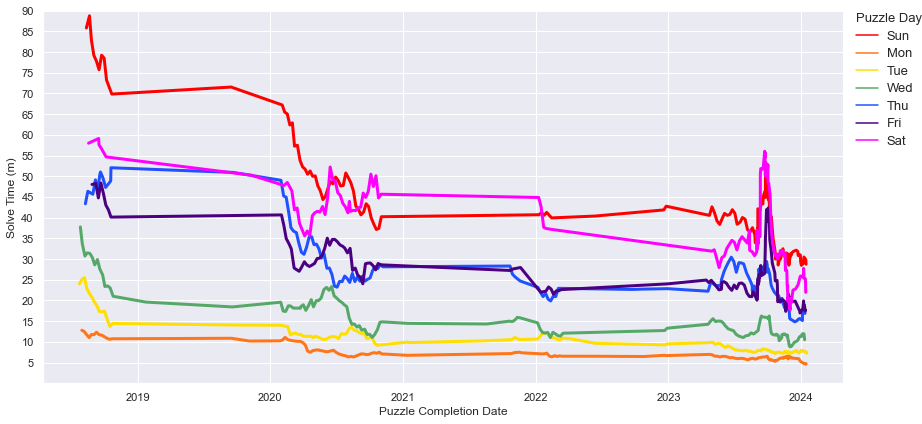

In [26]:
# Plot 10-puzzle moving average of IS2 Solve Times by Day of Week

sns.set(font_scale=1)

p = sns.relplot(
    data=df_IS2, marker = "", x="Comp_Date", y="IST(m)_10p_MA", hue="DOW", hue_order=["Sunday", "Monday", "Tuesday","Wednesday", "Thursday", "Friday", "Saturday"], height=6, aspect=2, palette = ["red", "#FF7518", "#ffdf00", "g", "#1F51FF", "indigo", "fuchsia"],
    kind="line", linewidth=3
).set(title="", 
    ylabel="Solve Time (m)",
    xlabel= "Puzzle Completion Date", yticks = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90], ylim=[0,90],
)

# Modify legend
leg = p._legend
leg.set_title("Puzzle Day")
leg.set_bbox_to_anchor([.88, .975])  # coordinates of lower left of bounding box
leg.get_title().set_fontsize(13)
leg._loc = 2  # if required you can set the loc
leg.get_texts()[0].set_fontsize(13)
leg.get_texts()[0].set_text('Sun')
leg.get_texts()[1].set_fontsize(13)
leg.get_texts()[1].set_text('Mon')
leg.get_texts()[2].set_fontsize(13)
leg.get_texts()[2].set_text('Tue')
leg.get_texts()[3].set_fontsize(13)
leg.get_texts()[3].set_text('Wed')
leg.get_texts()[4].set_fontsize(13)
leg.get_texts()[4].set_text('Thu')
leg.get_texts()[5].set_fontsize(13)
leg.get_texts()[5].set_text('Fri')
leg.get_texts()[6].set_fontsize(13)
leg.get_texts()[6].set_text('Sat')
leg._legend_box.align = "left"  # or left, or center

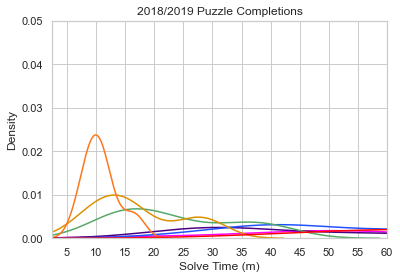

In [27]:
# Density Plot for 2018-2019 Only 
df2_2018_2019 = df_IS2.loc[(df_IS2["Comp_Yr"] == "2018") | (df_IS2["Comp_Yr"] == "2019")]

df2_2018_2019['plot_seq_map'] = df2_2018_2019['DOW_num'].map({1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5:'Thu', 6:'Fri', 7:'Sat'})
sns.set(style="whitegrid")
ax = sns.kdeplot(data=df2_2018_2019, x = "IST(m)", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], hue_order=["Sun", "Mon", "Tue","Wed", "Thu", "Fri", "Sat"], legend=False)

#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(2.5, 40)
plt.ylim(0, .05)
plt.xticks([5,10,15,20,25,30,35,40, 45, 50, 55, 60])
plt.title('2018/2019 Puzzle Completions')
ax.set_xlabel("Solve Time (m)")
plt.show()

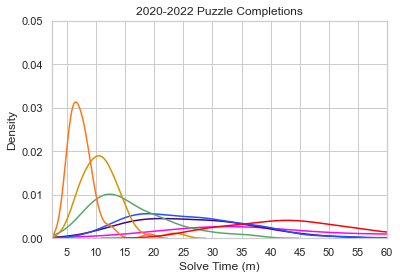

In [28]:
# Density Plot for 2020-2022 Only 
df2_2020_2022 = df_IS2.loc[(df_IS2["Comp_Yr"] == "2020") | (df_IS2["Comp_Yr"] == "2021") | (df_IS2["Comp_Yr"] == "2022")]

df2_2020_2022['plot_seq_map'] = df2_2020_2022['DOW_num'].map({1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5:'Thu', 6:'Fri', 7:'Sat'})
sns.set(style="whitegrid")
ax = sns.kdeplot(data=df2_2020_2022, x = "IST(m)", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], hue_order=["Sun", "Mon", "Tue","Wed", "Thu", "Fri", "Sat"], legend=False)

#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(2.5, 40)
plt.ylim(0, .05)
plt.xticks([5,10,15,20,25,30,35,40, 45, 50, 55, 60])
plt.title('2020-2022 Puzzle Completions')
ax.set_xlabel("Solve Time (m)")
plt.show()

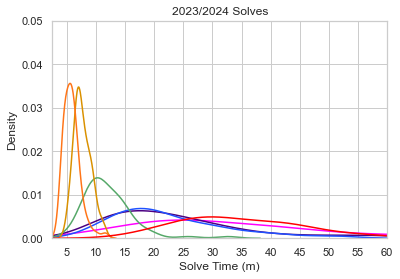

In [29]:
# Density Plot for 2023-2024 Only 
df2_2023_2024 = df_IS2.loc[(df_IS2["Comp_Yr"] == "2023") | (df_IS2["Comp_Yr"] == "2024")]

df2_2023_2024['plot_seq_map'] = df2_2023_2024['DOW_num'].map({1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5:'Thu', 6:'Fri', 7:'Sat'})
sns.set(style="whitegrid")
ax = sns.kdeplot(data=df2_2023_2024, x = "IST(m)", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], hue_order=["Sun", "Mon", "Tue","Wed", "Thu", "Fri", "Sat"], legend=False)

#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(2.5, 60)
plt.ylim(0, .05)
plt.xticks([5,10,15,20,25,30,35,40,45,50,55,60])
plt.title('2023/2024 Solves')
ax.set_xlabel("Solve Time (m)")
plt.show()

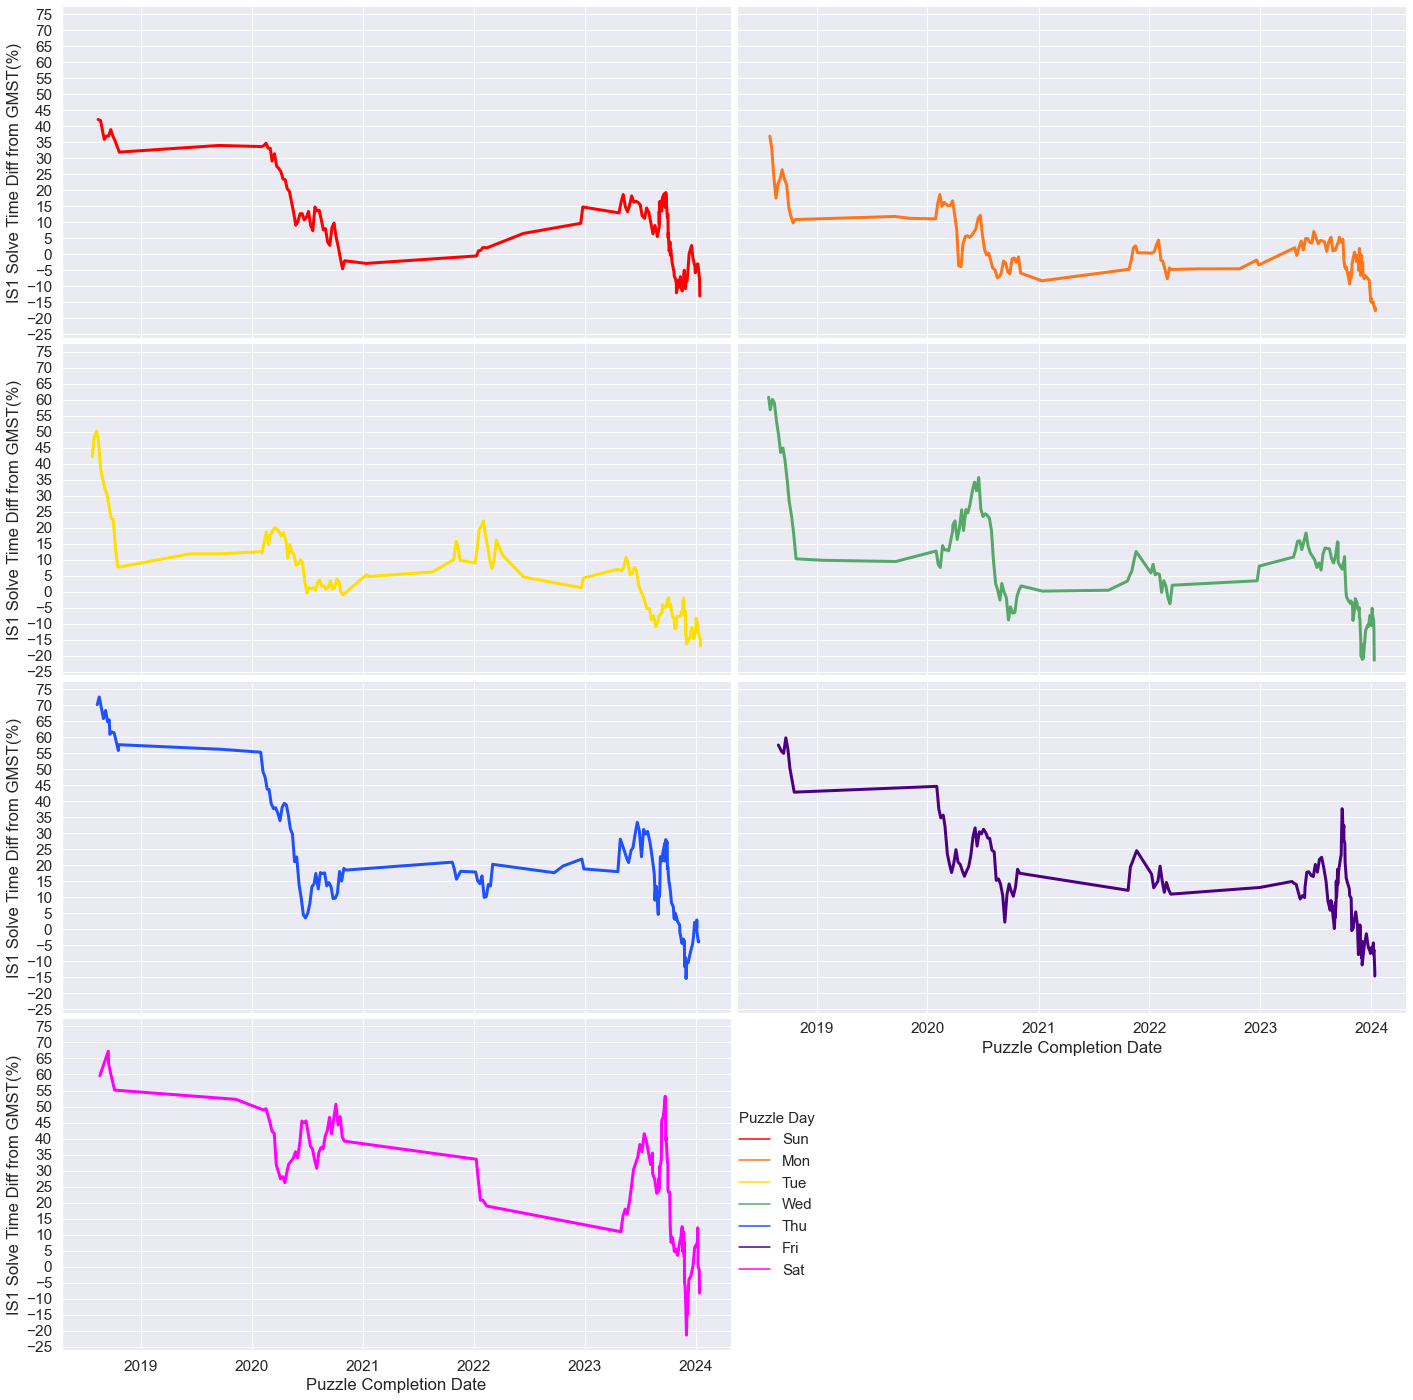

In [30]:
# Plot 10-puzzle moving average of % Difference in Individual Solve Times From Global Median Solve Times
# This normalizes for puzzle difficulty
sns.set(font_scale=1.4)
#sns.set(rc={'axes.facecolor':'gray',"axes.grid":True,'xtick.labelsize':14,'ytick.labelsize':14})

p = sns.relplot(
    data=df_IS2, marker = "", x="Comp_Date", y="IS_Diff%_GMST_10pMA", hue="DOW", hue_order=["Sunday", "Monday", "Tuesday","Wednesday", "Thursday", "Friday", "Saturday"], height=5, aspect=2, palette = ["red", "#FF7518", "#ffdf00", "g", "#1F51FF", "indigo", "fuchsia"],
    kind="line", linewidth=3, col="DOW", col_wrap=2, col_order=["Sunday", "Monday", "Tuesday","Wednesday", "Thursday", "Friday", "Saturday"]
).set(title="", ylabel="IS1 Solve Time Diff from GMST(%)",
    xlabel= "Puzzle Completion Date", yticks = [-25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]
)

plt.subplots_adjust(wspace = 0.01) #decrease whitespace btwn subplot colums
plt.subplots_adjust(hspace = 0.02) #decrease whitespace btwn subplot rows

# # # Modify legend
leg = p._legend
leg.set_title("Puzzle Day")
leg.set_bbox_to_anchor([.46, .21])  # coordinates of lower left of bounding box
leg.get_title().set_fontsize(15)
leg._loc = 2  # if required you can set the loc
leg.get_texts()[0].set_fontsize(15)
leg.get_texts()[0].set_text('Sun')
leg.get_texts()[1].set_fontsize(15)
leg.get_texts()[1].set_text('Mon')
leg.get_texts()[2].set_fontsize(15)
leg.get_texts()[2].set_text('Tue')
leg.get_texts()[3].set_fontsize(15)
leg.get_texts()[3].set_text('Wed')
leg.get_texts()[4].set_fontsize(15)
leg.get_texts()[4].set_text('Thu')
leg.get_texts()[5].set_fontsize(15)
leg.get_texts()[5].set_text('Fri')
leg.get_texts()[6].set_fontsize(15)
leg.get_texts()[6].set_text('Sat')
leg._legend_box.align = "left"  # or left, or center

#title="10-Puzzle Moving Average of % Difference in Solve Times From Global Median Solve Times (Solver 1)", 

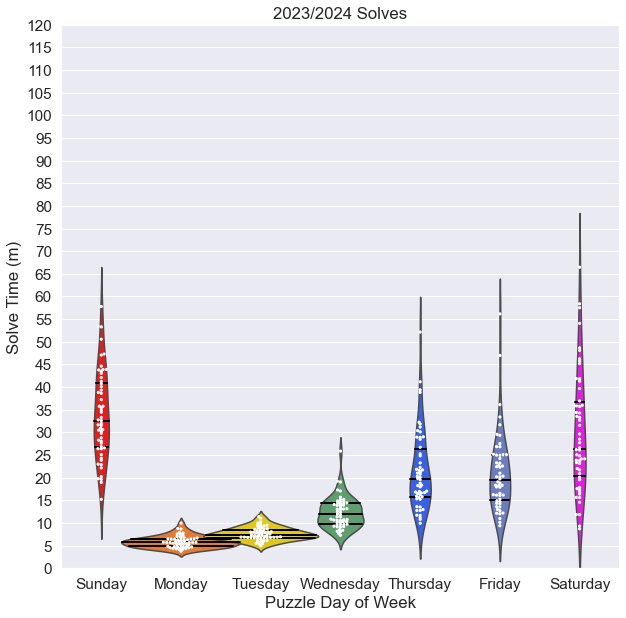

In [31]:
# Violin plots with swarm plot overlay by puzzle day -2023/4 only
sns.set(font_scale=1.4)

IS2_2023 = df_IS2.loc[df_IS2["P_Date_str"].str.contains("2023") | df_IS2["P_Date_str"].str.contains("2024")]

plt.figure(figsize=(10,10))
sns.swarmplot(x="DOW" , y = "IST(m)",data=IS2_2023 , size=3.2 , order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], color="White")
ax = sns.violinplot(IS2_2023['DOW'], IS2_2023['IST(m)'], width = 1.5, inner = "quartile", order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], palette = ["red", "#FF7518", "#ffdf00", "g", "#1F51FF", "#5d76cb", "fuchsia"])
plt.ylim(0, 120)
plt.yticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120])
ax.set_xlabel("Puzzle Day of Week")
ax.set_ylabel("Solve Time (m)")
ax.set_title("2023/2024 Solves")

for l in ax.lines:
    l.set_linestyle('-')
    l.set_linewidth(2)
    l.set_color('black')
    l.set_alpha(1)
plt.show()

In [32]:
# Calculate Median and IQR per puzzle day, for 2023/2024
print(IS2_2023.loc[(IS2_2023["DOW"] == "Sunday"), "IST(m)"].describe().round(1))
print(IS2_2023.loc[(IS2_2023["DOW"] == "Monday"), "IST(m)"].describe().round(1))
print(IS2_2023.loc[(IS2_2023["DOW"] == "Tuesday"), "IST(m)"].describe().round(1))
print(IS2_2023.loc[(IS2_2023["DOW"] == "Wednesday"), "IST(m)"].describe().round(1))
print(IS2_2023.loc[(IS2_2023["DOW"] == "Thursday"), "IST(m)"].describe().round(1))
print(IS2_2023.loc[(IS2_2023["DOW"] == "Friday"), "IST(m)"].describe().round(1))
print(IS2_2023.loc[(IS2_2023["DOW"] == "Saturday"), "IST(m)"].describe().round(1))

count    55.0
mean     33.9
std       9.7
min      15.2
25%      26.7
50%      32.6
75%      41.0
max      57.8
Name: IST(m), dtype: float64
count    55.0
mean      5.9
std       1.3
min       3.8
25%       4.8
50%       5.7
75%       6.5
max      10.0
Name: IST(m), dtype: float64
count    55.0
mean      7.6
std       1.4
min       5.0
25%       6.8
50%       7.4
75%       8.5
max      11.4
Name: IST(m), dtype: float64
count    54.0
mean     12.4
std       3.4
min       7.3
25%       9.8
50%      11.9
75%      14.3
max      25.9
Name: IST(m), dtype: float64
count    54.0
mean     21.5
std       8.7
min       9.9
25%      15.8
50%      19.7
75%      26.4
max      52.2
Name: IST(m), dtype: float64
count    54.0
mean     21.0
std       8.7
min       9.4
25%      15.0
50%      19.4
75%      25.0
max      56.2
Name: IST(m), dtype: float64
count    54.0
mean     29.9
std      13.3
min       8.7
25%      20.3
50%      26.4
75%      36.7
max      66.5
Name: IST(m), dtype: float64


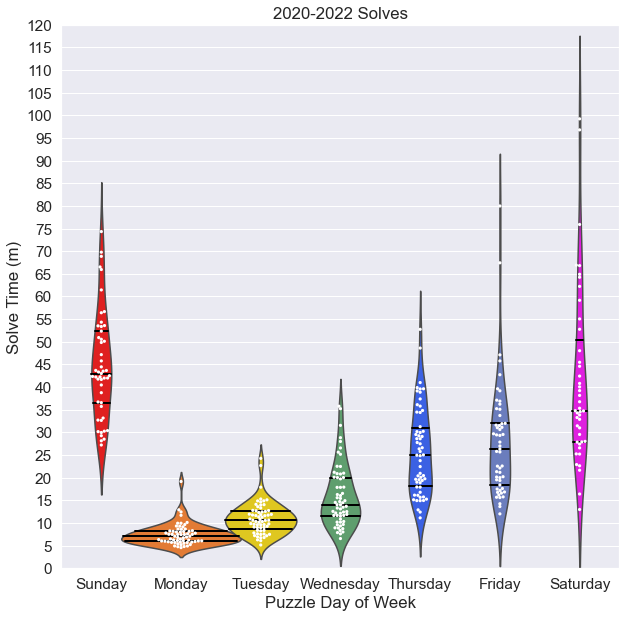

In [33]:
# Violin plots with swarm plot overlay by puzzle day 2020-2022 solves only

IS2_2022 = df_IS2.loc[df_IS2["Comp_Date_str"].str.contains("2020") | df_IS2["Comp_Date_str"].str.contains("2021") | df_IS2["Comp_Date_str"].str.contains("2022")]

plt.figure(figsize=(10,10))
sns.swarmplot(x="DOW" , y = "IST(m)",data=IS2_2022 , size=3.2 , order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], color="White")
ax = sns.violinplot(IS2_2022['DOW'], IS2_2022['IST(m)'], width = 1.5, inner = "quartile", order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], palette = ["red", "#FF7518", "#ffdf00", "g", "#1F51FF", "#5d76cb", "fuchsia"])
plt.ylim(0, 120)
plt.yticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120])
ax.set_xlabel("Puzzle Day of Week")
ax.set_ylabel("Solve Time (m)")
ax.set_title("2020-2022 Solves")

for l in ax.lines:
    l.set_linestyle('-')
    l.set_linewidth(2)
    l.set_color('black')
    l.set_alpha(1)
plt.show()

In [34]:
# Calculate Median and IQR per puzzle day, for 2020-2022 solves
print(IS2_2022.loc[(IS2_2022["DOW"] == "Sunday"), "IST(m)"].describe().round(1))
print(IS2_2022.loc[(IS2_2022["DOW"] == "Monday"), "IST(m)"].describe().round(1))
print(IS2_2022.loc[(IS2_2022["DOW"] == "Tuesday"), "IST(m)"].describe().round(1))
print(IS2_2022.loc[(IS2_2022["DOW"] == "Wednesday"), "IST(m)"].describe().round(1))
print(IS2_2022.loc[(IS2_2022["DOW"] == "Thursday"), "IST(m)"].describe().round(1))
print(IS2_2022.loc[(IS2_2022["DOW"] == "Friday"), "IST(m)"].describe().round(1))
print(IS2_2022.loc[(IS2_2022["DOW"] == "Saturday"), "IST(m)"].describe().round(1))

count    49.0
mean     44.9
std      11.9
min      27.2
25%      36.6
50%      43.0
75%      52.4
max      74.3
Name: IST(m), dtype: float64
count    62.0
mean      7.5
std       2.4
min       4.6
25%       5.9
50%       7.1
75%       8.2
max      19.2
Name: IST(m), dtype: float64
count    63.0
mean     11.0
std       3.5
min       5.2
25%       8.7
50%      10.6
75%      12.6
max      24.3
Name: IST(m), dtype: float64
count    61.0
mean     16.0
std       6.8
min       6.6
25%      11.5
50%      14.0
75%      20.0
max      35.8
Name: IST(m), dtype: float64
count    58.0
mean     25.9
std       9.6
min      11.1
25%      18.2
50%      25.0
75%      31.0
max      52.8
Name: IST(m), dtype: float64
count    53.0
mean     27.9
std      12.8
min      12.0
25%      18.4
50%      26.3
75%      32.0
max      80.0
Name: IST(m), dtype: float64
count    43.0
mean     41.6
std      19.5
min      13.0
25%      28.0
50%      34.8
75%      50.4
max      99.2
Name: IST(m), dtype: float64


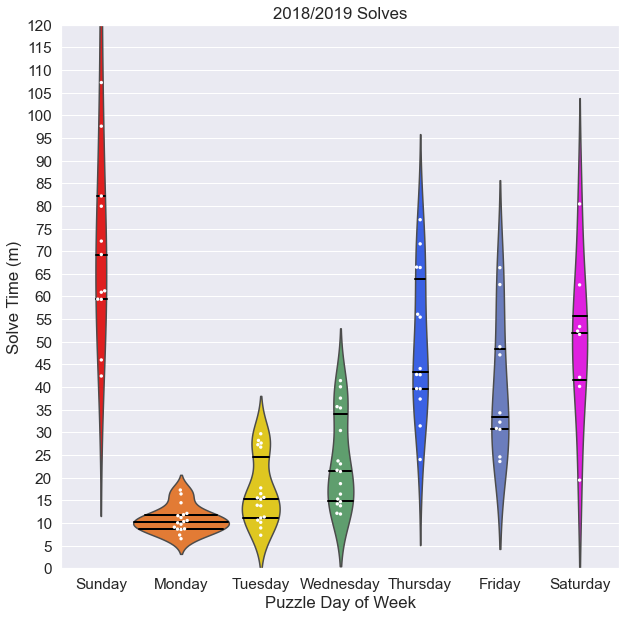

In [35]:
# Violin plots with swarm plot overlay by puzzle day 2018-2019 solves only

IS2_pre2020 = df_IS2.loc[df_IS2["Comp_Date_str"].str.contains("2018") | df_IS2["Comp_Date_str"].str.contains("2019")]

plt.figure(figsize=(10,10))
sns.swarmplot(x="DOW" , y = "IST(m)",data=IS2_pre2020 , size=3.4 , order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], color="White")
ax = sns.violinplot(IS2_pre2020['DOW'], IS2_pre2020['IST(m)'], width = 1.2, inner = "quartile", order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], palette = ["red", "#FF7518", "#ffdf00", "g", "#1F51FF", "#5d76cb", "fuchsia"])
plt.ylim(0, 107.5)
plt.yticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120])
ax.set_xlabel("Puzzle Day of Week")
ax.set_ylabel("Solve Time (m)")
ax.set_title("2018/2019 Solves")

for l in ax.lines:
    l.set_linestyle('-')
    l.set_linewidth(2)
    l.set_color('black')
    l.set_alpha(1)
plt.show()

In [36]:
# Calculate Median and IQR per puzzle day, for 2018/2019 solves
print(IS2_pre2020.loc[(IS2_pre2020["DOW"] == "Sunday"), "IST(m)"].describe().round(1))
print(IS2_pre2020.loc[(IS2_pre2020["DOW"] == "Monday"), "IST(m)"].describe().round(1))
print(IS2_pre2020.loc[(IS2_pre2020["DOW"] == "Tuesday"), "IST(m)"].describe().round(1))
print(IS2_pre2020.loc[(IS2_pre2020["DOW"] == "Wednesday"), "IST(m)"].describe().round(1))
print(IS2_pre2020.loc[(IS2_pre2020["DOW"] == "Thursday"), "IST(m)"].describe().round(1))
print(IS2_pre2020.loc[(IS2_pre2020["DOW"] == "Friday"), "IST(m)"].describe().round(1))
print(IS2_pre2020.loc[(IS2_pre2020["DOW"] == "Saturday"), "IST(m)"].describe().round(1))

count     13.0
mean      74.8
std       25.9
min       42.4
25%       59.4
50%       69.3
75%       82.2
max      135.0
Name: IST(m), dtype: float64
count    17.0
mean     10.9
std       3.0
min       6.5
25%       8.7
50%      10.3
75%      11.8
max      17.3
Name: IST(m), dtype: float64
count    18.0
mean     17.1
std       7.4
min       7.3
25%      11.2
50%      15.4
75%      24.5
max      29.7
Name: IST(m), dtype: float64
count    18.0
mean     23.8
std      10.3
min      12.0
25%      14.9
50%      21.5
75%      34.2
max      41.4
Name: IST(m), dtype: float64
count    14.0
mean     49.6
std      16.0
min      24.0
25%      39.6
50%      43.4
75%      63.8
max      77.0
Name: IST(m), dtype: float64
count    10.0
mean     40.1
std      15.3
min      23.6
25%      30.7
50%      33.3
75%      48.5
max      66.4
Name: IST(m), dtype: float64
count     8.0
mean     50.3
std      17.7
min      19.5
25%      41.7
50%      52.0
75%      55.7
max      80.4
Name: IST(m), dtype: float64


###  Partition of 2023-2024 Data Only

In [37]:
df_recent = df_IS2.loc[(df_IS2["Comp_Date"] >='04/01/2023')]

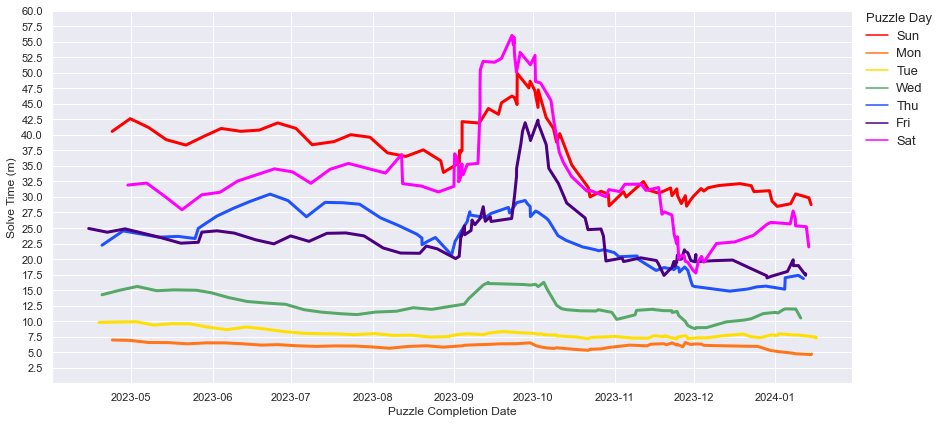

In [38]:
# Plot 10-puzzle moving average of IS2 Solve Times by Day of Week

sns.set(font_scale=1)

p = sns.relplot(
    data=df_recent, marker = "", x="Comp_Date", y="IST(m)_10p_MA", hue="DOW", hue_order=["Sunday", "Monday", "Tuesday","Wednesday", "Thursday", "Friday", "Saturday"], height=6, aspect=2, palette = ["red", "#FF7518", "#ffdf00", "g", "#1F51FF", "indigo", "fuchsia"],
    kind="line", linewidth=3
).set(title="", 
    ylabel="Solve Time (m)",
    xlabel= "Puzzle Completion Date", yticks = [2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35, 37.5, 40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60], ylim=[0,60],
)

# Modify legend
leg = p._legend
leg.set_title("Puzzle Day")
leg.set_bbox_to_anchor([.89, .975])  # coordinates of lower left of bounding box
leg.get_title().set_fontsize(13)
leg._loc = 2  # if required you can set the loc
leg.get_texts()[0].set_fontsize(13)
leg.get_texts()[0].set_text('Sun')
leg.get_texts()[1].set_fontsize(13)
leg.get_texts()[1].set_text('Mon')
leg.get_texts()[2].set_fontsize(13)
leg.get_texts()[2].set_text('Tue')
leg.get_texts()[3].set_fontsize(13)
leg.get_texts()[3].set_text('Wed')
leg.get_texts()[4].set_fontsize(13)
leg.get_texts()[4].set_text('Thu')
leg.get_texts()[5].set_fontsize(13)
leg.get_texts()[5].set_text('Fri')
leg.get_texts()[6].set_fontsize(13)
leg.get_texts()[6].set_text('Sat')
leg._legend_box.align = "left"  # or left, or center

In [ ]:
df_recent.info()

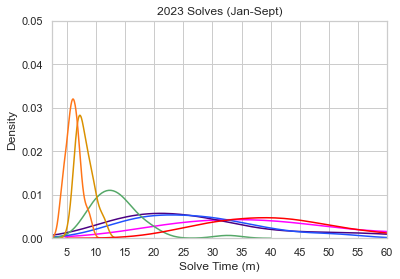

In [39]:
# Density Plot for 01/01/2023-09/30/2023 only 
df2_2023_2024_1 = df_recent.loc[(df_recent["Comp_Date"] <'10/01/2023')]

df2_2023_2024_1['plot_seq_map'] = df2_2023_2024_1['DOW_num'].map({1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5:'Thu', 6:'Fri', 7:'Sat'})
sns.set(style="whitegrid")
ax = sns.kdeplot(data=df2_2023_2024_1, x = "IST(m)", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], hue_order=["Sun", "Mon", "Tue","Wed", "Thu", "Fri", "Sat"], legend=False)

#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(2.5, 60)
plt.ylim(0, .05)
plt.xticks([5,10,15,20,25,30,35,40,45,50,55,60])
plt.title('2023 Solves (Jan-Sept)')
ax.set_xlabel("Solve Time (m)")
plt.show()

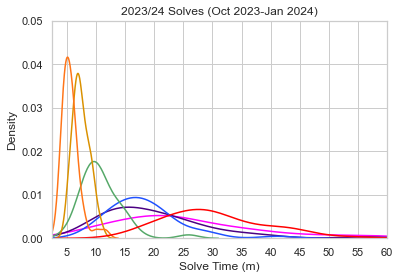

In [40]:
# Density Plot for 10/01/2023-01/16/2024 only 
df2_2023_2024_2 = df_recent.loc[(df_recent["Comp_Date"] >='10/01/2023')]

df2_2023_2024_2['plot_seq_map'] = df2_2023_2024_2['DOW_num'].map({1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5:'Thu', 6:'Fri', 7:'Sat'})
sns.set(style="whitegrid")
ax = sns.kdeplot(data=df2_2023_2024_2, x = "IST(m)", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], hue_order=["Sun", "Mon", "Tue","Wed", "Thu", "Fri", "Sat"], legend=False)

#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(2.5, 60)
plt.ylim(0, .05)
plt.xticks([5,10,15,20,25,30,35,40,45,50,55,60])
plt.title('2023/24 Solves (Oct 2023-Jan 2024)')
ax.set_xlabel("Solve Time (m)")
plt.show()

In [ ]:
df2_2023_2024_2.info()

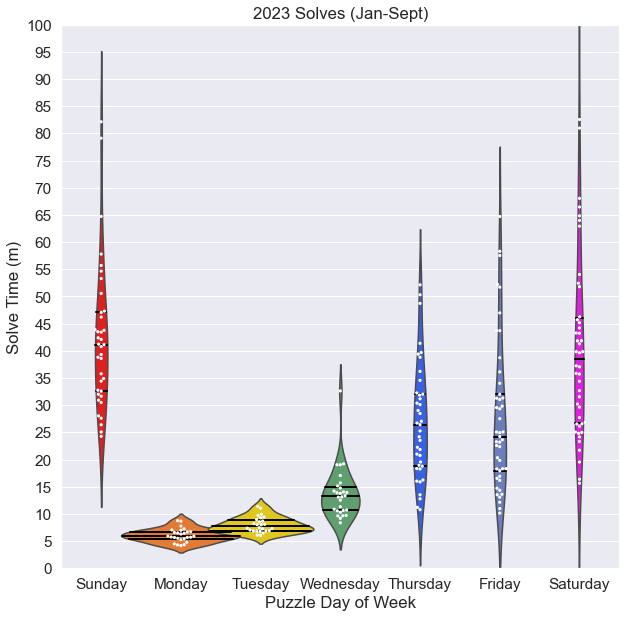

In [41]:
# Violin plots with swarm plot overlay by puzzle day -2023 first interval only
sns.set(font_scale=1.4)

plt.figure(figsize=(10,10))
sns.swarmplot(x="DOW" , y = "IST(m)",data=df2_2023_2024_1, size=3.2 , order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], color="White")
ax = sns.violinplot(df2_2023_2024_1['DOW'], df2_2023_2024_1['IST(m)'], width = 1.5, inner = "quartile", order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], palette = ["red", "#FF7518", "#ffdf00", "g", "#1F51FF", "#5d76cb", "fuchsia"])
plt.ylim(0, 100)
plt.yticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100])
ax.set_xlabel("Puzzle Day of Week")
ax.set_ylabel("Solve Time (m)")
ax.set_title("2023 Solves (Jan-Sept)")

for l in ax.lines:
    l.set_linestyle('-')
    l.set_linewidth(2)
    l.set_color('black')
    l.set_alpha(1)
plt.show()

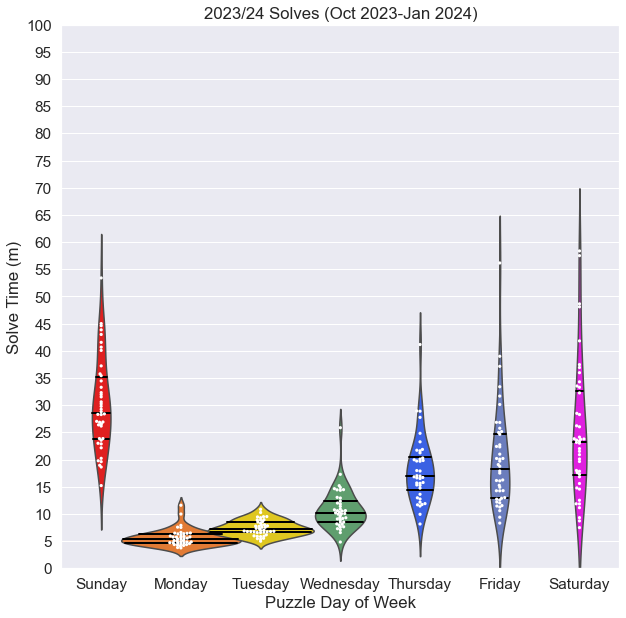

In [42]:
# Violin plots with swarm plot overlay by puzzle day -2023-2024 second interval only
sns.set(font_scale=1.4)

plt.figure(figsize=(10,10))
sns.swarmplot(x="DOW" , y = "IST(m)",data=df2_2023_2024_2, size=3.2 , order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], color="White")
ax = sns.violinplot(df2_2023_2024_2['DOW'], df2_2023_2024_2['IST(m)'], width = 1.5, inner = "quartile", order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], palette = ["red", "#FF7518", "#ffdf00", "g", "#1F51FF", "#5d76cb", "fuchsia"])
plt.ylim(0, 100)
plt.yticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100])
ax.set_xlabel("Puzzle Day of Week")
ax.set_ylabel("Solve Time (m)")
ax.set_title("2023/24 Solves (Oct 2023-Jan 2024)")

for l in ax.lines:
    l.set_linestyle('-')
    l.set_linewidth(2)
    l.set_color('black')
    l.set_alpha(1)
plt.show()

In [43]:
# Calculate Median and IQR per puzzle day, for 2023/2024 first interval
print(df2_2023_2024_1.loc[(df2_2023_2024_1["DOW"] == "Sunday"), "IST(m)"].describe().round(1))
print(df2_2023_2024_1.loc[(df2_2023_2024_1["DOW"] == "Monday"), "IST(m)"].describe().round(1))
print(df2_2023_2024_1.loc[(df2_2023_2024_1["DOW"] == "Tuesday"), "IST(m)"].describe().round(1))
print(df2_2023_2024_1.loc[(df2_2023_2024_1["DOW"] == "Wednesday"), "IST(m)"].describe().round(1))
print(df2_2023_2024_1.loc[(df2_2023_2024_1["DOW"] == "Thursday"), "IST(m)"].describe().round(1))
print(df2_2023_2024_1.loc[(df2_2023_2024_1["DOW"] == "Friday"), "IST(m)"].describe().round(1))
print(df2_2023_2024_1.loc[(df2_2023_2024_1["DOW"] == "Saturday"), "IST(m)"].describe().round(1))

count    37.0
mean     42.3
std      13.4
min      24.3
25%      32.6
50%      41.2
75%      47.1
max      82.2
Name: IST(m), dtype: float64
count    26.0
mean      6.1
std       1.2
min       4.2
25%       5.5
50%       5.9
75%       6.7
max       8.8
Name: IST(m), dtype: float64
count    26.0
mean      8.0
std       1.4
min       6.0
25%       6.9
50%       7.7
75%       8.9
max      11.4
Name: IST(m), dtype: float64
count    28.0
mean     13.8
std       4.8
min       8.4
25%      10.6
50%      13.2
75%      14.9
max      32.6
Name: IST(m), dtype: float64
count    39.0
mean     27.1
std      10.7
min      10.8
25%      18.9
50%      26.4
75%      32.1
max      52.2
Name: IST(m), dtype: float64
count    45.0
mean     27.8
std      13.8
min      10.2
25%      18.0
50%      24.2
75%      32.0
max      64.7
Name: IST(m), dtype: float64
count     46.0
mean      41.4
std       19.2
min       15.6
25%       26.7
50%       38.5
75%       46.1
max      110.8
Name: IST(m), dtype: float64


In [44]:
# Calculate Median and IQR per puzzle day, for 2023/2024 second interval
print(df2_2023_2024_2.loc[(df2_2023_2024_2["DOW"] == "Sunday"), "IST(m)"].describe().round(1))
print(df2_2023_2024_2.loc[(df2_2023_2024_2["DOW"] == "Monday"), "IST(m)"].describe().round(1))
print(df2_2023_2024_2.loc[(df2_2023_2024_2["DOW"] == "Tuesday"), "IST(m)"].describe().round(1))
print(df2_2023_2024_2.loc[(df2_2023_2024_2["DOW"] == "Wednesday"), "IST(m)"].describe().round(1))
print(df2_2023_2024_2.loc[(df2_2023_2024_2["DOW"] == "Thursday"), "IST(m)"].describe().round(1))
print(df2_2023_2024_2.loc[(df2_2023_2024_2["DOW"] == "Friday"), "IST(m)"].describe().round(1))
print(df2_2023_2024_2.loc[(df2_2023_2024_2["DOW"] == "Saturday"), "IST(m)"].describe().round(1))

count    42.0
mean     30.2
std       8.5
min      15.2
25%      23.9
50%      28.6
75%      35.2
max      53.4
Name: IST(m), dtype: float64
count    41.0
mean      5.7
std       1.6
min       3.8
25%       4.7
50%       5.4
75%       6.3
max      11.6
Name: IST(m), dtype: float64
count    42.0
mean      7.4
std       1.4
min       5.0
25%       6.6
50%       7.2
75%       8.5
max      10.8
Name: IST(m), dtype: float64
count    41.0
mean     10.9
std       3.6
min       4.8
25%       8.5
50%      10.2
75%      12.4
max      25.9
Name: IST(m), dtype: float64
count    40.0
mean     18.2
std       6.2
min       8.2
25%      14.5
50%      16.9
75%      20.5
max      41.2
Name: IST(m), dtype: float64
count    44.0
mean     20.1
std       9.3
min       8.3
25%      13.0
50%      18.3
75%      24.7
max      56.2
Name: IST(m), dtype: float64
count    44.0
mean     25.1
std      12.3
min       7.5
25%      17.2
50%      23.3
75%      32.5
max      58.4
Name: IST(m), dtype: float64


### IS2 vs GMS Figures

In [45]:
# Construct numerical categories in desired plotting sequence for combinations of puzzle day and pre-2023 or 2023
# This is a hack to be able to use lmplot with subplot split and get regression lines - need to figure out more elegant solution

# A numerical column for puzzle day that starts with Sunday and ends with Saturday
df_IS2.loc[(df_IS2["DOW"] == "Sunday") & (df_IS2["2023+_solve"] == 0) , "plot_seq"] = 1 
df_IS2.loc[(df_IS2["DOW"] == "Sunday") & (df_IS2["2023+_solve"] == 1) , "plot_seq"] = 2
df_IS2.loc[(df_IS2["DOW"] == "Monday") & (df_IS2["2023+_solve"] == 0) , "plot_seq"] = 3 
df_IS2.loc[(df_IS2["DOW"] == "Monday") & (df_IS2["2023+_solve"] == 1) , "plot_seq"] = 4
df_IS2.loc[(df_IS2["DOW"] == "Tuesday") & (df_IS2["2023+_solve"] == 0) , "plot_seq"] = 5 
df_IS2.loc[(df_IS2["DOW"] == "Tuesday") & (df_IS2["2023+_solve"] == 1) , "plot_seq"] = 6
df_IS2.loc[(df_IS2["DOW"] == "Wednesday") & (df_IS2["2023+_solve"] == 0) , "plot_seq"] = 7 
df_IS2.loc[(df_IS2["DOW"] == "Wednesday") & (df_IS2["2023+_solve"] == 1) , "plot_seq"] = 8
df_IS2.loc[(df_IS2["DOW"] == "Thursday") & (df_IS2["2023+_solve"] == 0) , "plot_seq"] = 9 
df_IS2.loc[(df_IS2["DOW"] == "Thursday") & (df_IS2["2023+_solve"] == 1) , "plot_seq"] = 10
df_IS2.loc[(df_IS2["DOW"] == "Friday") & (df_IS2["2023+_solve"] == 0) , "plot_seq"] = 11 
df_IS2.loc[(df_IS2["DOW"] == "Friday") & (df_IS2["2023+_solve"] == 1) , "plot_seq"] = 12
df_IS2.loc[(df_IS2["DOW"] == "Saturday") & (df_IS2["2023+_solve"] == 0) , "plot_seq"] = 13 
df_IS2.loc[(df_IS2["DOW"] == "Saturday") & (df_IS2["2023+_solve"] == 1) , "plot_seq"] = 14

In [ ]:
df_IS2["plot_seq"].unique()

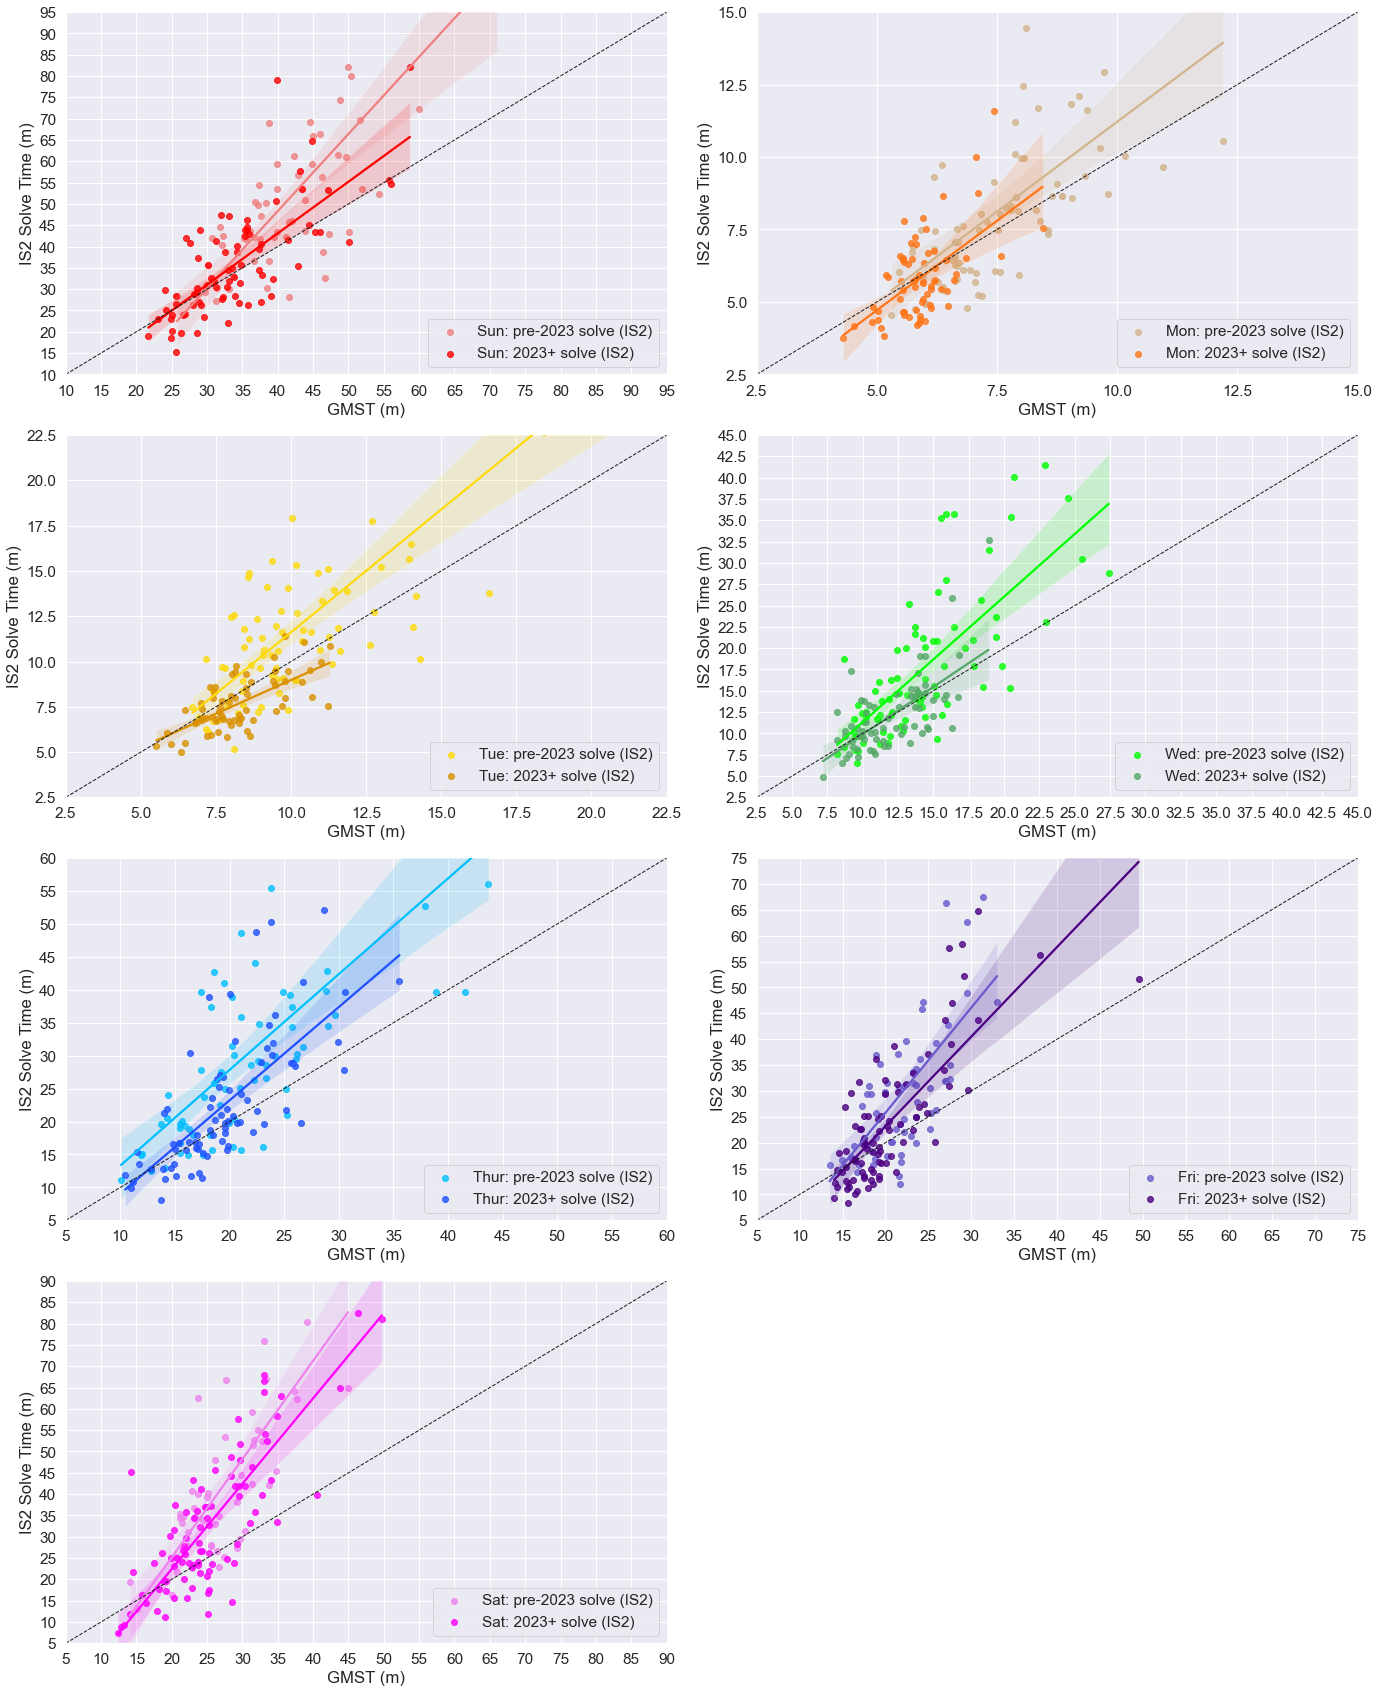

In [46]:
# Scatterplots of individual raw solve times vs global median solve times, per puzzle day

df_IS2 = df_IS2.sort_values(by=['plot_seq'], ascending = True)

sns.set(font_scale=1.4)

df_IS2['plot_seq_map'] = df_IS2['plot_seq'].map({1:'Sun: pre-2023 solve (IS2)', 2:'Sun: 2023+ solve (IS2)', 3:'Mon: pre-2023 solve (IS2)', 4:'Mon: 2023+ solve (IS2)', 5:'Tue: pre-2023 solve (IS2)', 6:'Tue: 2023+ solve (IS2)', 7:'Wed: pre-2023 solve (IS2)', 8:'Wed: 2023+ solve (IS2)', 9:'Thur: pre-2023 solve (IS2)', 10:'Thur: 2023+ solve (IS2)', 11:'Fri: pre-2023 solve (IS2)', 12:'Fri: 2023+ solve (IS2)', 13:'Sat: pre-2023 solve (IS2)', 14:'Sat: 2023+ solve (IS2)'})

#sequence = {0:'pre-2023 solve', 1:'2023 solve', 2:'pre-2023 solve', 3:'2023 solve', 4:'pre-2023 solve', 5:'2023 solve', 6:'pre-2023 solve', 7:'2023 solve', 8:'pre-2023 solve', 9:'2023 solve', 10:'pre-2023 solve', 11:'2023 solve', 12:'pre-2023 solve', 13:'2023 solve'}

p = sns.lmplot(
    data=df_IS2, x="GMST(m)", y="IST(m)", hue="plot_seq_map", col="DOW", col_order=["Sunday", "Monday", "Tuesday","Wednesday", "Thursday", "Friday", "Saturday"], col_wrap=2, palette=["lightcoral", "red", "tan", "#FF7518", "#FDDA0D", "#da9100", "lime", "g", "deepskyblue", "#1F51FF", "slateblue", "indigo", "violet", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False
).set(title="", xlabel= "GMST (m)",
    ylabel="IS2 Solve Time (m)", xticks = [2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35, 37.5, 40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60, 62.5, 65, 67.5, 70, 72.5, 75, 77.5, 80, 82.5, 85], yticks = [2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35, 37.5, 40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60, 62.5, 65, 67.5, 70, 72.5, 75, 77.5, 80, 82.5, 85]  
)

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

#Adjust subplots individually
p.axes[0].set_ylim((12.5,95))
p.axes[0].set_xlim((12.5,95))
p.axes[1].set_ylim((2.5,15))
p.axes[1].set_xlim((2.5,15))
p.axes[2].set_ylim((2.5,22.5))
p.axes[2].set_xlim((2.5,22.5))
p.axes[3].set_ylim((2.5,45))
p.axes[3].set_xlim((2.5,45))
p.axes[4].set_ylim((5,60))
p.axes[4].set_xlim((5,60))
p.axes[5].set_ylim((5,75))
p.axes[5].set_xlim((5,75))
p.axes[6].set_ylim((5,90))
p.axes[6].set_xlim((5,90))

p.axes[0].set_xticks((10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95))
p.axes[0].set_yticks((10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95))
p.axes[4].set_xticks((5,10,15,20,25,30,35,40,45,50,55,60))
p.axes[4].set_yticks((5,10,15,20,25,30,35,40,45,50,55,60))
p.axes[5].set_xticks((5,10,15,20,25,30,35,40,45,50,55,60,65,70,75))
p.axes[5].set_yticks((5,10,15,20,25,30,35,40,45,50,55,60,65,70,75))
p.axes[6].set_xticks((5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90))
p.axes[6].set_yticks((5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90))

p.axes[0].plot([10, 95], [10, 95], 'k', linestyle='dashed', linewidth=1)
p.axes[1].plot([2.5, 15], [2.5, 15], 'k', linestyle='dashed', linewidth=1)
p.axes[2].plot([2.5, 22.5], [2.5, 22.5], 'k', linestyle='dashed', linewidth=1)
p.axes[3].plot([2.5, 45], [2.5, 45], 'k', linestyle='dashed', linewidth=1)
p.axes[4].plot([5, 60], [5, 60], 'k', linestyle='dashed', linewidth=1)
p.axes[5].plot([5, 75], [5, 75], 'k', linestyle='dashed', linewidth=1)
p.axes[6].plot([5, 90], [5, 90], 'k', linestyle='dashed', linewidth=1)

_= p.axes[0].legend(loc="lower right")
_= p.axes[1].legend(loc="lower right")
_= p.axes[2].legend(loc="lower right")
_= p.axes[3].legend(loc="lower right")
_= p.axes[4].legend(loc="lower right")
_= p.axes[5].legend(loc="lower right")
_= p.axes[6].legend(loc="lower right")

In [47]:
# Correlations for 2023_2024 for IST vs GMST
df_IS2_2023_2024 = df_IS2.loc[(df_IS2["2023+_solve"] == 1)]
df_Sun = df_IS2_2023_2024.loc[df_IS2_2023_2024["DOW"]==("Sunday")]
df_Mon = df_IS2_2023_2024.loc[df_IS2_2023_2024["DOW"]==("Monday")]
df_Tue = df_IS2_2023_2024.loc[df_IS2_2023_2024["DOW"]==("Tuesday")]
df_Wed = df_IS2_2023_2024.loc[df_IS2_2023_2024["DOW"]==("Wednesday")]
df_Thu = df_IS2_2023_2024.loc[df_IS2_2023_2024["DOW"]==("Thursday")]
df_Fri = df_IS2_2023_2024.loc[df_IS2_2023_2024["DOW"]==("Friday")]
df_Sat = df_IS2_2023_2024.loc[df_IS2_2023_2024["DOW"]==("Saturday")]

print(df_Sun['IST(m)'].corr(df_Sun['GMST(m)']))
print(df_Mon['IST(m)'].corr(df_Mon['GMST(m)']))
print(df_Tue['IST(m)'].corr(df_Tue['GMST(m)']))
print(df_Wed['IST(m)'].corr(df_Wed['GMST(m)']))
print(df_Thu['IST(m)'].corr(df_Thu['GMST(m)']))
print(df_Fri['IST(m)'].corr(df_Fri['GMST(m)']))
print(df_Sat['IST(m)'].corr(df_Sat['GMST(m)']))

0.7431231490294061
0.579776784176702
0.6774891921290787
0.6632893541850441
0.715859510604164
0.7836903797353584
0.8094574452406472


In [48]:
# Correlations for pre-2023 for IST vs GMST
df_IS2_pre2023 = df_IS2.loc[(df_IS2["2023+_solve"] == 0)]
df_Sun = df_IS2_pre2023.loc[df_IS2_pre2023["DOW"]==("Sunday")]
df_Mon = df_IS2_pre2023.loc[df_IS2_pre2023["DOW"]==("Monday")]
df_Tue = df_IS2_pre2023.loc[df_IS2_pre2023["DOW"]==("Tuesday")]
df_Wed = df_IS2_pre2023.loc[df_IS2_pre2023["DOW"]==("Wednesday")]
df_Thu = df_IS2_pre2023.loc[df_IS2_pre2023["DOW"]==("Thursday")]
df_Fri = df_IS2_pre2023.loc[df_IS2_pre2023["DOW"]==("Friday")]
df_Sat = df_IS2_pre2023.loc[df_IS2_pre2023["DOW"]==("Saturday")]

print(df_Sun['IST(m)'].corr(df_Sun['GMST(m)']))
print(df_Mon['IST(m)'].corr(df_Mon['GMST(m)']))
print(df_Tue['IST(m)'].corr(df_Tue['GMST(m)']))
print(df_Wed['IST(m)'].corr(df_Wed['GMST(m)']))
print(df_Thu['IST(m)'].corr(df_Thu['GMST(m)']))
print(df_Fri['IST(m)'].corr(df_Fri['GMST(m)']))
print(df_Sat['IST(m)'].corr(df_Sat['GMST(m)']))

0.8163405670727237
0.6028254804444724
0.8006403192036123
0.7275313134707442
0.6793666331252084
0.600994075832972
0.781223126196963


In [51]:
# Win % IS2 vs GMS by Puzzle Day: pre-2023 solves
IST_wins = len(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Sunday") & (df_IS2["IST(m)"] < df_IS2["GMST(m)"])])
GMST_wins = len(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Sunday") & (df_IS2["IST(m)"] > df_IS2["GMST(m)"])])
Ties = len(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Sunday") & (df_IS2["IST(m)"] == df_IS2["GMST(m)"])])
Sun_IST_win_pct = (IST_wins/(IST_wins + GMST_wins + Ties))*100
print(Sun_IST_win_pct)

IST_wins = len(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Monday") & (df_IS2["IST(m)"] < df_IS2["GMST(m)"])])
GMST_wins = len(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Monday") & (df_IS2["IST(m)"] > df_IS2["GMST(m)"])])
Ties = len(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Monday") & (df_IS2["IST(m)"] == df_IS2["GMST(m)"])])
Mon_IST_win_pct = (IST_wins/(IST_wins + GMST_wins + Ties))*100
print(Mon_IST_win_pct)

IST_wins = len(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Tuesday") & (df_IS2["IST(m)"] < df_IS2["GMST(m)"])])
GMST_wins = len(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Tuesday") & (df_IS2["IST(m)"] > df_IS2["GMST(m)"])])
Ties = len(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Tuesday") & (df_IS2["IST(m)"] == df_IS2["GMST(m)"])])
Tue_IST_win_pct = (IST_wins/(IST_wins + GMST_wins + Ties))*100
print(Tue_IST_win_pct)

IST_wins = len(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Wednesday") & (df_IS2["IST(m)"] < df_IS2["GMST(m)"])])
GMST_wins = len(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Wednesday") & (df_IS2["IST(m)"] > df_IS2["GMST(m)"])])
Ties = len(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Wednesday") & (df_IS2["IST(m)"] == df_IS2["GMST(m)"])])
Wed_IST_win_pct = (IST_wins/(IST_wins + GMST_wins + Ties))*100
print(Wed_IST_win_pct)

IST_wins = len(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Thursday") & (df_IS2["IST(m)"] < df_IS2["GMST(m)"])])
GMST_wins = len(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Thursday") & (df_IS2["IST(m)"] > df_IS2["GMST(m)"])])
Ties = len(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Thursday") & (df_IS2["IST(m)"] == df_IS2["GMST(m)"])])
Thu_IST_win_pct = (IST_wins/(IST_wins + GMST_wins + Ties))*100
print(Thu_IST_win_pct)

IST_wins = len(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Friday") & (df_IS2["IST(m)"] < df_IS2["GMST(m)"])])
GMST_wins = len(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Friday") & (df_IS2["IST(m)"] > df_IS2["GMST(m)"])])
Ties = len(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Friday") & (df_IS2["IST(m)"] == df_IS2["GMST(m)"])])
Fri_IST_win_pct = (IST_wins/(IST_wins + GMST_wins + Ties))*100
print(Fri_IST_win_pct)

IST_wins = len(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Saturday") & (df_IS2["IST(m)"] < df_IS2["GMST(m)"])])
GMST_wins = len(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Saturday") & (df_IS2["IST(m)"] > df_IS2["GMST(m)"])])
Ties = len(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Saturday") & (df_IS2["IST(m)"] == df_IS2["GMST(m)"])])
Sat_IST_win_pct = (IST_wins/(IST_wins + GMST_wins + Ties))*100
print(Sat_IST_win_pct)

24.193548387096776
48.10126582278481
34.5679012345679
29.11392405063291
20.833333333333336
22.22222222222222
13.725490196078432


In [52]:
# Win % for IS2 vs GMS by Puzzle Day: 2023_2024 solves
IST_wins = len(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Sunday") & (df_IS2["IST(m)"] < df_IS2["GMST(m)"])])
GMST_wins = len(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Sunday") & (df_IS2["IST(m)"] > df_IS2["GMST(m)"])])
Ties = len(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Sunday") & (df_IS2["IST(m)"] == df_IS2["GMST(m)"])])
Sun_IST_win_pct = (IST_wins/(IST_wins + GMST_wins + Ties))*100
print(Sun_IST_win_pct)

IST_wins = len(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Monday") & (df_IS2["IST(m)"] < df_IS2["GMST(m)"])])
GMST_wins = len(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Monday") & (df_IS2["IST(m)"] > df_IS2["GMST(m)"])])
Ties = len(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Monday") & (df_IS2["IST(m)"] == df_IS2["GMST(m)"])])
Mon_IST_win_pct = (IST_wins/(IST_wins + GMST_wins + Ties))*100
print(Mon_IST_win_pct)

IST_wins = len(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Tuesday") & (df_IS2["IST(m)"] < df_IS2["GMST(m)"])])
GMST_wins = len(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Tuesday") & (df_IS2["IST(m)"] > df_IS2["GMST(m)"])])
Ties = len(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Tuesday") & (df_IS2["IST(m)"] == df_IS2["GMST(m)"])])
Tue_IST_win_pct = (IST_wins/(IST_wins + GMST_wins + Ties))*100
print(Tue_IST_win_pct)

IST_wins = len(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Wednesday") & (df_IS2["IST(m)"] < df_IS2["GMST(m)"])])
GMST_wins = len(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Wednesday") & (df_IS2["IST(m)"] > df_IS2["GMST(m)"])])
Ties = len(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Wednesday") & (df_IS2["IST(m)"] == df_IS2["GMST(m)"])])
Wed_IST_win_pct = (IST_wins/(IST_wins + GMST_wins + Ties))*100
print(Wed_IST_win_pct)

IST_wins = len(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Thursday") & (df_IS2["IST(m)"] < df_IS2["GMST(m)"])])
GMST_wins = len(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Thursday") & (df_IS2["IST(m)"] > df_IS2["GMST(m)"])])
Ties = len(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Thursday") & (df_IS2["IST(m)"] == df_IS2["GMST(m)"])])
Thu_IST_win_pct = (IST_wins/(IST_wins + GMST_wins + Ties))*100
print(Thu_IST_win_pct)

IST_wins = len(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Friday") & (df_IS2["IST(m)"] < df_IS2["GMST(m)"])])
GMST_wins = len(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Friday") & (df_IS2["IST(m)"] > df_IS2["GMST(m)"])])
Ties = len(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Friday") & (df_IS2["IST(m)"] == df_IS2["GMST(m)"])])
Fri_IST_win_pct = (IST_wins/(IST_wins + GMST_wins + Ties))*100
print(Fri_IST_win_pct)

IST_wins = len(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Saturday") & (df_IS2["IST(m)"] < df_IS2["GMST(m)"])])
GMST_wins = len(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Saturday") & (df_IS2["IST(m)"] > df_IS2["GMST(m)"])])
Ties = len(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Saturday") & (df_IS2["IST(m)"] == df_IS2["GMST(m)"])])
Sat_IST_win_pct = (IST_wins/(IST_wins + GMST_wins + Ties))*100
print(Sat_IST_win_pct)

45.56962025316456
64.17910447761194
70.58823529411765
55.072463768115945
40.50632911392405
40.44943820224719
30.0


In [53]:
# Mean difference for raw IST vs GMST pre2023 
df_IS2['IST_raw_Diff_GMST'] = (df_IS2['IST(m)'] - df_IS2['GMST(m)'])

print(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Sunday"), "IST_raw_Diff_GMST"].agg([('mean', 'std')]))
print(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Monday"), "IST_raw_Diff_GMST"].agg([('mean', 'std')]))
print(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Tuesday"), "IST_raw_Diff_GMST"].agg([('mean', 'std')]))
print(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Wednesday"), "IST_raw_Diff_GMST"].agg([('mean', 'std')]))
print(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Thursday"), "IST_raw_Diff_GMST"].agg([('mean', 'std')]))
print(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Friday"), "IST_raw_Diff_GMST"].agg([('mean', 'std')]))
print(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Saturday"), "IST_raw_Diff_GMST"].agg([('mean', 'std')]))

           mean
            std
mean   9.600806
std   13.559060
          mean
           std
mean  0.635021
std   2.303007
          mean
           std
mean  1.806173
std   3.354279
          mean
           std
mean  3.386709
std   6.057106
           mean
            std
mean   8.666435
std   11.076803
           mean
            std
mean   7.851323
std   11.811047
           mean
            std
mean  15.252614
std   14.760928


In [54]:
# Mean difference for raw IST vs GMST 2023_2024 
#df_IS2['IST_raw_Diff_GMST'] = (df_IS2['IST(m)'] - df_IS2['GMST(m)'])


print(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Sunday"), "IST_raw_Diff_GMST"].agg([('mean', 'std')]))
print(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Monday"), "IST_raw_Diff_GMST"].agg([('mean', 'std')]))
print(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Tuesday"), "IST_raw_Diff_GMST"].agg([('mean', 'std')]))
print(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Wednesday"), "IST_raw_Diff_GMST"].agg([('mean', 'std')]))
print(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Thursday"), "IST_raw_Diff_GMST"].agg([('mean', 'std')]))
print(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Friday"), "IST_raw_Diff_GMST"].agg([('mean', 'std')]))
print(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Saturday"), "IST_raw_Diff_GMST"].agg([('mean', 'std')]))

          mean
           std
mean  1.866034
std   8.552887
          mean
           std
mean -0.071393
std   1.185380
          mean
           std
mean -0.572059
std   1.109978
          mean
           std
mean  0.114251
std   3.260789
          mean
           std
mean  3.023207
std   7.095812
          mean
           std
mean  3.512360
std   8.671439
           mean
            std
mean   7.947593
std   12.898394


In [ ]:
#df_IS1 = df_IS1.drop(["IST_raw_Diff_GMST"], axis=1, inplace=True)

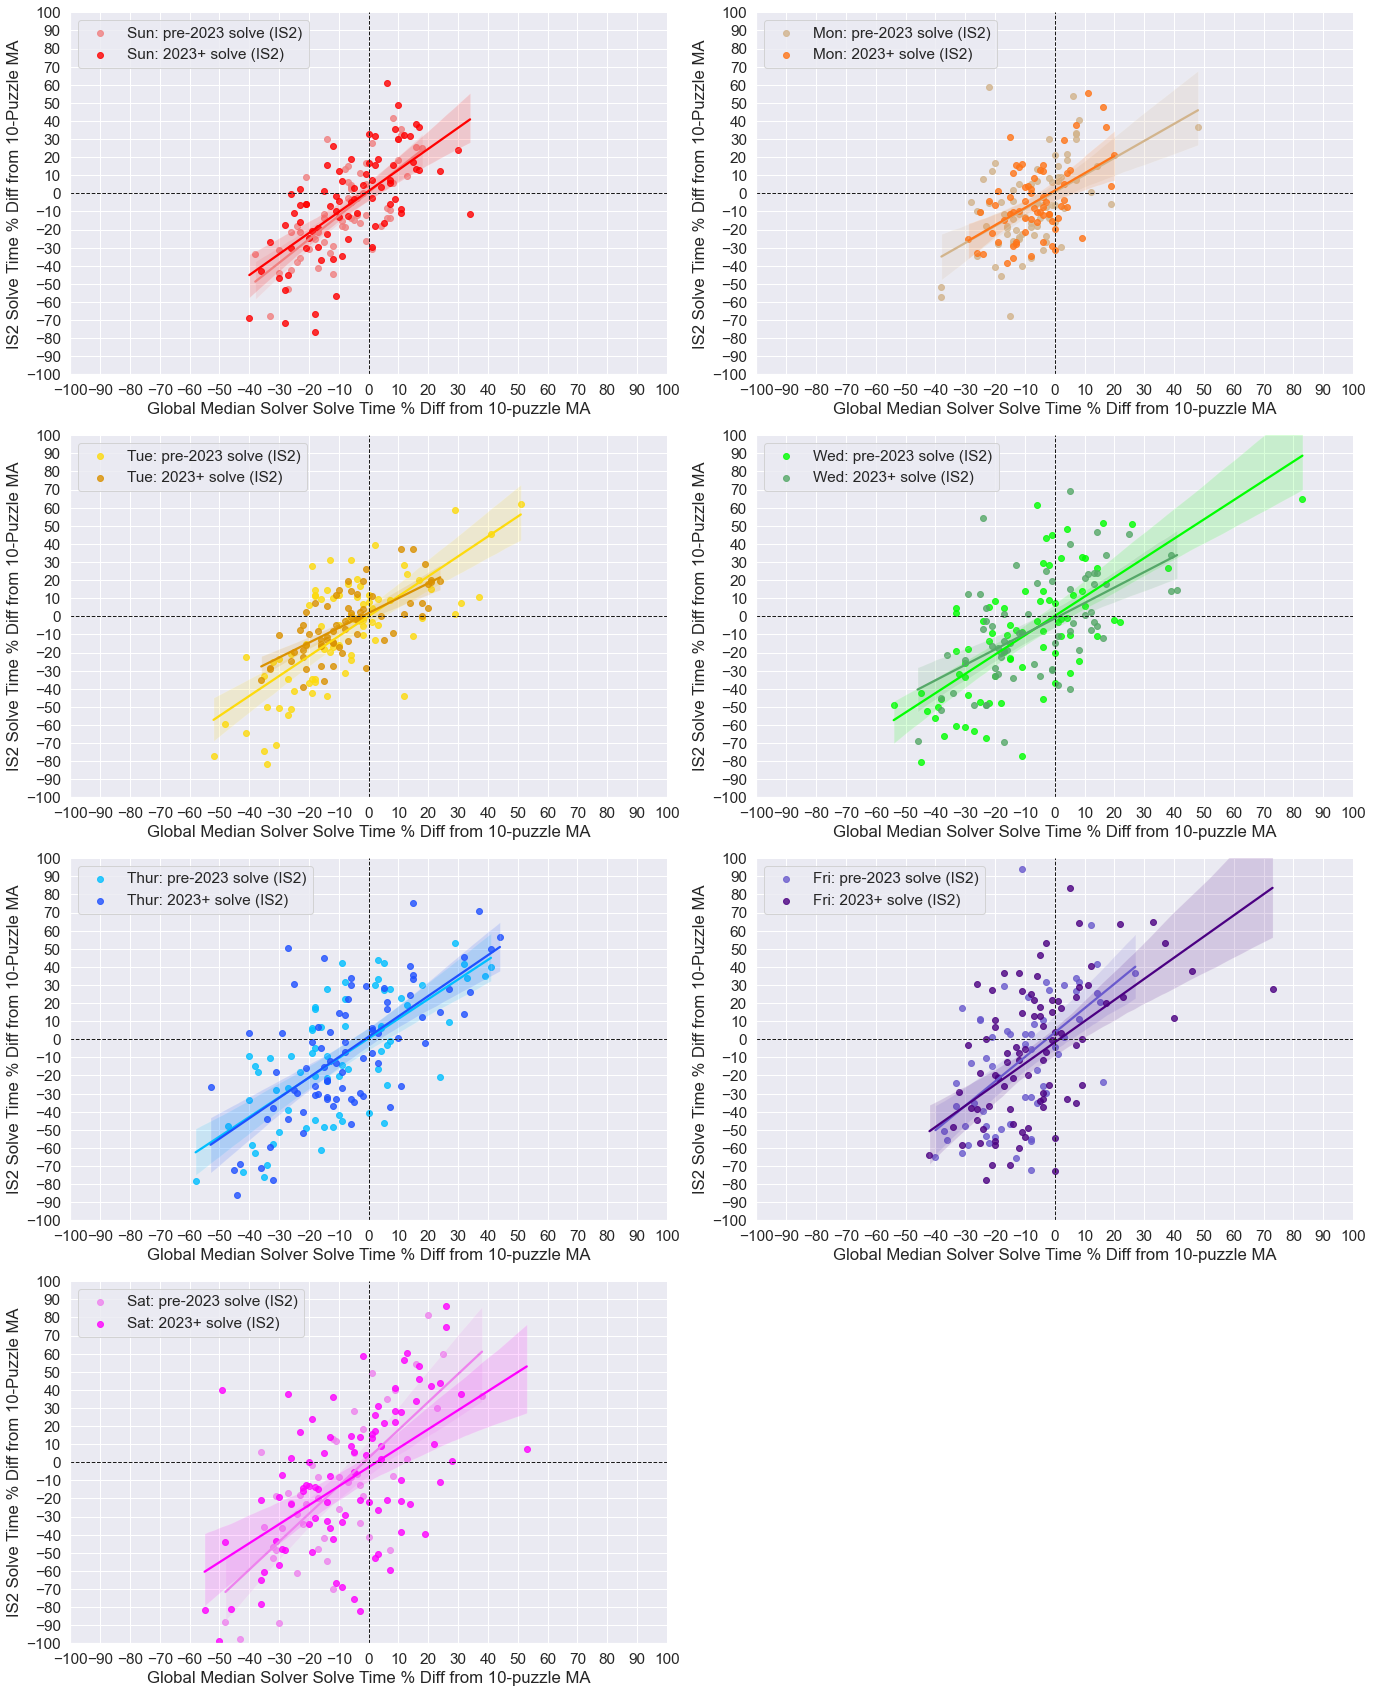

In [55]:
# Scatterplots of difference from 10-puzzle moving average for individual solver vs deviation from 10-puzzle moving average for global median solver, per puzzle day
# This isolates RELATIVE performance for the individual solver on a given puzzle vs their recent performance, and how that relative performance compares to that for the median solver

df_IS2 = df_IS2.sort_values(by=['plot_seq'], ascending = True)

sns.set(font_scale=1.4)

df_IS2['plot_seq_map'] = df_IS2['plot_seq'].map({1:'Sun: pre-2023 solve (IS2)', 2:'Sun: 2023+ solve (IS2)', 3:'Mon: pre-2023 solve (IS2)', 4:'Mon: 2023+ solve (IS2)', 5:'Tue: pre-2023 solve (IS2)', 6:'Tue: 2023+ solve (IS2)', 7:'Wed: pre-2023 solve (IS2)', 8:'Wed: 2023+ solve (IS2)', 9:'Thur: pre-2023 solve (IS2)', 10:'Thur: 2023+ solve (IS2)', 11:'Fri: pre-2023 solve (IS2)', 12:'Fri: 2023+ solve (IS2)', 13:'Sat: pre-2023 solve (IS2)', 14:'Sat: 2023+ solve (IS2)'})

#sequence = {0:'pre-2023 solve', 1:'2023 solve', 2:'pre-2023 solve', 3:'2023 solve', 4:'pre-2023 solve', 5:'2023 solve', 6:'pre-2023 solve', 7:'2023 solve', 8:'pre-2023 solve', 9:'2023 solve', 10:'pre-2023 solve', 11:'2023 solve', 12:'pre-2023 solve', 13:'2023 solve'}

p = sns.lmplot(
    data=df_IS2, x="Diff%_from_10pMA(GMS)", y="IS_Diff%_10pMA", hue="plot_seq_map", col="DOW", col_order=["Sunday", "Monday", "Tuesday","Wednesday", "Thursday", "Friday", "Saturday"], col_wrap=2, palette=["lightcoral", "red", "tan", "#FF7518", "#FDDA0D", "#da9100", "lime", "g", "deepskyblue", "#1F51FF", "slateblue", "indigo", "violet", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False
).set(title="", xlabel= "Global Median Solver Solve Time % Diff from 10-puzzle MA",
    ylabel="IS2 Solve Time % Diff from 10-Puzzle MA", xticks = [-100,-90,-80,-70,-60,-50,-40,-30,-20,-10,0,10,20,30,40,50,60,70,80,90,100], yticks = [-100,-90,-80,-70,-60,-50,-40,-30,-20,-10,0,10,20,30,40,50,60,70,80,90,100]  
)

#Adjust subplots individually
p.axes[0].set_ylim((-100,100))
p.axes[0].set_xlim((-100,100))
p.axes[1].set_ylim((-100,100))
p.axes[1].set_xlim((-100,100))
p.axes[2].set_ylim((-100,100))
p.axes[2].set_xlim((-100,100))
p.axes[3].set_ylim((-100,100))
p.axes[3].set_xlim((-100,100))
p.axes[4].set_ylim((-100,100))
p.axes[4].set_xlim((-100,100))
p.axes[5].set_ylim((-100,100))
p.axes[5].set_xlim((-100,100))
p.axes[6].set_ylim((-100,100))
p.axes[6].set_xlim((-100,100))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

p.axes[0].plot([0, 0], [-100, 100], 'k', linestyle='dashed', linewidth=1)
p.axes[0].plot([-100, 100], [0, 0], 'k', linestyle='dashed', linewidth=1)
p.axes[1].plot([0, 0], [-100, 100], 'k', linestyle='dashed', linewidth=1)
p.axes[1].plot([-100, 100], [0, 0], 'k', linestyle='dashed', linewidth=1)
p.axes[2].plot([0, 0], [-100, 100], 'k', linestyle='dashed', linewidth=1)
p.axes[2].plot([-100, 100], [0, 0], 'k', linestyle='dashed', linewidth=1)
p.axes[3].plot([0, 0], [-100, 100], 'k', linestyle='dashed', linewidth=1)
p.axes[3].plot([-100, 100], [0, 0], 'k', linestyle='dashed', linewidth=1)
p.axes[4].plot([0, 0], [-100, 100], 'k', linestyle='dashed', linewidth=1)
p.axes[4].plot([-100, 100], [0, 0], 'k', linestyle='dashed', linewidth=1)
p.axes[5].plot([0, 0], [-100, 100], 'k', linestyle='dashed', linewidth=1)
p.axes[5].plot([-100, 100], [0, 0], 'k', linestyle='dashed', linewidth=1)
p.axes[6].plot([0, 0], [-100, 100], 'k', linestyle='dashed', linewidth=1)
p.axes[6].plot([-100, 100], [0, 0], 'k', linestyle='dashed', linewidth=1)

_= p.axes[0].legend(loc = 'upper left')
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')

In [ ]:
df_IS2.info()

In [56]:
#Quadrant Analysis pre-2023 (note: very very rare exact zero difference puzzles are ignored for this calculation)

Upper_Left = len(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Sunday") & (df_IS2["IS_Diff%_10pMA"] > 0) & (df_IS2["Diff%_from_10pMA(GMS)"] < 0)])
Lower_Left = len(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Sunday") & (df_IS2["IS_Diff%_10pMA"] < 0) & (df_IS2["Diff%_from_10pMA(GMS)"] < 0)])
Upper_Right = len(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Sunday") & (df_IS2["IS_Diff%_10pMA"] > 0) & (df_IS2["Diff%_from_10pMA(GMS)"] > 0)])
Lower_Right = len(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Sunday") & (df_IS2["IS_Diff%_10pMA"] < 0) & (df_IS2["Diff%_from_10pMA(GMS)"] > 0)])
                 
Upper_Left_pct = (Upper_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Left_pct = (Lower_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Upper_Right_pct = (Upper_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Right_pct = (Lower_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
print(Lower_Left_pct, Upper_Right_pct, Upper_Left_pct, Lower_Right_pct)

Upper_Left = len(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Monday") & (df_IS2["IS_Diff%_10pMA"] > 0) & (df_IS2["Diff%_from_10pMA(GMS)"] < 0)])
Lower_Left = len(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Monday") & (df_IS2["IS_Diff%_10pMA"] < 0) & (df_IS2["Diff%_from_10pMA(GMS)"] < 0)])
Upper_Right = len(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Monday") & (df_IS2["IS_Diff%_10pMA"] > 0) & (df_IS2["Diff%_from_10pMA(GMS)"] > 0)])
Lower_Right = len(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Monday") & (df_IS2["IS_Diff%_10pMA"] < 0) & (df_IS2["Diff%_from_10pMA(GMS)"] > 0)])
                 
Upper_Left_pct = (Upper_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Left_pct = (Lower_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Upper_Right_pct = (Upper_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Right_pct = (Lower_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
print(Lower_Left_pct, Upper_Right_pct, Upper_Left_pct, Lower_Right_pct)

Upper_Left = len(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Tuesday") & (df_IS2["IS_Diff%_10pMA"] > 0) & (df_IS2["Diff%_from_10pMA(GMS)"] < 0)])
Lower_Left = len(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Tuesday") & (df_IS2["IS_Diff%_10pMA"] < 0) & (df_IS2["Diff%_from_10pMA(GMS)"] < 0)])
Upper_Right = len(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Tuesday") & (df_IS2["IS_Diff%_10pMA"] > 0) & (df_IS2["Diff%_from_10pMA(GMS)"] > 0)])
Lower_Right = len(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Tuesday") & (df_IS2["IS_Diff%_10pMA"] < 0) & (df_IS2["Diff%_from_10pMA(GMS)"] > 0)])
                 
Upper_Left_pct = (Upper_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Left_pct = (Lower_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Upper_Right_pct = (Upper_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Right_pct = (Lower_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
print(Lower_Left_pct, Upper_Right_pct, Upper_Left_pct, Lower_Right_pct)

Upper_Left = len(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Wednesday") & (df_IS2["IS_Diff%_10pMA"] > 0) & (df_IS2["Diff%_from_10pMA(GMS)"] < 0)])
Lower_Left = len(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Wednesday") & (df_IS2["IS_Diff%_10pMA"] < 0) & (df_IS2["Diff%_from_10pMA(GMS)"] < 0)])
Upper_Right = len(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Wednesday") & (df_IS2["IS_Diff%_10pMA"] > 0) & (df_IS2["Diff%_from_10pMA(GMS)"] > 0)])
Lower_Right = len(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Wednesday") & (df_IS2["IS_Diff%_10pMA"] < 0) & (df_IS2["Diff%_from_10pMA(GMS)"] > 0)])
                 
Upper_Left_pct = (Upper_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Left_pct = (Lower_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Upper_Right_pct = (Upper_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Right_pct = (Lower_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
print(Lower_Left_pct, Upper_Right_pct, Upper_Left_pct, Lower_Right_pct)

Upper_Left = len(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Thursday") & (df_IS2["IS_Diff%_10pMA"] > 0) & (df_IS2["Diff%_from_10pMA(GMS)"] < 0)])
Lower_Left = len(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Thursday") & (df_IS2["IS_Diff%_10pMA"] < 0) & (df_IS2["Diff%_from_10pMA(GMS)"] < 0)])
Upper_Right = len(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Thursday") & (df_IS2["IS_Diff%_10pMA"] > 0) & (df_IS2["Diff%_from_10pMA(GMS)"] > 0)])
Lower_Right = len(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Thursday") & (df_IS2["IS_Diff%_10pMA"] < 0) & (df_IS2["Diff%_from_10pMA(GMS)"] > 0)])
                 
Upper_Left_pct = (Upper_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Left_pct = (Lower_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Upper_Right_pct = (Upper_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Right_pct = (Lower_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
print(Lower_Left_pct, Upper_Right_pct, Upper_Left_pct, Lower_Right_pct)

Upper_Left = len(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Friday") & (df_IS2["IS_Diff%_10pMA"] > 0) & (df_IS2["Diff%_from_10pMA(GMS)"] < 0)])
Lower_Left = len(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Friday") & (df_IS2["IS_Diff%_10pMA"] < 0) & (df_IS2["Diff%_from_10pMA(GMS)"] < 0)])
Upper_Right = len(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Friday") & (df_IS2["IS_Diff%_10pMA"] > 0) & (df_IS2["Diff%_from_10pMA(GMS)"] > 0)])
Lower_Right = len(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Friday") & (df_IS2["IS_Diff%_10pMA"] < 0) & (df_IS2["Diff%_from_10pMA(GMS)"] > 0)])
                 
Upper_Left_pct = (Upper_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Left_pct = (Lower_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Upper_Right_pct = (Upper_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Right_pct = (Lower_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
print(Lower_Left_pct, Upper_Right_pct, Upper_Left_pct, Lower_Right_pct)

Upper_Left = len(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Saturday") & (df_IS2["IS_Diff%_10pMA"] > 0) & (df_IS2["Diff%_from_10pMA(GMS)"] < 0)])
Lower_Left = len(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Saturday") & (df_IS2["IS_Diff%_10pMA"] < 0) & (df_IS2["Diff%_from_10pMA(GMS)"] < 0)])
Upper_Right = len(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Saturday") & (df_IS2["IS_Diff%_10pMA"] > 0) & (df_IS2["Diff%_from_10pMA(GMS)"] > 0)])
Lower_Right = len(df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Saturday") & (df_IS2["IS_Diff%_10pMA"] < 0) & (df_IS2["Diff%_from_10pMA(GMS)"] > 0)])
                 
Upper_Left_pct = (Upper_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Left_pct = (Lower_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Upper_Right_pct = (Upper_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Right_pct = (Lower_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
print(Lower_Left_pct, Upper_Right_pct, Upper_Left_pct, Lower_Right_pct)

53.333333333333336 16.666666666666664 20.0 10.0
59.45945945945946 20.27027027027027 16.216216216216218 4.054054054054054
51.94805194805194 18.181818181818183 22.07792207792208 7.792207792207792
51.35135135135135 16.216216216216218 18.91891891891892 13.513513513513514
50.72463768115942 24.637681159420293 14.492753623188406 10.144927536231885
53.333333333333336 18.333333333333332 25.0 3.3333333333333335
64.58333333333334 18.75 12.5 4.166666666666666


In [57]:
#Quadrant Analysis 2023+ (note: very very rare exact zero difference puzzles are ignored for this calculation)

Upper_Left = len(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Sunday") & (df_IS2["IS_Diff%_10pMA"] > 0) & (df_IS2["Diff%_from_10pMA(GMS)"] < 0)])
Lower_Left = len(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Sunday") & (df_IS2["IS_Diff%_10pMA"] < 0) & (df_IS2["Diff%_from_10pMA(GMS)"] < 0)])
Upper_Right = len(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Sunday") & (df_IS2["IS_Diff%_10pMA"] > 0) & (df_IS2["Diff%_from_10pMA(GMS)"] > 0)])
Lower_Right = len(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Sunday") & (df_IS2["IS_Diff%_10pMA"] < 0) & (df_IS2["Diff%_from_10pMA(GMS)"] > 0)])
                 
Upper_Left_pct = (Upper_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Left_pct = (Lower_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Upper_Right_pct = (Upper_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Right_pct = (Lower_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
print(Lower_Left_pct, Upper_Right_pct, Upper_Left_pct, Lower_Right_pct)

Upper_Left = len(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Monday") & (df_IS2["IS_Diff%_10pMA"] > 0) & (df_IS2["Diff%_from_10pMA(GMS)"] < 0)])
Lower_Left = len(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Monday") & (df_IS2["IS_Diff%_10pMA"] < 0) & (df_IS2["Diff%_from_10pMA(GMS)"] < 0)])
Upper_Right = len(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Monday") & (df_IS2["IS_Diff%_10pMA"] > 0) & (df_IS2["Diff%_from_10pMA(GMS)"] > 0)])
Lower_Right = len(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Monday") & (df_IS2["IS_Diff%_10pMA"] < 0) & (df_IS2["Diff%_from_10pMA(GMS)"] > 0)])
                 
Upper_Left_pct = (Upper_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Left_pct = (Lower_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Upper_Right_pct = (Upper_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Right_pct = (Lower_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
print(Lower_Left_pct, Upper_Right_pct, Upper_Left_pct, Lower_Right_pct)

Upper_Left = len(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Tuesday") & (df_IS2["IS_Diff%_10pMA"] > 0) & (df_IS2["Diff%_from_10pMA(GMS)"] < 0)])
Lower_Left = len(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Tuesday") & (df_IS2["IS_Diff%_10pMA"] < 0) & (df_IS2["Diff%_from_10pMA(GMS)"] < 0)])
Upper_Right = len(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Tuesday") & (df_IS2["IS_Diff%_10pMA"] > 0) & (df_IS2["Diff%_from_10pMA(GMS)"] > 0)])
Lower_Right = len(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Tuesday") & (df_IS2["IS_Diff%_10pMA"] < 0) & (df_IS2["Diff%_from_10pMA(GMS)"] > 0)])
                 
Upper_Left_pct = (Upper_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Left_pct = (Lower_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Upper_Right_pct = (Upper_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Right_pct = (Lower_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
print(Lower_Left_pct, Upper_Right_pct, Upper_Left_pct, Lower_Right_pct)

Upper_Left = len(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Wednesday") & (df_IS2["IS_Diff%_10pMA"] > 0) & (df_IS2["Diff%_from_10pMA(GMS)"] < 0)])
Lower_Left = len(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Wednesday") & (df_IS2["IS_Diff%_10pMA"] < 0) & (df_IS2["Diff%_from_10pMA(GMS)"] < 0)])
Upper_Right = len(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Wednesday") & (df_IS2["IS_Diff%_10pMA"] > 0) & (df_IS2["Diff%_from_10pMA(GMS)"] > 0)])
Lower_Right = len(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Wednesday") & (df_IS2["IS_Diff%_10pMA"] < 0) & (df_IS2["Diff%_from_10pMA(GMS)"] > 0)])
                 
Upper_Left_pct = (Upper_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Left_pct = (Lower_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Upper_Right_pct = (Upper_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Right_pct = (Lower_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
print(Lower_Left_pct, Upper_Right_pct, Upper_Left_pct, Lower_Right_pct)

Upper_Left = len(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Thursday") & (df_IS2["IS_Diff%_10pMA"] > 0) & (df_IS2["Diff%_from_10pMA(GMS)"] < 0)])
Lower_Left = len(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Thursday") & (df_IS2["IS_Diff%_10pMA"] < 0) & (df_IS2["Diff%_from_10pMA(GMS)"] < 0)])
Upper_Right = len(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Thursday") & (df_IS2["IS_Diff%_10pMA"] > 0) & (df_IS2["Diff%_from_10pMA(GMS)"] > 0)])
Lower_Right = len(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Thursday") & (df_IS2["IS_Diff%_10pMA"] < 0) & (df_IS2["Diff%_from_10pMA(GMS)"] > 0)])
                 
Upper_Left_pct = (Upper_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Left_pct = (Lower_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Upper_Right_pct = (Upper_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Right_pct = (Lower_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
print(Lower_Left_pct, Upper_Right_pct, Upper_Left_pct, Lower_Right_pct)

Upper_Left = len(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Friday") & (df_IS2["IS_Diff%_10pMA"] > 0) & (df_IS2["Diff%_from_10pMA(GMS)"] < 0)])
Lower_Left = len(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Friday") & (df_IS2["IS_Diff%_10pMA"] < 0) & (df_IS2["Diff%_from_10pMA(GMS)"] < 0)])
Upper_Right = len(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Friday") & (df_IS2["IS_Diff%_10pMA"] > 0) & (df_IS2["Diff%_from_10pMA(GMS)"] > 0)])
Lower_Right = len(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Friday") & (df_IS2["IS_Diff%_10pMA"] < 0) & (df_IS2["Diff%_from_10pMA(GMS)"] > 0)])
                 
Upper_Left_pct = (Upper_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Left_pct = (Lower_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Upper_Right_pct = (Upper_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Right_pct = (Lower_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
print(Lower_Left_pct, Upper_Right_pct, Upper_Left_pct, Lower_Right_pct)

Upper_Left = len(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Saturday") & (df_IS2["IS_Diff%_10pMA"] > 0) & (df_IS2["Diff%_from_10pMA(GMS)"] < 0)])
Lower_Left = len(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Saturday") & (df_IS2["IS_Diff%_10pMA"] < 0) & (df_IS2["Diff%_from_10pMA(GMS)"] < 0)])
Upper_Right = len(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Saturday") & (df_IS2["IS_Diff%_10pMA"] > 0) & (df_IS2["Diff%_from_10pMA(GMS)"] > 0)])
Lower_Right = len(df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Saturday") & (df_IS2["IS_Diff%_10pMA"] < 0) & (df_IS2["Diff%_from_10pMA(GMS)"] > 0)])
                 
Upper_Left_pct = (Upper_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Left_pct = (Lower_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Upper_Right_pct = (Upper_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Right_pct = (Lower_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
print(Lower_Left_pct, Upper_Right_pct, Upper_Left_pct, Lower_Right_pct)

48.05194805194805 27.27272727272727 12.987012987012985 11.688311688311687
55.38461538461539 15.384615384615385 21.53846153846154 7.6923076923076925
55.88235294117647 20.588235294117645 20.588235294117645 2.941176470588235
45.588235294117645 25.0 14.705882352941178 14.705882352941178
50.63291139240506 26.582278481012654 16.455696202531644 6.329113924050633
51.162790697674424 20.930232558139537 23.25581395348837 4.651162790697675
43.82022471910113 28.08988764044944 15.730337078651685 12.359550561797752


In [58]:
# Correlation analysis pre-2023

Sun_2023 = df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Sunday")]
print(Sun_2023['Diff%_from_10pMA(GMS)'].corr(Sun_2023['IS_Diff%_10pMA']))

Mon_2023 = df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Monday")]
print(Mon_2023['Diff%_from_10pMA(GMS)'].corr(Mon_2023['IS_Diff%_10pMA']))

Tue_2023 = df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Tuesday")]
print(Tue_2023['Diff%_from_10pMA(GMS)'].corr(Tue_2023['IS_Diff%_10pMA']))

Wed_2023 = df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Wednesday")]
print(Wed_2023['Diff%_from_10pMA(GMS)'].corr(Wed_2023['IS_Diff%_10pMA']))

Thu_2023 = df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Thursday")]
print(Thu_2023['Diff%_from_10pMA(GMS)'].corr(Thu_2023['IS_Diff%_10pMA']))

Fri_2023 = df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Friday")]
print(Fri_2023['Diff%_from_10pMA(GMS)'].corr(Fri_2023['IS_Diff%_10pMA']))

Sat_2023 = df_IS2.loc[(df_IS2["2023+_solve"] == 0) & (df_IS2["DOW"] == "Saturday")]
print(Sat_2023['Diff%_from_10pMA(GMS)'].corr(Sat_2023['IS_Diff%_10pMA']))

0.7129146966332055
0.5091360494892394
0.7144800879549876
0.6776434228188758
0.6788287605940967
0.5629928600585511
0.7312326199593312


In [59]:
# Correlation analysis 2023+

Sun_2023 = df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Sunday")]
print(Sun_2023['Diff%_from_10pMA(GMS)'].corr(Sun_2023['IS_Diff%_10pMA']))

Mon_2023 = df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Monday")]
print(Mon_2023['Diff%_from_10pMA(GMS)'].corr(Mon_2023['IS_Diff%_10pMA']))

Tue_2023 = df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Tuesday")]
print(Tue_2023['Diff%_from_10pMA(GMS)'].corr(Tue_2023['IS_Diff%_10pMA']))

Wed_2023 = df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Wednesday")]
print(Wed_2023['Diff%_from_10pMA(GMS)'].corr(Wed_2023['IS_Diff%_10pMA']))

Thu_2023 = df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Thursday")]
print(Thu_2023['Diff%_from_10pMA(GMS)'].corr(Thu_2023['IS_Diff%_10pMA']))

Fri_2023 = df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Friday")]
print(Fri_2023['Diff%_from_10pMA(GMS)'].corr(Fri_2023['IS_Diff%_10pMA']))

Sat_2023 = df_IS2.loc[(df_IS2["2023+_solve"] == 1) & (df_IS2["DOW"] == "Saturday")]
print(Sat_2023['Diff%_from_10pMA(GMS)'].corr(Sat_2023['IS_Diff%_10pMA']))

0.6510221848587767
0.49847571741776303
0.6888190805630036
0.5611060099995866
0.6762998350465648
0.5376265039283524
0.5331335384358595


In [ ]:
#df_IS2.drop(['plot_seq', 'plot_seq_map'], axis=1, inplace=True)

### Constructor Analysis
Which constructors does individual solver 2 (IS2) struggle against? Which ones does IS2 do well against? This analysis is with respect to average deviation from day-specific 10-puzzle moving average per constructor/constructor team (aligns with what we have available for the global median solver). 

In [60]:
# Get stats for Individual Solver
constructor_avgs_IS = df_IS2.groupby(['Constructors'])['IS_Diff%_10pMA'].agg(constructor_mean_IS=(np.mean), puzzle_count_IS=(np.count_nonzero))
constructor_avgs_IS["constructor_mean_IS"] = constructor_avgs_IS["constructor_mean_IS"].round(2)

#Get stats for Global Mean Solver
constructor_avgs_GMT = df_IS2.groupby(['Constructors'])['Diff%_from_10pMA(GMS)'].agg(constructor_mean_GMS=(np.mean), puzzle_count_GMS=(np.count_nonzero))
constructor_avgs_GMT["constructor_mean_GMS"] = constructor_avgs_GMT["constructor_mean_GMS"].round(2)

#Merge Individual and Global Mean stats into single df
constructor_avgs = constructor_avgs_IS.merge(constructor_avgs_GMT, on='Constructors', how='inner')

puzzle_min_threshold = 4 #min number of puzzles in sample for constructor/constructor team to be kept in the analysis 

# Pare down to only constructor(s) with at least n puzzles for which IS1 has completed
constructor_avgs_filter = constructor_avgs.loc[constructor_avgs['puzzle_count_IS'] >= puzzle_min_threshold] 

In [ ]:
constructor_avgs_filter.head(35)

In [ ]:
constructor_avgs_filter.info()

63/506 (13%) constructor(s) had 4+ puzzles in the puzzle set completed by IS1. However, 407/1028 (40%) puzzles completed by IS2 were created by that 13% of constructor(s)! Overall, repeat constructors accounted for 713/1028 (69%) puzzles in those completed by IS2. 

In [ ]:
constructor_avgs_filter.to_csv('../data/constructor_avgs_filter.csv', index=True)

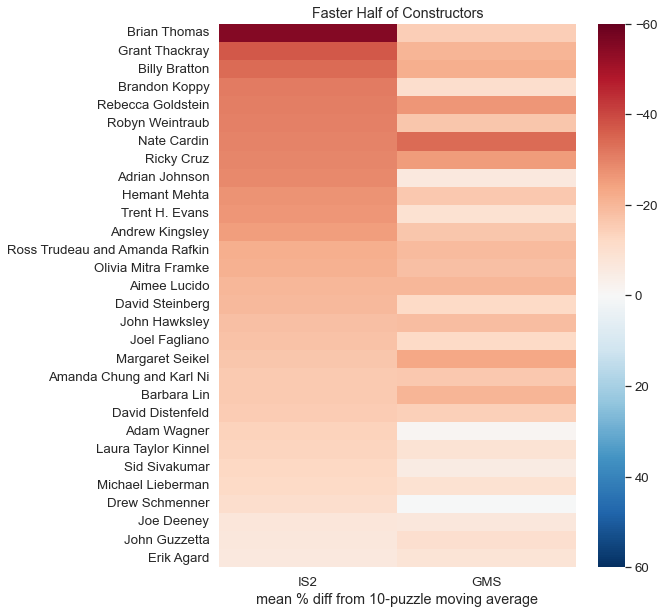

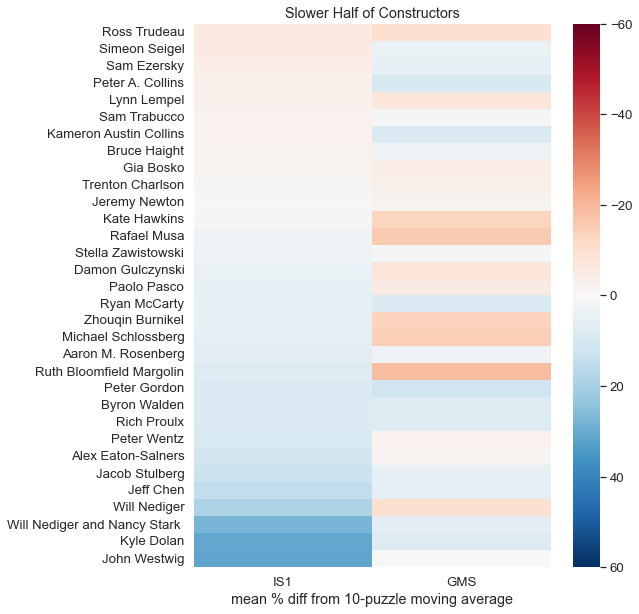

In [61]:
# Construct Heat Map sorted by fastest constructor relative to Individual solver 10 puzzle moving average to slowest

#Remove puzzle ns columns and sort for heatmapping
avgs = constructor_avgs_filter[["constructor_mean_IS", "constructor_mean_GMS"]]
avgs = avgs.sort_values(by=['constructor_mean_IS'], ascending = True)

first_half_end = int((len(avgs)/2)-1)
avgs_end = int(len(avgs))
first_half = avgs[0:first_half_end]
second_half = avgs[(first_half_end+1):avgs_end]

first_half = first_half.sort_values(by=['constructor_mean_IS'], ascending = True)
plt.figure(figsize=(8,10))
sns.set(font_scale=1.2)
ax = sns.heatmap(first_half, xticklabels=['IS2', 'GMS'], cmap="RdBu", vmin=-60, vmax=60, yticklabels=True)
plt.gcf().axes[1].invert_yaxis() #flip color bar to show fastest at the top
plt.xlabel('mean % diff from 10-puzzle moving average')
plt.ylabel('')
plt.title("Faster Half of Constructors")
plt.show()

second_half = second_half.sort_values(by=['constructor_mean_IS'], ascending = True)
plt.figure(figsize=(8,10))
sns.set(font_scale=1.2)
ax2 = sns.heatmap(second_half, xticklabels=['IS1', 'GMS'], cmap="RdBu", vmin=-60, vmax=60, yticklabels=True)
plt.gcf().axes[1].invert_yaxis() #flip color bar to show fastest at the top
plt.xlabel('mean % diff from 10-puzzle moving average')
plt.ylabel('')
plt.title("Slower Half of Constructors")
plt.show()

In [62]:
print(constructor_avgs_filter[["constructor_mean_IS"]].agg(['min', 'max']))
print(constructor_avgs_filter[["constructor_mean_GMS"]].agg(['min', 'max']))

     constructor_mean_IS
min               -55.06
max                31.42
     constructor_mean_GMS
min                -34.00
max                 11.89


In [63]:
# Calculate past performance (using COMP date to sort) for IS2 against a given constructor (% difference from 10-puzzle moving average) for each puzzle in sample
# Individual Solver mean past performance versus a given constructor(s), per puzzle. 
# This is calculated off of deviation from 10-puzzle moving average, so that it can be collapsed across puzzle days
# Getting the count as well will allow filtering by past number of puzzles for a second version of the figure

df_IS2 = df_IS2.sort_values(by=['Constructors','Comp_Date'], ascending = False)

df_IS2 = df_IS2.iloc[::-1]
df_IS2['IS_per_constr_avg_past_diff_from_10pMA'] = df_IS2.groupby(['Constructors'])['IS_Diff%_10pMA'].transform(lambda x: x.rolling(window=100, min_periods = 1).mean().round(2).shift(1))
df_IS2['IS_per_constr_past_diff_from_10pMA_ct'] = df_IS2.groupby(['Constructors'])['IS_Diff%_10pMA'].transform(lambda x: x.rolling(window=100, min_periods = 1).count().shift(1))
df_IS2 = df_IS2.iloc[::-1]

# col = df_IS1.pop('GMS_per_constr_avg_past_diff_from_10pMA')
# df_IS1.insert(17, col.name, col)

In [ ]:
# Checkpoint
df_IS1.to_csv('../data/df_IS2.csv', index=False)

In [ ]:
# #Plot IS_per_constr_avg_past_diff_from_10pMA vs diff%_from_10pMA(IS) for all puzzles 
# # Idea here is to get correlation between past performance vs a given constructor and performance on a given puzzle, in a way that is normalized for both puzzle day difficulty and recent past performance

# sns.set(font_scale=1.4)

# p = sns.lmplot(
#     data=df_IS1, x="IS_per_constr_avg_past_diff_from_10pMA", y="IS_Diff%_10pMA",
#     height=10, aspect=1, legend=False, scatter_kws = {"color": "black", "alpha": 0.7}, line_kws = {"color": "black"}
# ).set(title="All Puzzles by Constructor(s) With >=1 Prior Puzzle", xlabel= "IS1 Prior Performance vs Constructor(s) (Mean % Diff from 10pMA)",
#     ylabel="IS1 Next Individual Puzzle Performance vs Constructor(s) (% Diff from 10pMA)", xticks =[-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70, 80], yticks =[-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70, 80]
# )

# # #Adjust subplots individually
# _= p.set(ylim=(-80, 80))
# _= p.set(xlim=(-80, 80))

In [ ]:
# Correlation Calculation (Pearson r)
# print(df_IS1['IS_per_constr_avg_past_diff_from_10pMA'].corr(df_IS1['IS_Diff%_10pMA']))

In [64]:
# Create df that includes only puzzles with Constructor(s) where there are >=3 prior puzzles by them
df_IS2_filter = df_IS2.loc[(df_IS2["IS_per_constr_past_diff_from_10pMA_ct"] >= 3)]
df_IS2_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209 entries, 1817 to 321
Data columns (total 49 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   P_Date                                  209 non-null    datetime64[ns]
 1   P_Date_str                              209 non-null    object        
 2   P_Yr                                    209 non-null    period[A-DEC] 
 3   2023+_puzzle                            209 non-null    float64       
 4   DOW                                     209 non-null    object        
 5   DOW_num                                 209 non-null    float64       
 6   GMST(m)                                 209 non-null    float64       
 7   GMST(m)_10p_MA                          209 non-null    float64       
 8   Diff%_from_10pMA(GMS)                   209 non-null    int64         
 9   Comp_Date                               209 non-nul

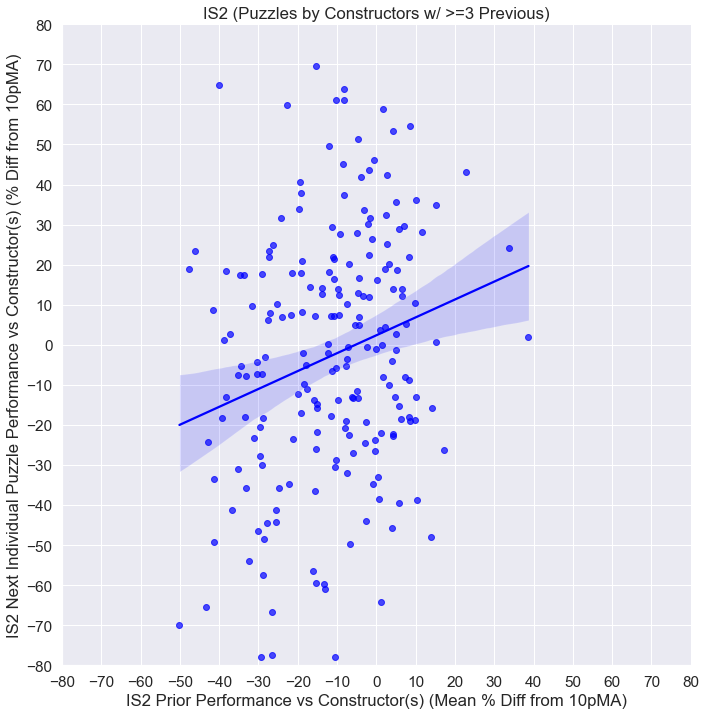

In [65]:
#Plot IS_per_constr_avg_past_diff_from_10pMA vs diff%_from_10pMA(IS) for all puzzles whose constructor had at least 3 prior puzzles in the sample
# Idea here is to get correlation between past performance vs a given constructor and performance on a given puzzle, in a way that is normalized for both puzzle day difficulty and recent past performance

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=df_IS2_filter, x="IS_per_constr_avg_past_diff_from_10pMA", y="IS_Diff%_10pMA",
    height=10, aspect=1, legend=False, scatter_kws = {"color": "blue", "alpha": 0.7}, line_kws = {"color": "blue"}
).set(title="IS2 (Puzzles by Constructors w/ >=3 Previous)", xlabel= "IS2 Prior Performance vs Constructor(s) (Mean % Diff from 10pMA)",
    ylabel="IS2 Next Individual Puzzle Performance vs Constructor(s) (% Diff from 10pMA)", xticks =[-80, -70, -60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70, 80], yticks =[-80, -70, -60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70, 80]
)

# #Adjust subplots individually
_= p.set(ylim=(-80, 80))
_= p.set(xlim=(-80, 80))

In [66]:
# Correlation Calculation (Pearson r)
print(df_IS2_filter['IS_per_constr_avg_past_diff_from_10pMA'].corr(df_IS2_filter['IS_Diff%_10pMA']))

0.22281345723704182


In [67]:
# Calculate GMS past performance (sorting by ISSUE DATE, unlike for IS2) against a given constructor (% difference from 10-puzzle moving average) for each puzzle in sample
# Global Mean Solver mean past performance versus a given constructor(s), per puzzle. 
# This is calculated off of deviation from 10-puzzle moving average, so that it can be collapsed across puzzle days
# Getting the count as well will allow filtering by past number of puzzles for a second version of the figure

df_IS2 = df_IS2.sort_values(by=['Constructors','P_Date'], ascending = False)

df_IS2 = df_IS2.iloc[::-1]
df_IS2['GMS_per_constr_avg_past_diff_from_10pMA'] = df_IS2.groupby(['Constructors'])['Diff%_from_10pMA(GMS)'].transform(lambda x: x.rolling(window=100, min_periods = 1).mean().round(2).shift(1))
df_IS2['GMS_per_constr_past_diff_from_10pMA_ct'] = df_IS2.groupby(['Constructors'])['Diff%_from_10pMA(GMS)'].transform(lambda x: x.rolling(window=100, min_periods = 1).count().shift(1))
df_IS2 = df_IS2.iloc[::-1]

# col = df_IS1.pop('GMS_per_constr_avg_past_diff_from_10pMA')
# df_IS1.insert(17, col.name, col)

In [68]:
# Create df that includes only puzzles with Constructor(s) where there are >=3 prior puzzles by them
df_IS2_GMS_filter = df_IS2.loc[(df_IS2["GMS_per_constr_past_diff_from_10pMA_ct"] >= 3)]
df_IS2_GMS_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 218 entries, 714 to 189
Data columns (total 51 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   P_Date                                   218 non-null    datetime64[ns]
 1   P_Date_str                               218 non-null    object        
 2   P_Yr                                     218 non-null    period[A-DEC] 
 3   2023+_puzzle                             218 non-null    float64       
 4   DOW                                      218 non-null    object        
 5   DOW_num                                  218 non-null    float64       
 6   GMST(m)                                  218 non-null    float64       
 7   GMST(m)_10p_MA                           218 non-null    float64       
 8   Diff%_from_10pMA(GMS)                    218 non-null    int64         
 9   Comp_Date                                

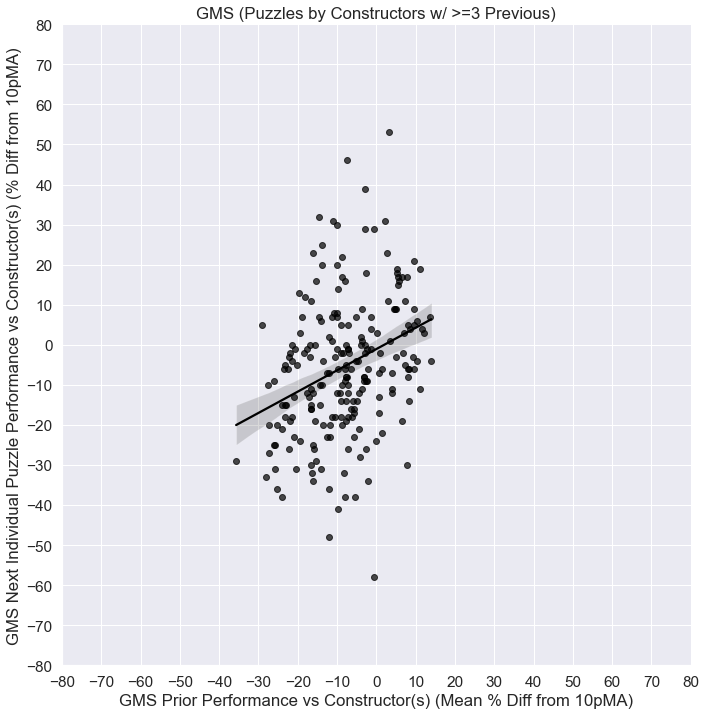

In [69]:
#Plot GMS_per_constr_avg_past_diff_from_10pMA vs diff%_from_10pMA(GMS) for all puzzles whose constructor had at least 3 prior puzzles in the sample
# Idea here is to get correlation between past performance vs a given constructor and performance on a given puzzle, in a way that is normalized for both puzzle day difficulty and recent past performance

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=df_IS2_GMS_filter, x="GMS_per_constr_avg_past_diff_from_10pMA", y="Diff%_from_10pMA(GMS)",
    height=10, aspect=1, legend=False, scatter_kws = {"color": "black", "alpha": 0.7}, line_kws = {"color": "black"}
).set(title="GMS (Puzzles by Constructors w/ >=3 Previous)", xlabel= "GMS Prior Performance vs Constructor(s) (Mean % Diff from 10pMA)",
    ylabel="GMS Next Individual Puzzle Performance vs Constructor(s) (% Diff from 10pMA)", xticks =[-80, -70, -60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70, 80], yticks =[-80, -70, -60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70, 80]
)

# #Adjust subplots individually
_= p.set(ylim=(-80, 80))
_= p.set(xlim=(-80, 80))

In [70]:
# Correlation Calculation (Pearson r)
print(df_IS2_GMS_filter['GMS_per_constr_avg_past_diff_from_10pMA'].corr(df_IS2_filter['Diff%_from_10pMA(GMS)']))

0.3088053351142191


### Completion Time of Day Analysis

In [71]:
IS2_df2 = df_IS2.copy()

In [72]:
#Creates a column where Individual Solver completion timestamps are binned to the hour in 24-hour cycle
IS2_df2['Comp_Hr'] = IS2_df2['Comp_Date'].dt.hour
IS2_df2['Comp_Hr'].value_counts()
IS2_df2['Comp_Hr']= IS2_df2['Comp_Hr'].astype('int64')
IS2_df2 = IS2_df2.sort_values('Comp_Hr')

In [ ]:
IS2_df2.info()

In [73]:
col = IS2_df2.pop('Comp_Hr')
IS2_df2.insert(9, col.name, col)

In [74]:
# Construct numerical categories in desired plotting sequence for combinations of puzzle day and pre-2023 or 2023+

IS2_df2.loc[(IS2_df2["DOW"] == "Sunday") & (IS2_df2["2023+_solve"] == 0) , "plot_seq"] = 1 
IS2_df2.loc[(IS2_df2["DOW"] == "Sunday") & (IS2_df2["2023+_solve"] == 1) , "plot_seq"] = 2
IS2_df2.loc[(IS2_df2["DOW"] == "Monday") & (IS2_df2["2023+_solve"] == 0) , "plot_seq"] = 3 
IS2_df2.loc[(IS2_df2["DOW"] == "Monday") & (IS2_df2["2023+_solve"] == 1) , "plot_seq"] = 4
IS2_df2.loc[(IS2_df2["DOW"] == "Tuesday") & (IS2_df2["2023+_solve"] == 0) , "plot_seq"] = 5 
IS2_df2.loc[(IS2_df2["DOW"] == "Tuesday") & (IS2_df2["2023+_solve"] == 1) , "plot_seq"] = 6
IS2_df2.loc[(IS2_df2["DOW"] == "Wednesday") & (IS2_df2["2023+_solve"] == 0) , "plot_seq"] = 7 
IS2_df2.loc[(IS2_df2["DOW"] == "Wednesday") & (IS2_df2["2023+_solve"] == 1) , "plot_seq"] = 8
IS2_df2.loc[(IS2_df2["DOW"] == "Thursday") & (IS2_df2["2023+_solve"] == 0) , "plot_seq"] = 9 
IS2_df2.loc[(IS2_df2["DOW"] == "Thursday") & (IS2_df2["2023+_solve"] == 1) , "plot_seq"] = 10
IS2_df2.loc[(IS2_df2["DOW"] == "Friday") & (IS2_df2["2023+_solve"] == 0) , "plot_seq"] = 11 
IS2_df2.loc[(IS2_df2["DOW"] == "Friday") & (IS2_df2["2023+_solve"] == 1) , "plot_seq"] = 12
IS2_df2.loc[(IS2_df2["DOW"] == "Saturday") & (IS2_df2["2023+_solve"] == 0) , "plot_seq"] = 13 
IS2_df2.loc[(IS2_df2["DOW"] == "Saturday") & (IS2_df2["2023+_solve"] == 1) , "plot_seq"] = 14

In [75]:
# For subplot collapsed across puzzle days for puzzle completions by hour of day, make a copy of all data, label it '0' and concatenate with
#main df

IS2_df2_copy = IS2_df2.copy()
IS2_df2_copy["DOW_num"] = 0

IS2_df2a = pd.concat([IS2_df2, IS2_df2_copy],ignore_index=True)

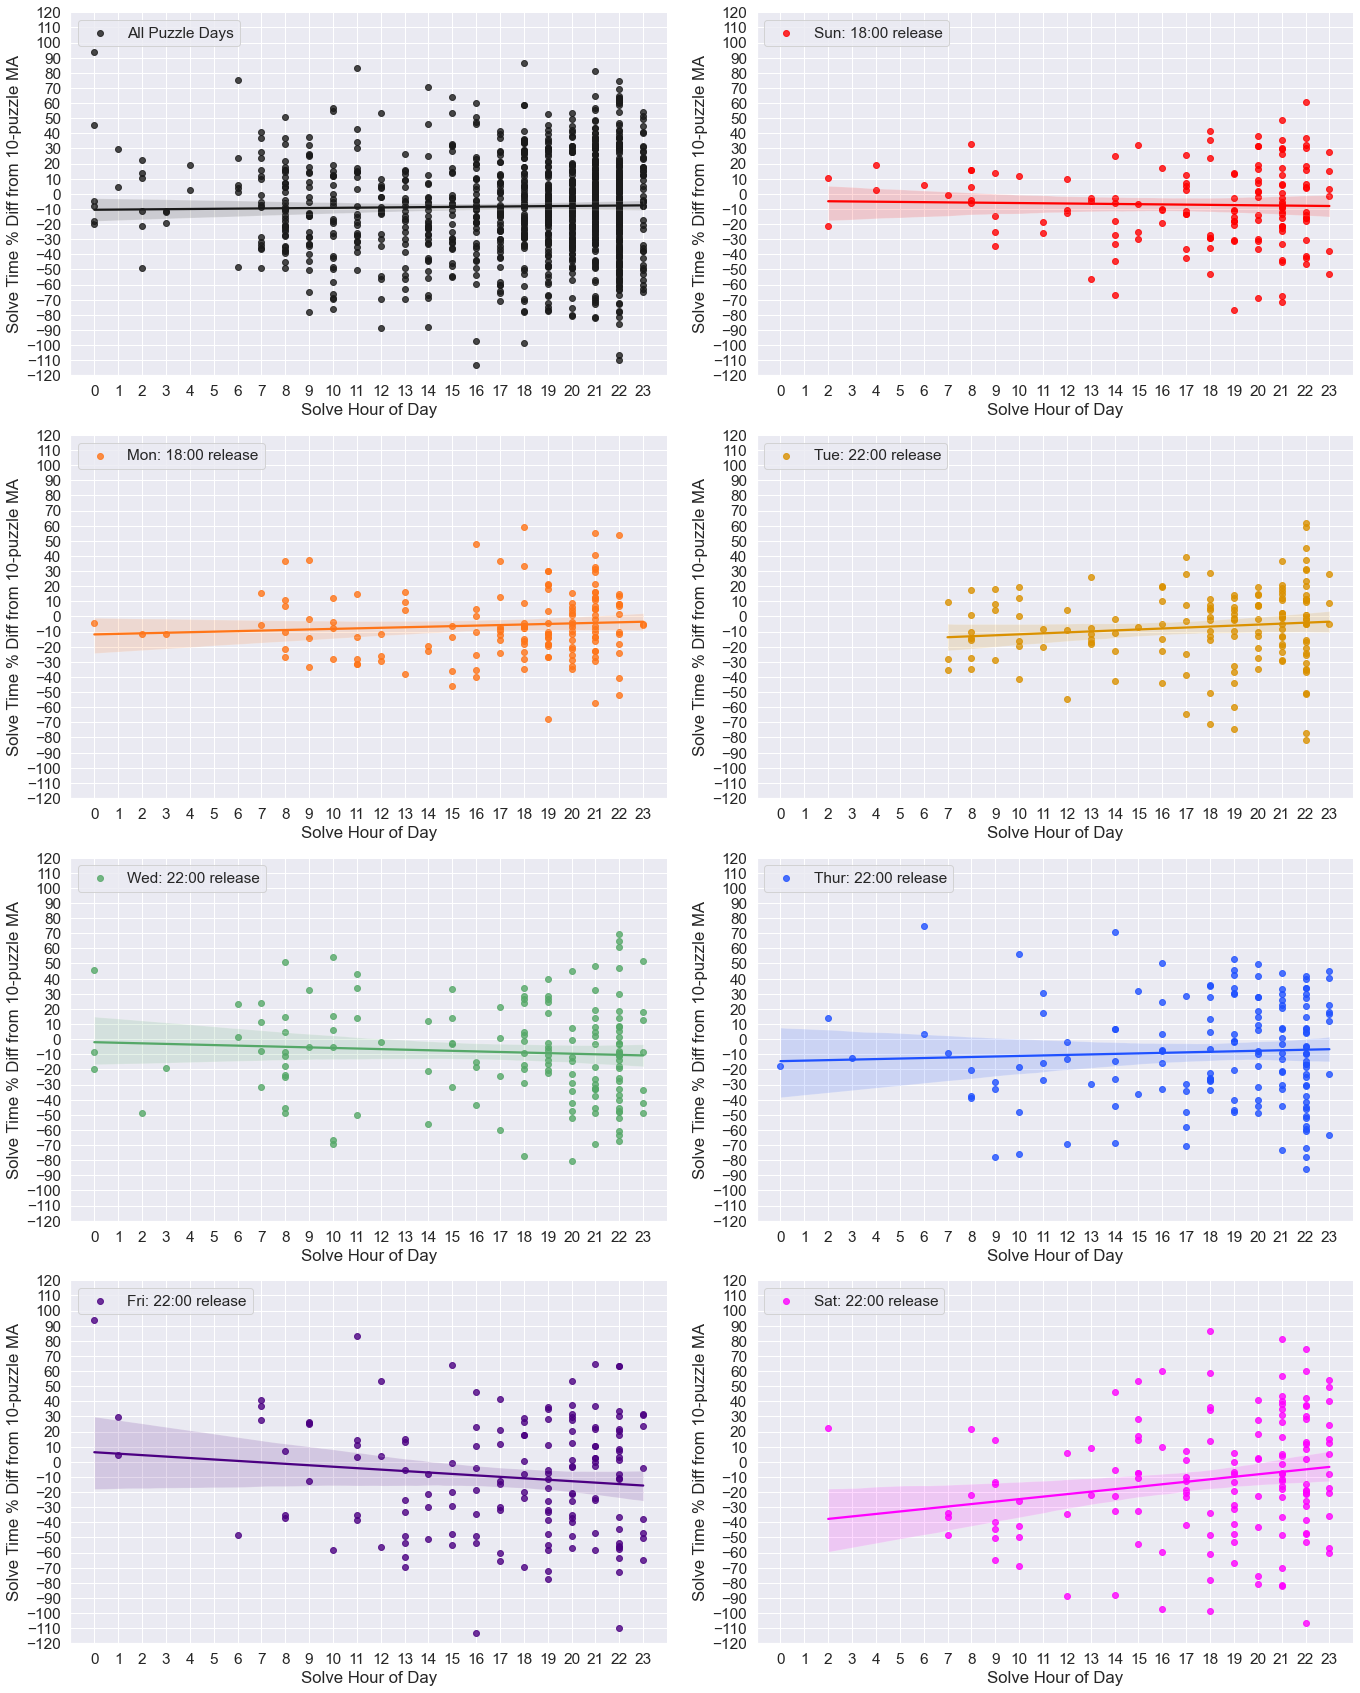

In [76]:
# Individual Solver 2 (IS2) Puzzle Completions by Solve Hour

IS2_df2a = IS2_df2a.sort_values(by=['DOW_num'], ascending = True)

IS2_df2a['plot_seq_map'] = IS2_df2a['DOW_num'].map({0: 'All Puzzle Days', 1:'Sun: 18:00 release', 2:'Mon: 18:00 release', 3:'Tue: 22:00 release', 4:'Wed: 22:00 release', 5: 'Thur: 22:00 release', 6:'Fri: 22:00 release', 7:'Sat: 22:00 release'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS2_df2a, x="Comp_Hr", y="IS_Diff%_10pMA", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], col_wrap=2, palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False
).set(title="", xlabel= "Solve Hour of Day",
    ylabel="Solve Time % Diff from 10-puzzle MA", yticks = [-120,-110,-100,-90,-80,-70,-60,-50,-40,-30,-20,-10,0,10,20,30,40,50,60,70,80,90,100,110,120], xticks = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]  
)

#Adjust subplots individually
p.axes[0].set_ylim((-120,120))
p.axes[0].set_xlim((-1,24))
p.axes[1].set_ylim((-120,120))
p.axes[1].set_xlim((-1,24))
p.axes[2].set_ylim((-120,120))
p.axes[2].set_xlim((-1,24))
p.axes[3].set_ylim((-120,120))
p.axes[3].set_xlim((-1,24))
p.axes[4].set_ylim((-120,120))
p.axes[4].set_xlim((-1,24))
p.axes[5].set_ylim((-120,120))
p.axes[5].set_xlim((-1,24))
p.axes[6].set_ylim((-120,120))
p.axes[6].set_xlim((-1,24))
p.axes[7].set_ylim((-120,120))
p.axes[7].set_xlim((-1,24))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

IS2_df2a.drop(['plot_seq_map'], axis=1, inplace=True)

In [77]:
print(len(IS2_df2.loc[(IS2_df2["Comp_Hr"] >= 18)]))
print(len(IS2_df2.loc[(IS2_df2["Comp_Hr"] >= 21)]))
print(len(IS2_df2.loc[(IS2_df2["Comp_Hr"] >= 0)]))

print(len(IS2_df2.loc[(IS2_df2["Comp_Hr"] >= 7) & (IS2_df2["Comp_Hr"] <= 10)]))

666
383
1028
110


In [78]:
print(len(IS2_df2.loc[(IS2_df2["Comp_Hr"] >= 0) & (IS2_df2["Comp_Hr"] <= 8)]))
print(len(IS2_df2.loc[(IS2_df2["Comp_Hr"] >= 0) & (IS2_df2["Comp_Hr"] <= 8) & (IS2_df2["IS_Diff%_10pMA"] <= -50)]))

80
0


In [79]:
print(len(IS2_df2.loc[(IS2_df2["Comp_Hr"] >= 20) & (IS2_df2["Comp_Hr"] <= 24)]))
print(len(IS2_df2.loc[(IS2_df2["Comp_Hr"] >= 20) & (IS2_df2["Comp_Hr"] <= 23) & (IS2_df2["IS_Diff%_10pMA"] <= -50)]))

485
47


### Puzzle and Answer-Features Correlation to Solve Times

In [80]:
# Make a deep copy of individual solver df
IS2_df3 = IS2_df2.copy()

In [ ]:
IS2_df3.info()

Create a few new features for day-specific weighted solver past performance to use as frame of reference for the puzzle and answer-specific correlations

In [81]:
#IS_pds_l10_dw
#Provides decay-weighted(dw), puzzle day-specific (pds) mean solve time performance for the individual solver over the previous 10 puzzles

IS2_df3 = IS2_df3.sort_values(by=['DOW', 'Comp_Date'], ascending = False)

w = [10,9,8,7,6,5,4,3,2,1] #weight assigned to puzzle

IS2_df3["IS_pds_l10_dw_1"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-1)*w[0]
IS2_df3["IS_pds_l10_dw_2"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-2)*w[1]
IS2_df3["IS_pds_l10_dw_3"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-3)*w[2]
IS2_df3["IS_pds_l10_dw_4"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-4)*w[3]
IS2_df3["IS_pds_l10_dw_5"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-5)*w[4]
IS2_df3["IS_pds_l10_dw_6"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-6)*w[5]
IS2_df3["IS_pds_l10_dw_7"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-7)*w[6]
IS2_df3["IS_pds_l10_dw_8"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-8)*w[7]
IS2_df3["IS_pds_l10_dw_9"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-9)*w[8]
IS2_df3["IS_pds_l10_dw_10"] = IS2_df3.groupby(['DOW'])['IST(m)'].shift(-10)*w[9]

IS2_df3["IS_pds_l10_dw_1_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-1)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-1))*w[0]
IS2_df3["IS_pds_l10_dw_2_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-2)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-2))*w[1]
IS2_df3["IS_pds_l10_dw_3_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-3)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-3))*w[2]
IS2_df3["IS_pds_l10_dw_4_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-4)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-4))*w[3]
IS2_df3["IS_pds_l10_dw_5_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-5)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-5))*w[4]
IS2_df3["IS_pds_l10_dw_6_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-6)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-6))*w[5]
IS2_df3["IS_pds_l10_dw_7_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-7)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-7))*w[6]
IS2_df3["IS_pds_l10_dw_8_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-8)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-8))*w[7]
IS2_df3["IS_pds_l10_dw_9_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-9)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-9))*w[8]
IS2_df3["IS_pds_l10_dw_10_ct"] = (IS2_df3.groupby(['DOW'])['IST(m)'].shift(-10)/IS2_df3.groupby(['DOW'])['IST(m)'].shift(-10))*w[9]

IS2_df3["IS_pds_l10_ws"] = IS2_df3[["IS_pds_l10_dw_1", "IS_pds_l10_dw_2", "IS_pds_l10_dw_3", "IS_pds_l10_dw_4", "IS_pds_l10_dw_5", "IS_pds_l10_dw_6", "IS_pds_l10_dw_7", "IS_pds_l10_dw_8", "IS_pds_l10_dw_9", "IS_pds_l10_dw_10"]].sum(axis=1)
IS2_df3["IS_pds_l10_ws_ct"] = IS2_df3[["IS_pds_l10_dw_1_ct", "IS_pds_l10_dw_2_ct", "IS_pds_l10_dw_3_ct", "IS_pds_l10_dw_4_ct", "IS_pds_l10_dw_5_ct", "IS_pds_l10_dw_6_ct", "IS_pds_l10_dw_7_ct", "IS_pds_l10_dw_8_ct", "IS_pds_l10_dw_9_ct", "IS_pds_l10_dw_10_ct"]].sum(axis=1)
IS2_df3["IS_pds_l10_dw"] = IS2_df3["IS_pds_l10_ws"]/IS2_df3["IS_pds_l10_ws_ct"]

# Deleting transient columns
IS2_df3 = IS2_df3.drop(["IS_pds_l10_dw_1", "IS_pds_l10_dw_2", "IS_pds_l10_dw_3", "IS_pds_l10_dw_4", "IS_pds_l10_dw_5", "IS_pds_l10_dw_6", "IS_pds_l10_dw_7", "IS_pds_l10_dw_8", "IS_pds_l10_dw_9", "IS_pds_l10_dw_10", "IS_pds_l10_dw_1_ct", "IS_pds_l10_dw_2_ct", "IS_pds_l10_dw_3_ct", "IS_pds_l10_dw_4_ct", "IS_pds_l10_dw_5_ct", "IS_pds_l10_dw_6_ct", "IS_pds_l10_dw_7_ct", "IS_pds_l10_dw_8_ct", "IS_pds_l10_dw_9_ct", "IS_pds_l10_dw_10_ct", "IS_pds_l10_ws", "IS_pds_l10_ws_ct"], axis = 1)

In [82]:
#GMS_pds_l10_dw
#Provides decay-weighted(dw), puzzle day-specific (pds) mean solve time performance for the GMS over the previous 10 puzzles
# Will use in comparison to IS past performance correlation to solve times (Figure 21 in Github summary)
# Note that the sort is by puzzle issue date for the GMS, as completion date is not avaiable (sequence is assumed to be that of issue date)

IS2_df3 = IS2_df3.sort_values(by=['DOW', 'P_Date'], ascending = False)

w = [10,9,8,7,6,5,4,3,2,1] #weight assigned to puzzle

IS2_df3["GMS_pds_l10_dw_1"] = IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-1)*w[0]
IS2_df3["GMS_pds_l10_dw_2"] = IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-2)*w[1]
IS2_df3["GMS_pds_l10_dw_3"] = IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-3)*w[2]
IS2_df3["GMS_pds_l10_dw_4"] = IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-4)*w[3]
IS2_df3["GMS_pds_l10_dw_5"] = IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-5)*w[4]
IS2_df3["GMS_pds_l10_dw_6"] = IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-6)*w[5]
IS2_df3["GMS_pds_l10_dw_7"] = IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-7)*w[6]
IS2_df3["GMS_pds_l10_dw_8"] = IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-8)*w[7]
IS2_df3["GMS_pds_l10_dw_9"] = IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-9)*w[8]
IS2_df3["GMS_pds_l10_dw_10"] = IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-10)*w[9]

IS2_df3["GMS_pds_l10_dw_1_ct"] = (IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-1)/IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-1))*w[0]
IS2_df3["GMS_pds_l10_dw_2_ct"] = (IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-2)/IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-2))*w[1]
IS2_df3["GMS_pds_l10_dw_3_ct"] = (IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-3)/IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-3))*w[2]
IS2_df3["GMS_pds_l10_dw_4_ct"] = (IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-4)/IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-4))*w[3]
IS2_df3["GMS_pds_l10_dw_5_ct"] = (IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-5)/IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-5))*w[4]
IS2_df3["GMS_pds_l10_dw_6_ct"] = (IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-6)/IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-6))*w[5]
IS2_df3["GMS_pds_l10_dw_7_ct"] = (IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-7)/IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-7))*w[6]
IS2_df3["GMS_pds_l10_dw_8_ct"] = (IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-8)/IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-8))*w[7]
IS2_df3["GMS_pds_l10_dw_9_ct"] = (IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-9)/IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-9))*w[8]
IS2_df3["GMS_pds_l10_dw_10_ct"] = (IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-10)/IS2_df3.groupby(['DOW'])['GMST(m)'].shift(-10))*w[9]

IS2_df3["GMS_pds_l10_ws"] = IS2_df3[["GMS_pds_l10_dw_1", "GMS_pds_l10_dw_2", "GMS_pds_l10_dw_3", "GMS_pds_l10_dw_4", "GMS_pds_l10_dw_5", "GMS_pds_l10_dw_6", "GMS_pds_l10_dw_7", "GMS_pds_l10_dw_8", "GMS_pds_l10_dw_9", "GMS_pds_l10_dw_10"]].sum(axis=1)
IS2_df3["GMS_pds_l10_ws_ct"] = IS2_df3[["GMS_pds_l10_dw_1_ct", "GMS_pds_l10_dw_2_ct", "GMS_pds_l10_dw_3_ct", "GMS_pds_l10_dw_4_ct", "GMS_pds_l10_dw_5_ct", "GMS_pds_l10_dw_6_ct", "GMS_pds_l10_dw_7_ct", "GMS_pds_l10_dw_8_ct", "GMS_pds_l10_dw_9_ct", "GMS_pds_l10_dw_10_ct"]].sum(axis=1)
IS2_df3["GMS_pds_l10_dw"] = IS2_df3["GMS_pds_l10_ws"]/IS2_df3["GMS_pds_l10_ws_ct"]

# Deleting transient columns
IS2_df3 = IS2_df3.drop(["GMS_pds_l10_dw_1", "GMS_pds_l10_dw_2", "GMS_pds_l10_dw_3", "GMS_pds_l10_dw_4", "GMS_pds_l10_dw_5", "GMS_pds_l10_dw_6", "GMS_pds_l10_dw_7", "GMS_pds_l10_dw_8", "GMS_pds_l10_dw_9", "GMS_pds_l10_dw_10", "GMS_pds_l10_dw_1_ct", "GMS_pds_l10_dw_2_ct", "GMS_pds_l10_dw_3_ct", "GMS_pds_l10_dw_4_ct", "GMS_pds_l10_dw_5_ct", "GMS_pds_l10_dw_6_ct", "GMS_pds_l10_dw_7_ct", "GMS_pds_l10_dw_8_ct", "GMS_pds_l10_dw_9_ct", "GMS_pds_l10_dw_10_ct", "GMS_pds_l10_ws", "GMS_pds_l10_ws_ct"], axis = 1)

In [ ]:
IS2_df3.info()

In [83]:
# Move new columns to logical places in dataframe

col = IS2_df3.pop('GMS_pds_l10_dw')
IS2_df3.insert(9, col.name, col)

col = IS2_df3.pop('IS_pds_l10_dw')
IS2_df3.insert(20, col.name, col)

col = IS2_df3.pop('IS_per_constr_avg_past_diff_from_10pMA')
IS2_df3.insert(21, col.name, col)

col = IS2_df3.pop('IS_per_constr_past_diff_from_10pMA_ct')
IS2_df3.insert(22, col.name, col)

#And one puzzle feature to a more logical place
col = IS2_df3.pop('Open_Squares')
IS2_df3.insert(24, col.name, col)

In [ ]:
IS2_df3.to_csv('../data/IS2_df3.csv', index=False)

### Correlation of Puzzle and Answer Feature Parameters to Individual IS1 Puzzle Solve Times 

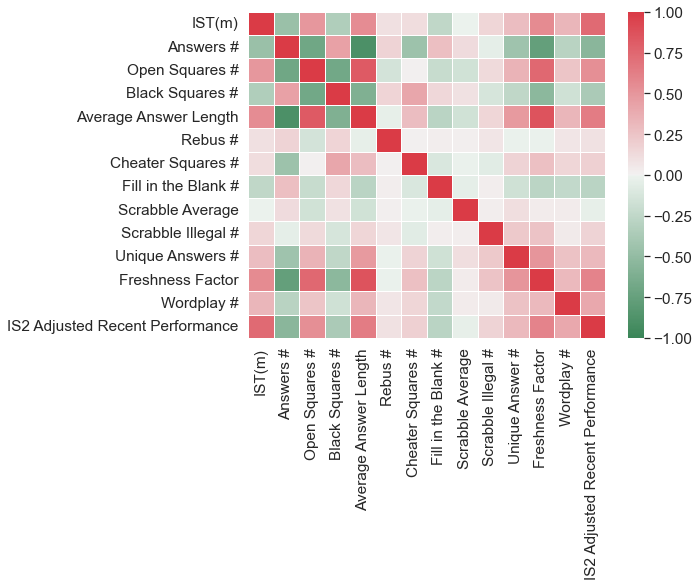

In [84]:
# 15x15 Puzzles Features Correlation to Individual Solver Raw Solve Times Heat Map

IS2_15x15 = IS2_df3.loc[IS2_df3["DOW"]!=("Sunday")]
puzzle_features = IS2_15x15[["IST(m)", "Words", "Open_Squares", "Blocks", "AWL", "Rebus_Count", "Cheater_Squares", "FITB", "Scrabble_Avg", "Scrabble_Illegal", "Unique_Answers", "Freshness_Factor", "Wordplay", "IS_pds_l10_dw"]]

corr = puzzle_features.corr()

labels = {
'IST(m)':'IST(m)',  
'Words':'Answers #', 
'Open_Squares':'Open Squares #',
'Blocks': 'Black Squares #',
'AWL':'Average Answer Length', 
'Rebus_Count':'Rebus #',    
'Cheater_Squares':'Cheater Squares #',
'FITB':'Fill in the Blank #',
'Scrabble_Avg':'Scrabble Average',
'Scrabble_Illegal':'Scrabble Illegal #',
'Unique_Answers':'Unique Answers #',
'Freshness_Factor':'Freshness Factor',
'Wordplay':'Wordplay #',
'IS_pds_l10_dw': 'IS2 Adjusted Recent Performance'    
}

corr = corr.rename(labels)

# remove the top right triangle - duplicate information
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)
plt.figure(figsize=(8,6))
ans=sns.heatmap(corr,  linewidths=1, cmap=cmap, center=0, xticklabels=True, yticklabels=True, vmin=-1, vmax=1)

_= ans.set_xticklabels(['IST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Average Answer Length', 'Rebus #', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'Wordplay #', 'IS2 Adjusted Recent Performance'])
#_= ans.set_yticklabels(['IST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Average Answer Length', 'Rebus #', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'Recent Adj Perf', 'Past Perf vs Constructor(s)'])

#save image 
# figure = ans.get_figure()    
# figure.savefig('correlations.png', dpi=800)

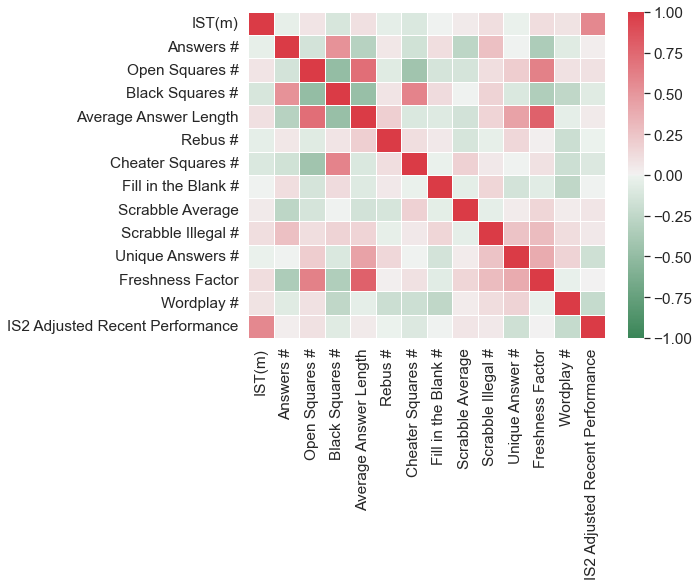

In [85]:
# 21x21 (Sunday) Puzzles Features Correlation to Individual Solver Raw Solve Times Heat Map

IS2_21x21 = IS2_df3.loc[IS2_df3["DOW"]==("Sunday")]
puzzle_features = IS2_21x21[["IST(m)", "Words", "Open_Squares", "Blocks", "AWL", "Rebus_Count", "Cheater_Squares", "FITB", "Scrabble_Avg", "Scrabble_Illegal", "Unique_Answers", "Freshness_Factor", "Wordplay", "IS_pds_l10_dw"]]

corr = puzzle_features.corr()

labels = {
'IST(m)':'IST(m)',  
'Words':'Answers #', 
'Open_Squares':'Open Squares #',
'Blocks': 'Black Squares #',
'AWL':'Average Answer Length', 
'Rebus_Count':'Rebus #',    
'Cheater_Squares':'Cheater Squares #',
'FITB':'Fill in the Blank #',
'Scrabble_Avg':'Scrabble Average',
'Scrabble_Illegal':'Scrabble Illegal #',
'Unique_Answers':'Unique Answers #',
'Freshness_Factor':'Freshness Factor',
'Wordplay':'Wordplay #',
'IS_pds_l10_dw': 'IS2 Adjusted Recent Performance'    
}

corr = corr.rename(labels)

# remove the top right triange - duplicate information
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)
plt.figure(figsize=(8,6))
ans=sns.heatmap(corr,  linewidths=1, cmap=cmap, center=0, xticklabels=True, yticklabels=True, vmin=-1, vmax=1)

_= ans.set_xticklabels(['IST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Average Answer Length', 'Rebus #', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'Wordplay #', 'IS2 Adjusted Recent Performance'])

#save image 
# figure = ans.get_figure()    
# figure.savefig('correlations.png', dpi=800)

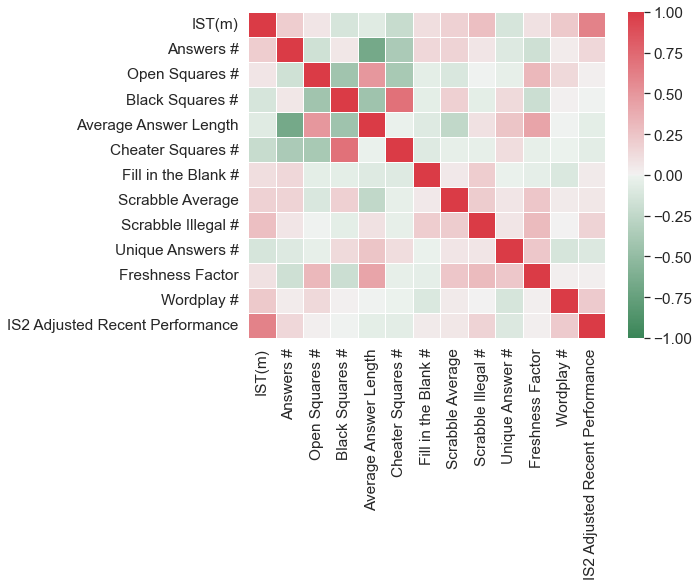

In [86]:
# Monday Puzzles Features Correlation to Individual Solver Raw Solve Times Heat Map

IS2_df3_Mon = IS2_df3.loc[IS2_df3["DOW"]==("Monday")]
puzzle_features = IS2_df3_Mon[["IST(m)", "Words", "Open_Squares", "Blocks", "AWL", "Cheater_Squares", "FITB", "Scrabble_Avg", "Scrabble_Illegal", "Unique_Answers", "Freshness_Factor", "Wordplay", "IS_pds_l10_dw"]]

corr = puzzle_features.corr()

labels = {
'IST(m)':'IST(m)',  
'Words':'Answers #', 
'Open_Squares':'Open Squares #',
'Blocks': 'Black Squares #',
'AWL':'Average Answer Length',   
'Cheater_Squares':'Cheater Squares #',
'FITB':'Fill in the Blank #',
'Scrabble_Avg':'Scrabble Average',
'Scrabble_Illegal':'Scrabble Illegal #',
'Unique_Answers':'Unique Answers #',
'Freshness_Factor':'Freshness Factor',
'Wordplay':'Wordplay #',
'IS_pds_l10_dw': 'IS2 Adjusted Recent Performance',    
}

corr = corr.rename(labels)

# remove the top right triange - duplicate information
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)
plt.figure(figsize=(8,6))
ans=sns.heatmap(corr,  linewidths=1, cmap=cmap, center=0, xticklabels=True, yticklabels=True, vmin=-1, vmax=1)

_= ans.set_xticklabels(['IST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Average Answer Length', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'Wordplay #', 'IS2 Adjusted Recent Performance'])

#save image 
# figure = ans.get_figure()    
# figure.savefig('correlations.png', dpi=800)

In [87]:
IS2_df3_Mon.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146 entries, 1 to 2094
Data columns (total 54 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   P_Date                                   146 non-null    datetime64[ns]
 1   P_Date_str                               146 non-null    object        
 2   P_Yr                                     146 non-null    period[A-DEC] 
 3   2023+_puzzle                             146 non-null    float64       
 4   DOW                                      146 non-null    object        
 5   DOW_num                                  146 non-null    float64       
 6   GMST(m)                                  146 non-null    float64       
 7   GMST(m)_10p_MA                           146 non-null    float64       
 8   Diff%_from_10pMA(GMS)                    146 non-null    int64         
 9   GMS_pds_l10_dw                           1

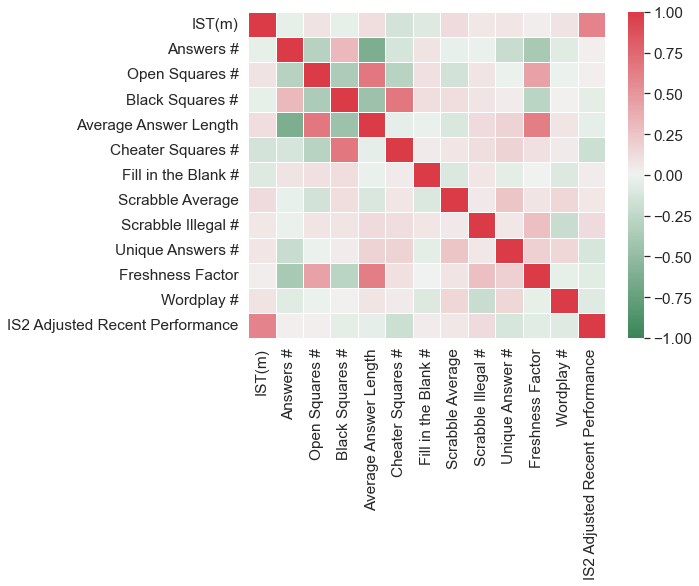

In [88]:
# Tuesday Puzzles Features Correlation to Individual Solver Raw Solve Times Heat Map

IS2_df3_Tue = IS2_df3.loc[IS2_df3["DOW"]==("Tuesday")]
puzzle_features = IS2_df3_Tue[["IST(m)", "Words", "Open_Squares", "Blocks", "AWL", "Cheater_Squares", "FITB", "Scrabble_Avg", "Scrabble_Illegal", "Unique_Answers", "Freshness_Factor", "Wordplay", "IS_pds_l10_dw"]]

corr = puzzle_features.corr()

labels = {
'IST(m)':'IST(m)',  
'Words':'Answers #', 
'Open_Squares':'Open Squares #',
'Blocks': 'Black Squares #',
'AWL':'Average Answer Length',   
'Cheater_Squares':'Cheater Squares #',
'FITB':'Fill in the Blank #',
'Scrabble_Avg':'Scrabble Average',
'Scrabble_Illegal':'Scrabble Illegal #',
'Unique_Answers':'Unique Answers #',
'Freshness_Factor':'Freshness Factor',
'Wordplay': 'Wordplay #',
'IS_pds_l10_dw': 'IS2 Adjusted Recent Performance'    
}

corr = corr.rename(labels)

# remove the top right triange - duplicate information
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)
plt.figure(figsize=(8,6))
ans=sns.heatmap(corr,  linewidths=1, cmap=cmap, center=0, xticklabels=True, yticklabels=True, vmin=-1, vmax=1)

_= ans.set_xticklabels(['IST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Average Answer Length', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'Wordplay #', 'IS2 Adjusted Recent Performance'])

#save image 
# figure = ans.get_figure()    
# figure.savefig('correlations.png', dpi=800)

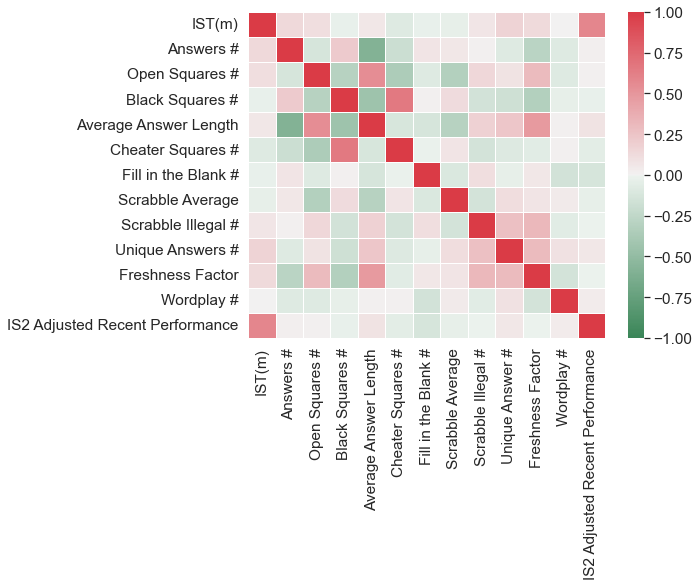

In [89]:
# Wednesday Puzzles Features Correlation to Individual Solver Raw Solve Times Heat Map

IS2_df3_Wed = IS2_df3.loc[IS2_df3["DOW"]==("Wednesday")]
puzzle_features = IS2_df3_Wed[["IST(m)", "Words", "Open_Squares", "Blocks", "AWL", "Cheater_Squares", "FITB", "Scrabble_Avg", "Scrabble_Illegal", "Unique_Answers", "Freshness_Factor", "Wordplay", "IS_pds_l10_dw"]]

corr = puzzle_features.corr()

labels = {
'IST(m)':'IST(m)',  
'Words':'Answers #', 
'Open_Squares':'Open Squares #',
'Blocks': 'Black Squares #',
'AWL':'Average Answer Length',   
'Cheater_Squares':'Cheater Squares #',
'FITB':'Fill in the Blank #',
'Scrabble_Avg':'Scrabble Average',
'Scrabble_Illegal':'Scrabble Illegal #',
'Unique_Answers':'Unique Answers #',
'Freshness_Factor':'Freshness Factor',
'Wordplay': 'Wordplay #',
'IS_pds_l10_dw': 'IS2 Adjusted Recent Performance'
}

corr = corr.rename(labels)

# remove the top right triange - duplicate information
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)
plt.figure(figsize=(8,6))
ans=sns.heatmap(corr,  linewidths=1, cmap=cmap, center=0, xticklabels=True, yticklabels=True, vmin=-1, vmax=1)

_= ans.set_xticklabels(['IST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Average Answer Length', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'Wordplay #', 'IS2 Adjusted Recent Performance'])

#save image 
# figure = ans.get_figure()    
# figure.savefig('correlations.png', dpi=800)

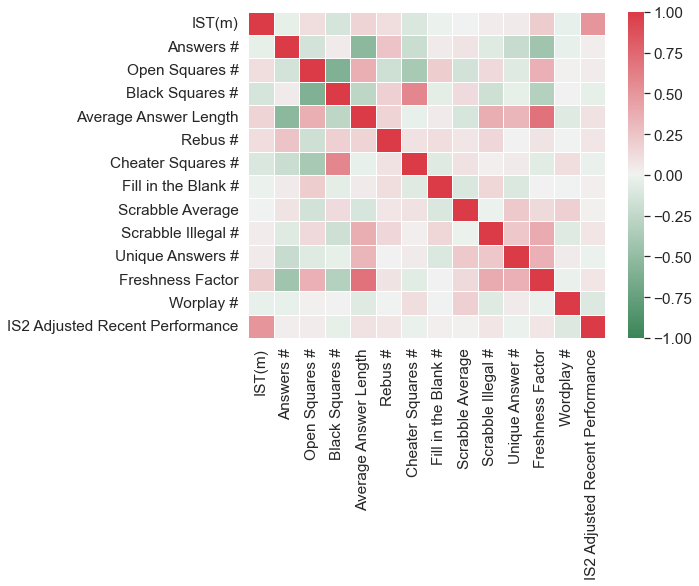

In [90]:
# Thursday Puzzles Features Correlation to Individual Solver Raw Solve Times Heat Map

IS2_df3_Thurs = IS2_df3.loc[IS2_df3["DOW"]==("Thursday")]
puzzle_features = IS2_df3_Thurs[["IST(m)", "Words", "Open_Squares", "Blocks", "AWL", "Rebus_Count", "Cheater_Squares", "FITB", "Scrabble_Avg", "Scrabble_Illegal", "Unique_Answers", "Freshness_Factor", "Wordplay", "IS_pds_l10_dw"]]

corr = puzzle_features.corr()

labels = {
'IST(m)':'IST(m)',  
'Words':'Answers #', 
'Open_Squares':'Open Squares #',
'Blocks': 'Black Squares #',
'AWL':'Average Answer Length', 
'Rebus_Count':'Rebus #',    
'Cheater_Squares':'Cheater Squares #',
'FITB':'Fill in the Blank #',
'Scrabble_Avg':'Scrabble Average',
'Scrabble_Illegal':'Scrabble Illegal #',
'Unique_Answers':'Unique Answers #',
'Freshness_Factor':'Freshness Factor',
'Wordplay':'Worplay #',
'IS_pds_l10_dw': 'IS2 Adjusted Recent Performance',    
}

corr = corr.rename(labels)

# remove the top right triange - duplicate information
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)
plt.figure(figsize=(8,6))
ans=sns.heatmap(corr,  linewidths=1, cmap=cmap, center=0, xticklabels=True, yticklabels=True, vmin=-1, vmax=1)

_= ans.set_xticklabels(['IST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Average Answer Length', 'Rebus #', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'Wordplay #', 'IS2 Adjusted Recent Performance'])
#save image 
# figure = ans.get_figure()    
# figure.savefig('correlations.png', dpi=800)

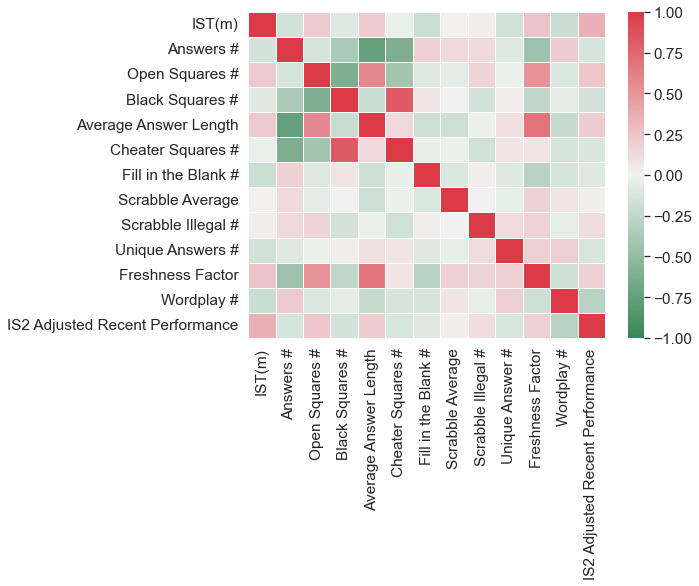

In [91]:
# Friday Puzzles Features Correlation to Individual Solver Raw Solve Times Heat Map

IS2_df3_Fri = IS2_df3.loc[IS2_df3["DOW"]==("Friday")]
puzzle_features = IS2_df3_Fri[["IST(m)", "Words", "Open_Squares", "Blocks", "AWL", "Cheater_Squares", "FITB", "Scrabble_Avg", "Scrabble_Illegal", "Unique_Answers", "Freshness_Factor", "Wordplay", "IS_pds_l10_dw"]]

corr = puzzle_features.corr()

labels = {
'IST(m)':'IST(m)',  
'Words':'Answers #', 
'Open_Squares':'Open Squares #',
'Blocks': 'Black Squares #',
'AWL':'Average Answer Length',   
'Cheater_Squares':'Cheater Squares #',
'FITB':'Fill in the Blank #',
'Scrabble_Avg':'Scrabble Average',
'Scrabble_Illegal':'Scrabble Illegal #',
'Unique_Answers':'Unique Answers #',
'Freshness_Factor':'Freshness Factor',
'Wordplay':'Wordplay #',
'IS_pds_l10_dw': 'IS2 Adjusted Recent Performance'
}

corr = corr.rename(labels)

# remove the top right triange - duplicate information
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)
plt.figure(figsize=(8,6))
ans=sns.heatmap(corr,  linewidths=1, cmap=cmap, center=0, xticklabels=True, yticklabels=True, vmin=-1, vmax=1)

_= ans.set_xticklabels(['IST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Average Answer Length', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'Wordplay #', 'IS2 Adjusted Recent Performance'])

#save image 
# figure = ans.get_figure()    
# figure.savefig('correlations.png', dpi=800)

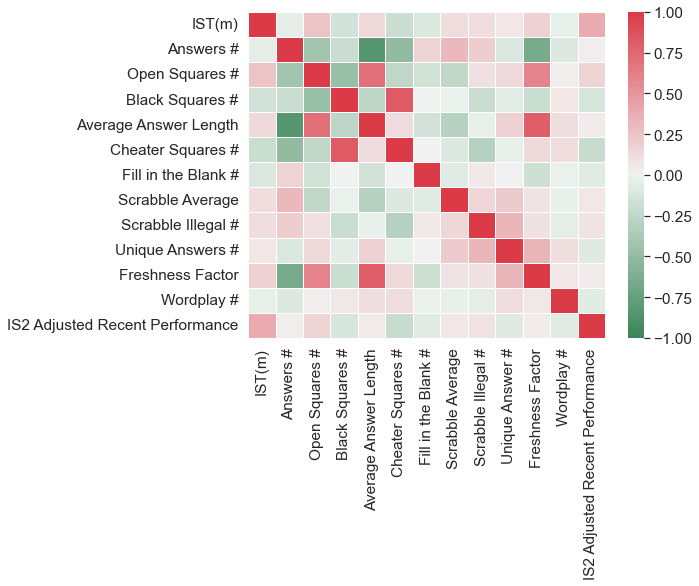

In [92]:
# Saturday Puzzles Features Correlation to Individual Solver Raw Solve Times Heat Map

IS2_df3_Sat = IS2_df3.loc[IS2_df3["DOW"]==("Saturday")]
puzzle_features = IS2_df3_Sat[["IST(m)", "Words", "Open_Squares", "Blocks", "AWL", "Cheater_Squares", "FITB", "Scrabble_Avg", "Scrabble_Illegal", "Unique_Answers", "Freshness_Factor", "Wordplay", "IS_pds_l10_dw"]]

corr = puzzle_features.corr()

labels = {
'IST(m)':'IST(m)',  
'Words':'Answers #', 
'Open_Squares':'Open Squares #',
'Blocks': 'Black Squares #',
'AWL':'Average Answer Length',   
'Cheater_Squares':'Cheater Squares #',
'FITB':'Fill in the Blank #',
'Scrabble_Avg':'Scrabble Average',
'Scrabble_Illegal':'Scrabble Illegal #',
'Unique_Answers':'Unique Answers #',
'Freshness_Factor':'Freshness Factor',
'Wordplay':'Wordplay #',
'IS_pds_l10_dw': 'IS2 Adjusted Recent Performance'
}

corr = corr.rename(labels)

# remove the top right triange - duplicate information
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)
plt.figure(figsize=(8,6))
ans=sns.heatmap(corr,  linewidths=1, cmap=cmap, center=0, xticklabels=True, yticklabels=True, vmin=-1, vmax=1)

_= ans.set_xticklabels(['IST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Average Answer Length', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'Wordplay #', 'IS2 Adjusted Recent Performance'])

#save image 
# figure = ans.get_figure()    
# figure.savefig('correlations.png', dpi=800)

### Scatterplots of Relationship of Grid, Answer and Past-Performance Parameters to IS2 Per Puzzle Performance

In [ ]:
IS2_df3.info()

In [93]:
# Create new df with all rows copied and placed below current rows. 
# This is so we can plot all 15x15 data together as a subplot in the figures below

IS2_df3_copy = IS2_df3.loc[(IS2_df3["DOW_num"] != 1)] #15x15 only
IS2_df3_copy["DOW_num"] = 0

IS2_df4 = pd.concat([IS2_df3, IS2_df3_copy],ignore_index=True)

In [ ]:
IS2_df4.info()

In [ ]:
IS2_df4["DOW_num"].unique()

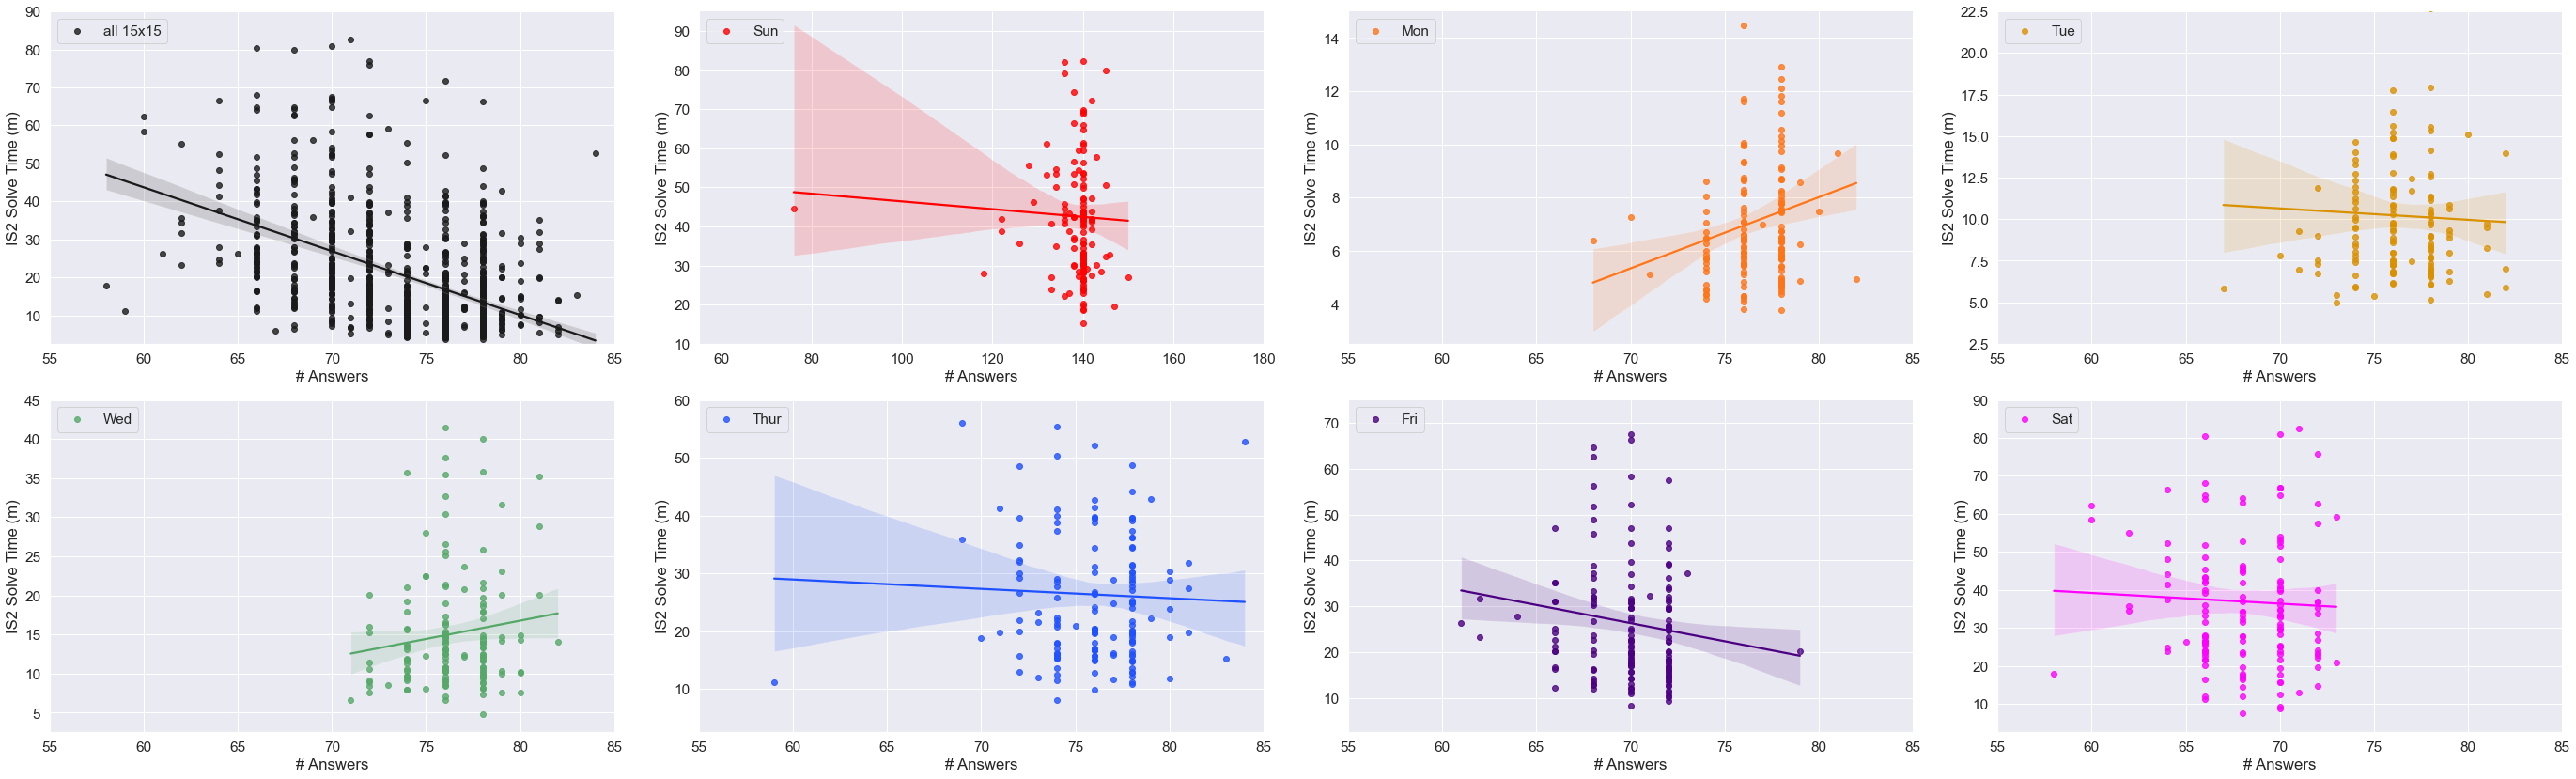

In [94]:
# Number of Answers vs IS2 Raw Solve Times

IS2_df4 = IS2_df4.sort_values(by=['DOW_num'], ascending = True)

IS2_df4['plot_seq_map'] = IS2_df4['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS2_df4, x="Words", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "# Answers",
    ylabel="IS2 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((55,85))
p.axes[1].set_xlim((55,180))
p.axes[2].set_xlim((55,85))
p.axes[3].set_xlim((55,85))
p.axes[4].set_xlim((55,85))
p.axes[5].set_xlim((55,85))
p.axes[6].set_xlim((55,85))
p.axes[7].set_xlim((55,85))

p.axes[0].set_ylim((2.5,90))
p.axes[1].set_ylim((10,95))
p.axes[2].set_ylim((2.5,15))
p.axes[3].set_ylim((2.5,22.5))
p.axes[4].set_ylim((2.5,45))
p.axes[5].set_ylim((2.5,60))
p.axes[6].set_ylim((2.5,75))
p.axes[7].set_ylim((2.5,90))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [95]:
# Calculate IS2 Pearson R for 15x15 grids for this feature
IS2_15x15 = IS2_df3.loc[IS2_df3["DOW"]!=("Sunday")] #only need to filter down this one time, and can apply to correlations for all subsequent features analysed

print(IS2_15x15['IST(m)'].corr(IS2_15x15['Words']))

-0.4683227801262822


In [96]:
# Calculate GMS Pearson R for 15x15 grids for this feature

print(IS2_15x15['GMST(m)'].corr(IS2_15x15['Words']))

-0.5550315344505218


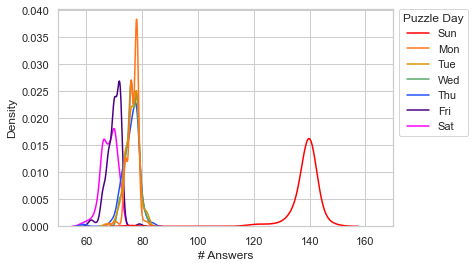

In [97]:
# Density plot of number of answers in puzzles solved by IS2
# Rememember to use df3 because df4 has the copied-in data for plotting all completed puzzles together
IS2_df3['plot_seq_map'] = IS2_df3['DOW_num'].map({1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5:'Thu', 6:'Fri', 7:'Sat'})
IS2_df3 = IS2_df3.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=IS2_df3, x = "Words", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(50, 170)
ax.set_xlabel("# Answers")
plt.show()

In [98]:
IS2_df3["Words"].agg(['min', 'max'])

min     58
max    150
Name: Words, dtype: int64

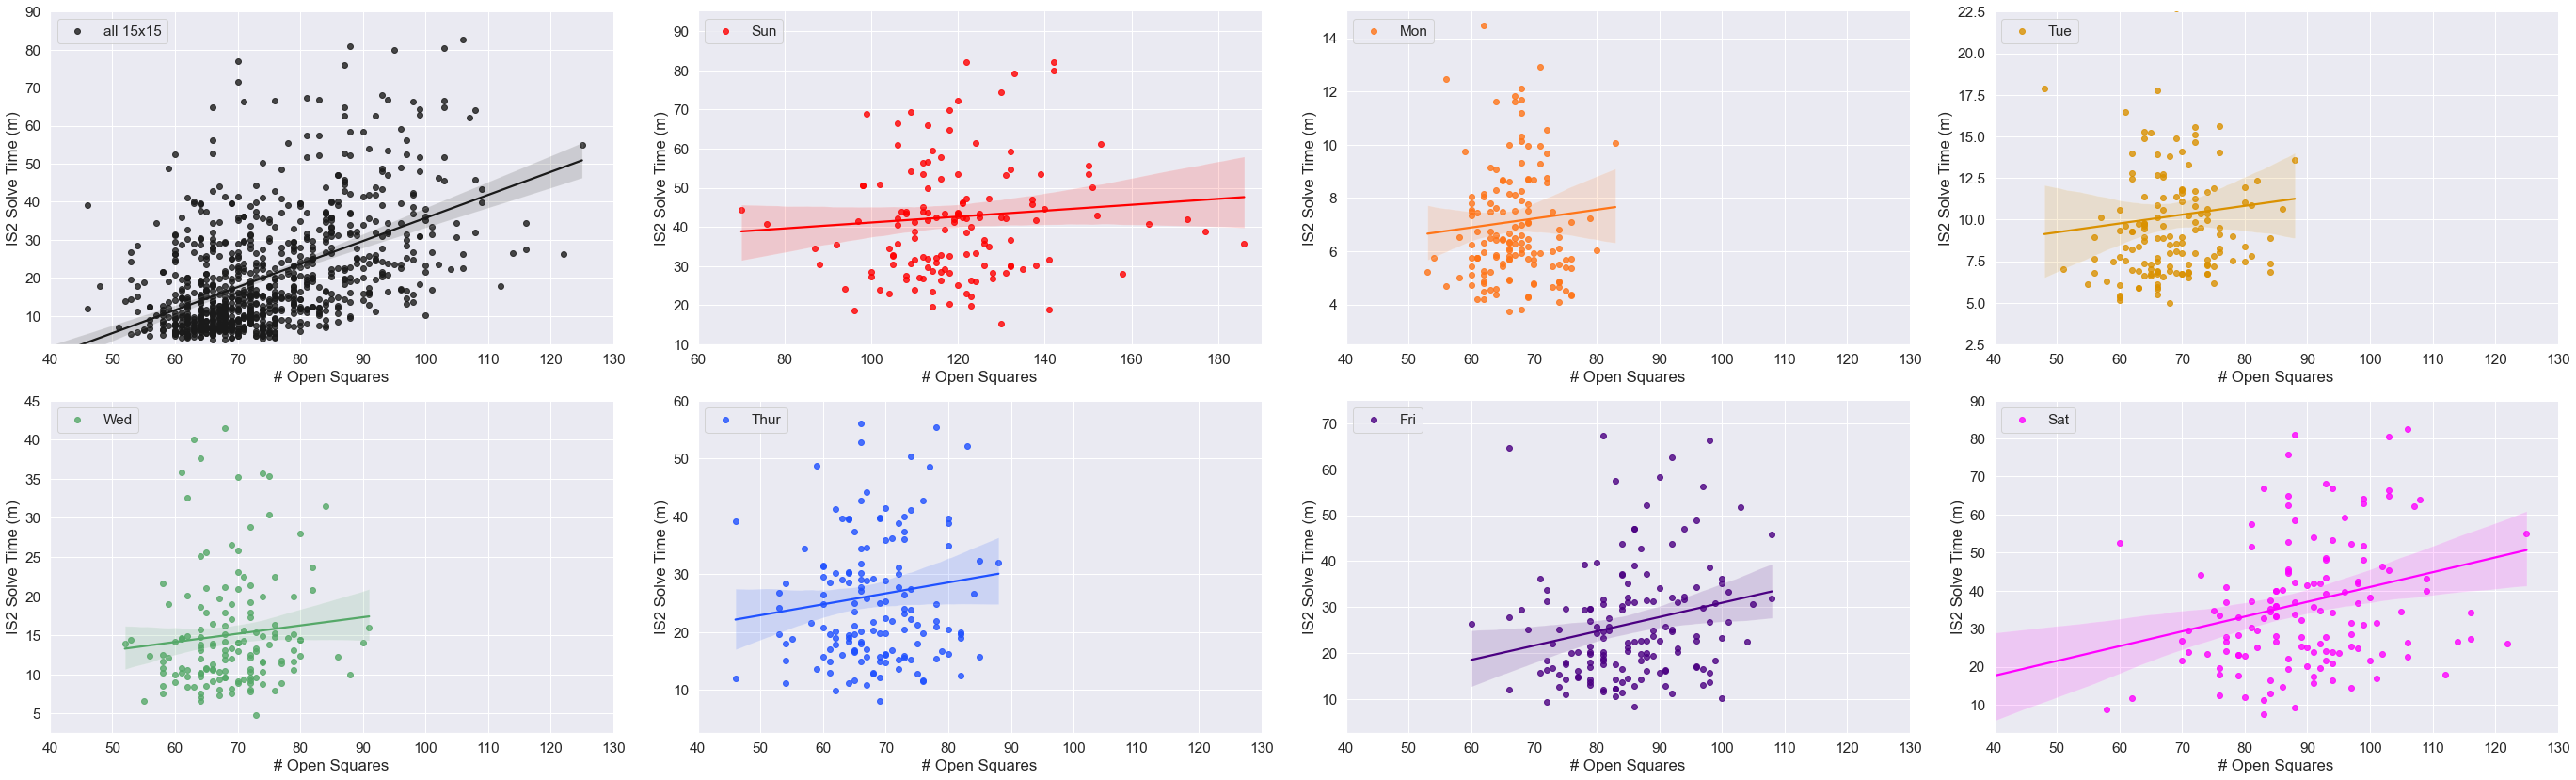

In [99]:
# Open Squares vs IS2 Raw Solve Times

IS2_df4 = IS2_df4.sort_values(by=['DOW_num'], ascending = True)

IS2_df4['plot_seq_map'] = IS2_df4['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS2_df4, x="Open_Squares", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "# Open Squares",
    ylabel="IS2 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((40,130))
p.axes[1].set_xlim((60,190))
p.axes[2].set_xlim((40,130))
p.axes[3].set_xlim((40,130))
p.axes[4].set_xlim((40,130))
p.axes[5].set_xlim((40,130))
p.axes[6].set_xlim((40,130))
p.axes[7].set_xlim((40,130))

p.axes[0].set_ylim((2.5,90))
p.axes[1].set_ylim((10,95))
p.axes[2].set_ylim((2.5,15))
p.axes[3].set_ylim((2.5,22.5))
p.axes[4].set_ylim((2.5,45))
p.axes[5].set_ylim((2.5,60))
p.axes[6].set_ylim((2.5,75))
p.axes[7].set_ylim((2.5,90))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [100]:
# Calculate IS2 Pearson R for 15x15 grids for this feature
#IS2_15x15 = IS2_df3.loc[IS2_df3["DOW"]!=("Sunday")]

print(IS2_15x15['IST(m)'].corr(IS2_15x15['Open_Squares']))

0.4937501704530586


In [101]:
# Calculate GMS Pearson R for 15x15 grids for this feature
#IS2_15x15 = IS2_df3.loc[IS2_df3["DOW"]!=("Sunday")]

print(IS2_15x15['GMST(m)'].corr(IS2_15x15['Open_Squares']))

0.5576128351788565


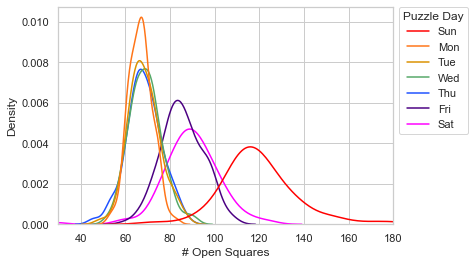

In [102]:
# Density plot of number of open squares in puzzles solved by IS2
# Rememember to use df3 because df4 has the copied-in data for plotting all completed puzzles together

IS2_df3 = IS2_df3.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=IS2_df3, x = "Open_Squares", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(30, 180)
ax.set_xlabel("# Open Squares")
plt.show()

In [103]:
IS2_df3["Open_Squares"].agg(['min', 'max'])

min     29
max    186
Name: Open_Squares, dtype: int64

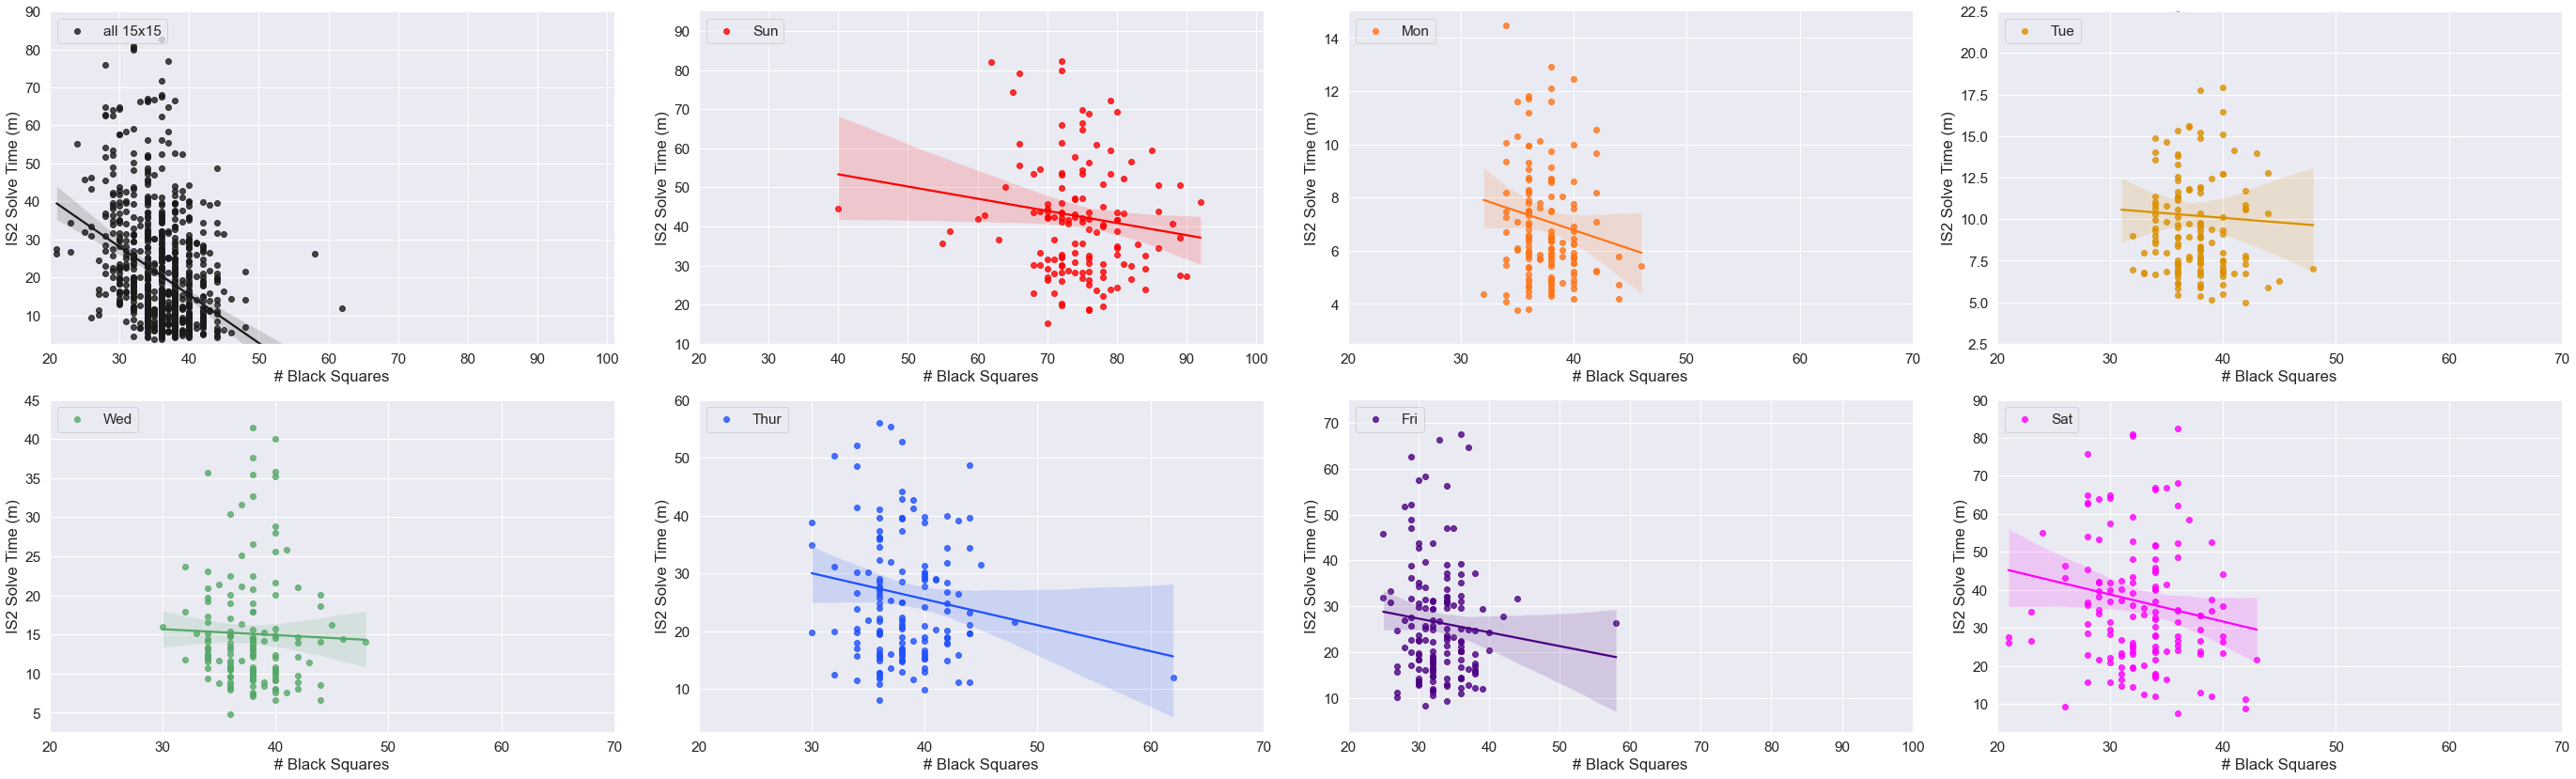

In [104]:
# Black Squares (blocks) vs IS2 Raw Solve Times

IS2_df4 = IS2_df4.sort_values(by=['DOW_num'], ascending = True)

IS2_df4['plot_seq_map'] = IS2_df4['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS2_df4, x="Blocks", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "# Black Squares",
    ylabel="IS2 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((20,101))
p.axes[1].set_xlim((20,101))
p.axes[2].set_xlim((20,70))
p.axes[3].set_xlim((20,70))
p.axes[4].set_xlim((20,70))
p.axes[5].set_xlim((20,70))
p.axes[6].set_xlim((20,100))
p.axes[7].set_xlim((20,70))

p.axes[0].set_ylim((2.5,90))
p.axes[1].set_ylim((10,95))
p.axes[2].set_ylim((2.5,15))
p.axes[3].set_ylim((2.5,22.5))
p.axes[4].set_ylim((2.5,45))
p.axes[5].set_ylim((2.5,60))
p.axes[6].set_ylim((2.5,75))
p.axes[7].set_ylim((2.5,90))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [105]:
# Calculate Pearson R for IS2 15x15 grids for this feature
#IS2_15x15 = IS2_df3.loc[IS2_df3["DOW"]!=("Sunday")]

print(IS2_15x15['IST(m)'].corr(IS2_15x15['Blocks']))

-0.3416250565596975


In [106]:
# Calculate Pearson R for GMS 15x15 grids for this feature
#IS2_15x15 = IS2_df3.loc[IS2_df3["DOW"]!=("Sunday")]

print(IS2_15x15['GMST(m)'].corr(IS2_15x15['Blocks']))

-0.38635133774362046


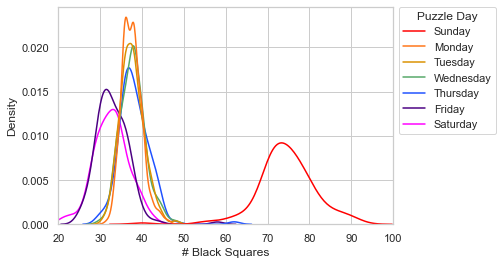

In [107]:
# Density plot of number of black squares (blocks) in puzzles solved by IS2
# Rememember to use df3 because df4 has the copied-in data for plotting all completed puzzles together

IS2_df3 = IS2_df3.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=IS2_df3, x = "Blocks", hue= "DOW", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(20, 100)
ax.set_xlabel("# Black Squares")
plt.show()

In [108]:
IS2_df3["Blocks"].agg(['min', 'max'])

min    21
max    92
Name: Blocks, dtype: int64

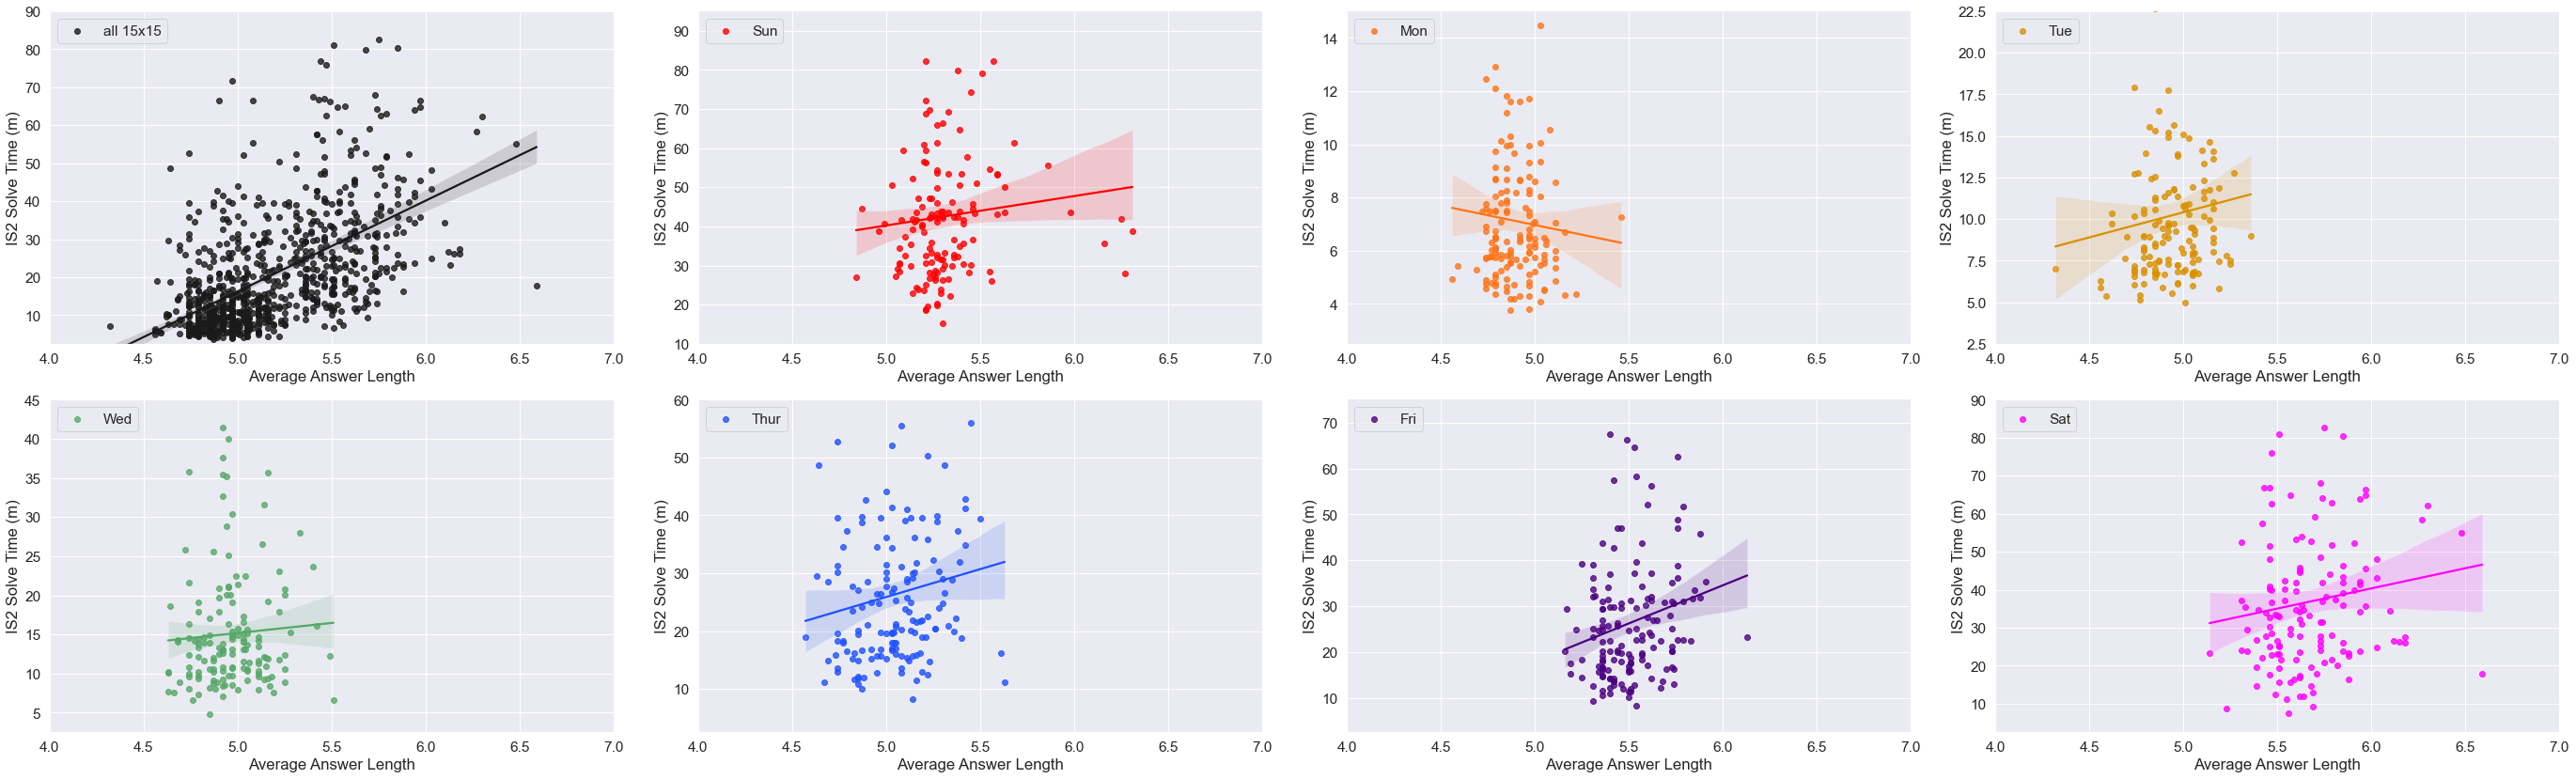

In [109]:
# Average Answer Length vs IS2 Raw Solve Times

IS2_df4 = IS2_df4.sort_values(by=['DOW_num'], ascending = True)

IS2_df4['plot_seq_map'] = IS2_df4['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS2_df4, x="AWL", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "Average Answer Length",
    ylabel="IS2 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((4,7))
p.axes[1].set_xlim((4,7))
p.axes[2].set_xlim((4,7))
p.axes[3].set_xlim((4,7))
p.axes[4].set_xlim((4,7))
p.axes[5].set_xlim((4,7))
p.axes[6].set_xlim((4,7))
p.axes[7].set_xlim((4,7))

p.axes[0].set_ylim((2.5,90))
p.axes[1].set_ylim((10,95))
p.axes[2].set_ylim((2.5,15))
p.axes[3].set_ylim((2.5,22.5))
p.axes[4].set_ylim((2.5,45))
p.axes[5].set_ylim((2.5,60))
p.axes[6].set_ylim((2.5,75))
p.axes[7].set_ylim((2.5,90))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [110]:
# Calculate Pearson R for IS2 for 15x15 grids for this feature
#IS2_15x15 = IS2_df3.loc[IS2_df3["DOW"]!=("Sunday")]

print(IS2_15x15['IST(m)'].corr(IS2_15x15['AWL']))

0.5536546350855206


In [111]:
# Calculate Pearson R for GMS for 15x15 grids for this feature
#IS2_15x15 = IS2_df3.loc[IS2_df3["DOW"]!=("Sunday")]

print(IS2_15x15['GMST(m)'].corr(IS2_15x15['AWL']))

0.6607012011508429


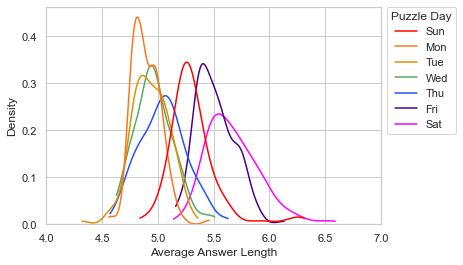

In [112]:
# Density plot of average answer length in puzzles solved by IS2
# Rememember to use df3 because df4 has the copied-in data for plotting all completed puzzles together

IS2_df3 = IS2_df3.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=IS2_df3, x = "AWL", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True, cut=0, clip=(3,7))

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(4, 7)
ax.set_xlabel("Average Answer Length")
plt.show()

In [113]:
IS2_df3["AWL"].agg(['min', 'max'])

min    4.32
max    6.59
Name: AWL, dtype: float64

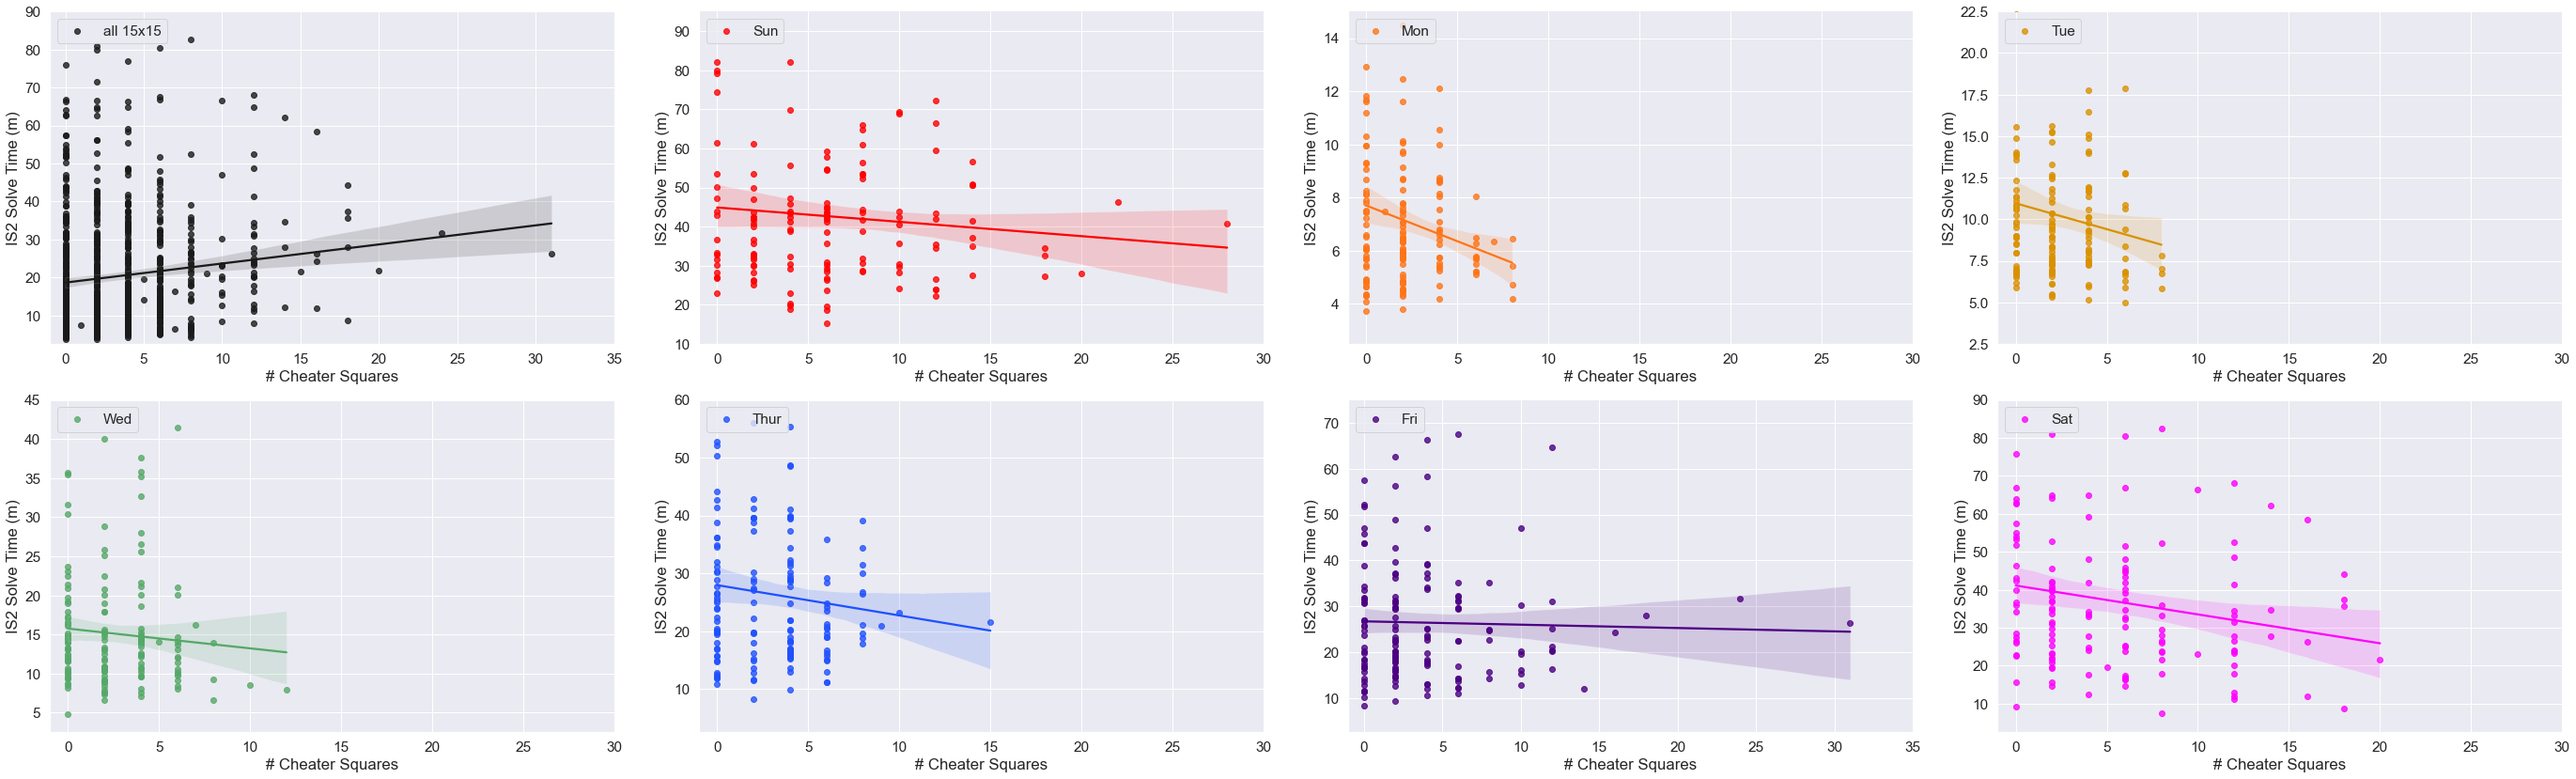

In [114]:
# Cheater Squares vs IS2 Raw Solve Times

IS2_df4 = IS2_df4.sort_values(by=['DOW_num'], ascending = True)

IS2_df4['plot_seq_map'] = IS2_df4['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS2_df4, x="Cheater_Squares", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "# Cheater Squares",
    ylabel="IS2 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((-1,35))
p.axes[1].set_xlim((-1,30))
p.axes[2].set_xlim((-1,30))
p.axes[3].set_xlim((-1,30))
p.axes[4].set_xlim((-1,30))
p.axes[5].set_xlim((-1,30))
p.axes[6].set_xlim((-1,35))
p.axes[7].set_xlim((-1,30))

p.axes[0].set_ylim((2.5,90))
p.axes[1].set_ylim((10,95))
p.axes[2].set_ylim((2.5,15))
p.axes[3].set_ylim((2.5,22.5))
p.axes[4].set_ylim((2.5,45))
p.axes[5].set_ylim((2.5,60))
p.axes[6].set_ylim((2.5,75))
p.axes[7].set_ylim((2.5,90))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [115]:
# Calculate Pearson R for 15x15 grids for IS2 for this feature
#IS2_15x15 = IS2_df3.loc[IS2_df3["DOW"]!=("Sunday")]

print(IS2_15x15['IST(m)'].corr(IS2_15x15['Cheater_Squares']))

0.1162670891836623


In [116]:
# Calculate Pearson R for 15x15 grids for GMS for this feature
#IS2_15x15 = IS2_df3.loc[IS2_df3["DOW"]!=("Sunday")]

print(IS2_15x15['GMST(m)'].corr(IS2_15x15['Cheater_Squares']))

0.18279555059130786


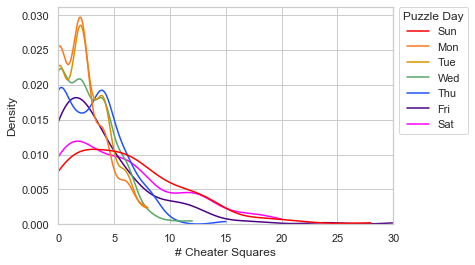

In [117]:
# Density plot of number of cheater squares in puzzles solved by IS2
# Rememember to use df3 because df4 has the copied-in data for plotting all completed puzzles together

IS2_df3 = IS2_df3.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=IS2_df3, x = "Cheater_Squares", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True, cut=0, clip=(0,30))

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(0, 30)
ax.set_xlabel("# Cheater Squares")
plt.show()

In [118]:
IS2_df3["Cheater_Squares"].agg(['min', 'max'])

min     0
max    31
Name: Cheater_Squares, dtype: int64

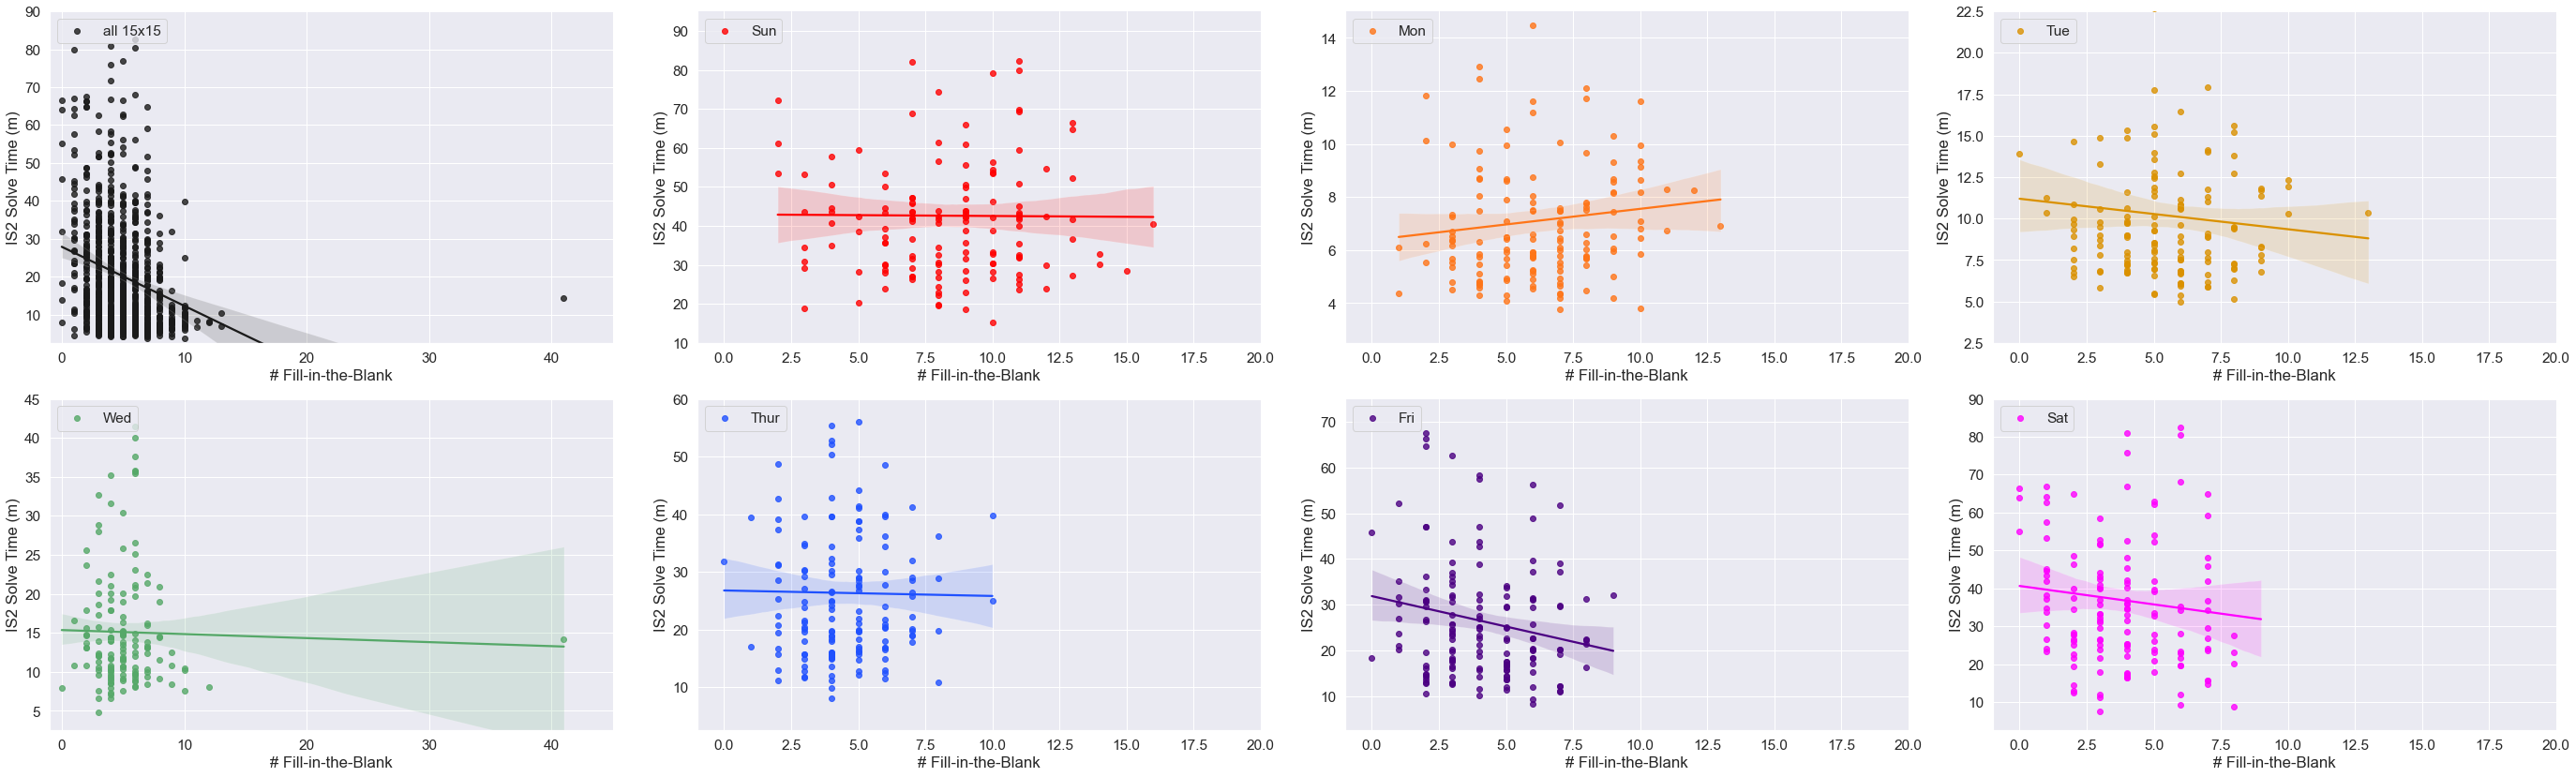

In [119]:
# Fill-in-the-blank clues vs IS2 Raw Solve Times

IS2_df4 = IS2_df4.sort_values(by=['DOW_num'], ascending = True)

IS2_df4['plot_seq_map'] = IS2_df4['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS2_df4, x="FITB", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "# Fill-in-the-Blank",
    ylabel="IS2 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((-1,45))
p.axes[1].set_xlim((-1,20))
p.axes[2].set_xlim((-1,20))
p.axes[3].set_xlim((-1,20))
p.axes[4].set_xlim((-1,45))
p.axes[5].set_xlim((-1,20))
p.axes[6].set_xlim((-1,20))
p.axes[7].set_xlim((-1,20))

p.axes[0].set_ylim((2.5,90))
p.axes[1].set_ylim((10,95))
p.axes[2].set_ylim((2.5,15))
p.axes[3].set_ylim((2.5,22.5))
p.axes[4].set_ylim((2.5,45))
p.axes[5].set_ylim((2.5,60))
p.axes[6].set_ylim((2.5,75))
p.axes[7].set_ylim((2.5,90))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [120]:
# Calculate Pearson R for 15x15 grids for IS2 for this feature
#IS2_15x15 = IS2_df3.loc[IS2_df3["DOW"]!=("Sunday")]

print(IS2_15x15['IST(m)'].corr(IS2_15x15['FITB']))

-0.2550856158807385


In [121]:
# Calculate Pearson R for 15x15 grids for GMS for this feature
#IS2_15x15 = IS2_df3.loc[IS2_df3["DOW"]!=("Sunday")]

print(IS2_15x15['GMST(m)'].corr(IS2_15x15['FITB']))

-0.26052045926860684


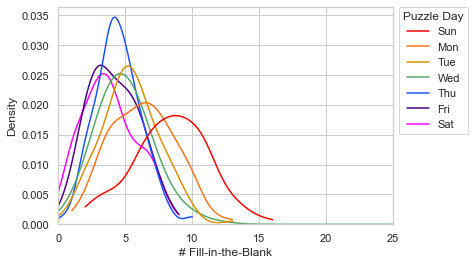

In [122]:
# Density plot of number of fill-in-the-blank clues in puzzles solved by IS2
# Rememember to use df3 because df4 has the copied-in data for plotting all completed puzzles together

IS2_df3 = IS2_df3.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=IS2_df3, x = "FITB", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True, cut=0, clip=(0,45))

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(0, 25)
ax.set_xlabel("# Fill-in-the-Blank")
plt.show()

In [123]:
IS2_df3["FITB"].agg(['min', 'max'])

min     0
max    41
Name: FITB, dtype: int64

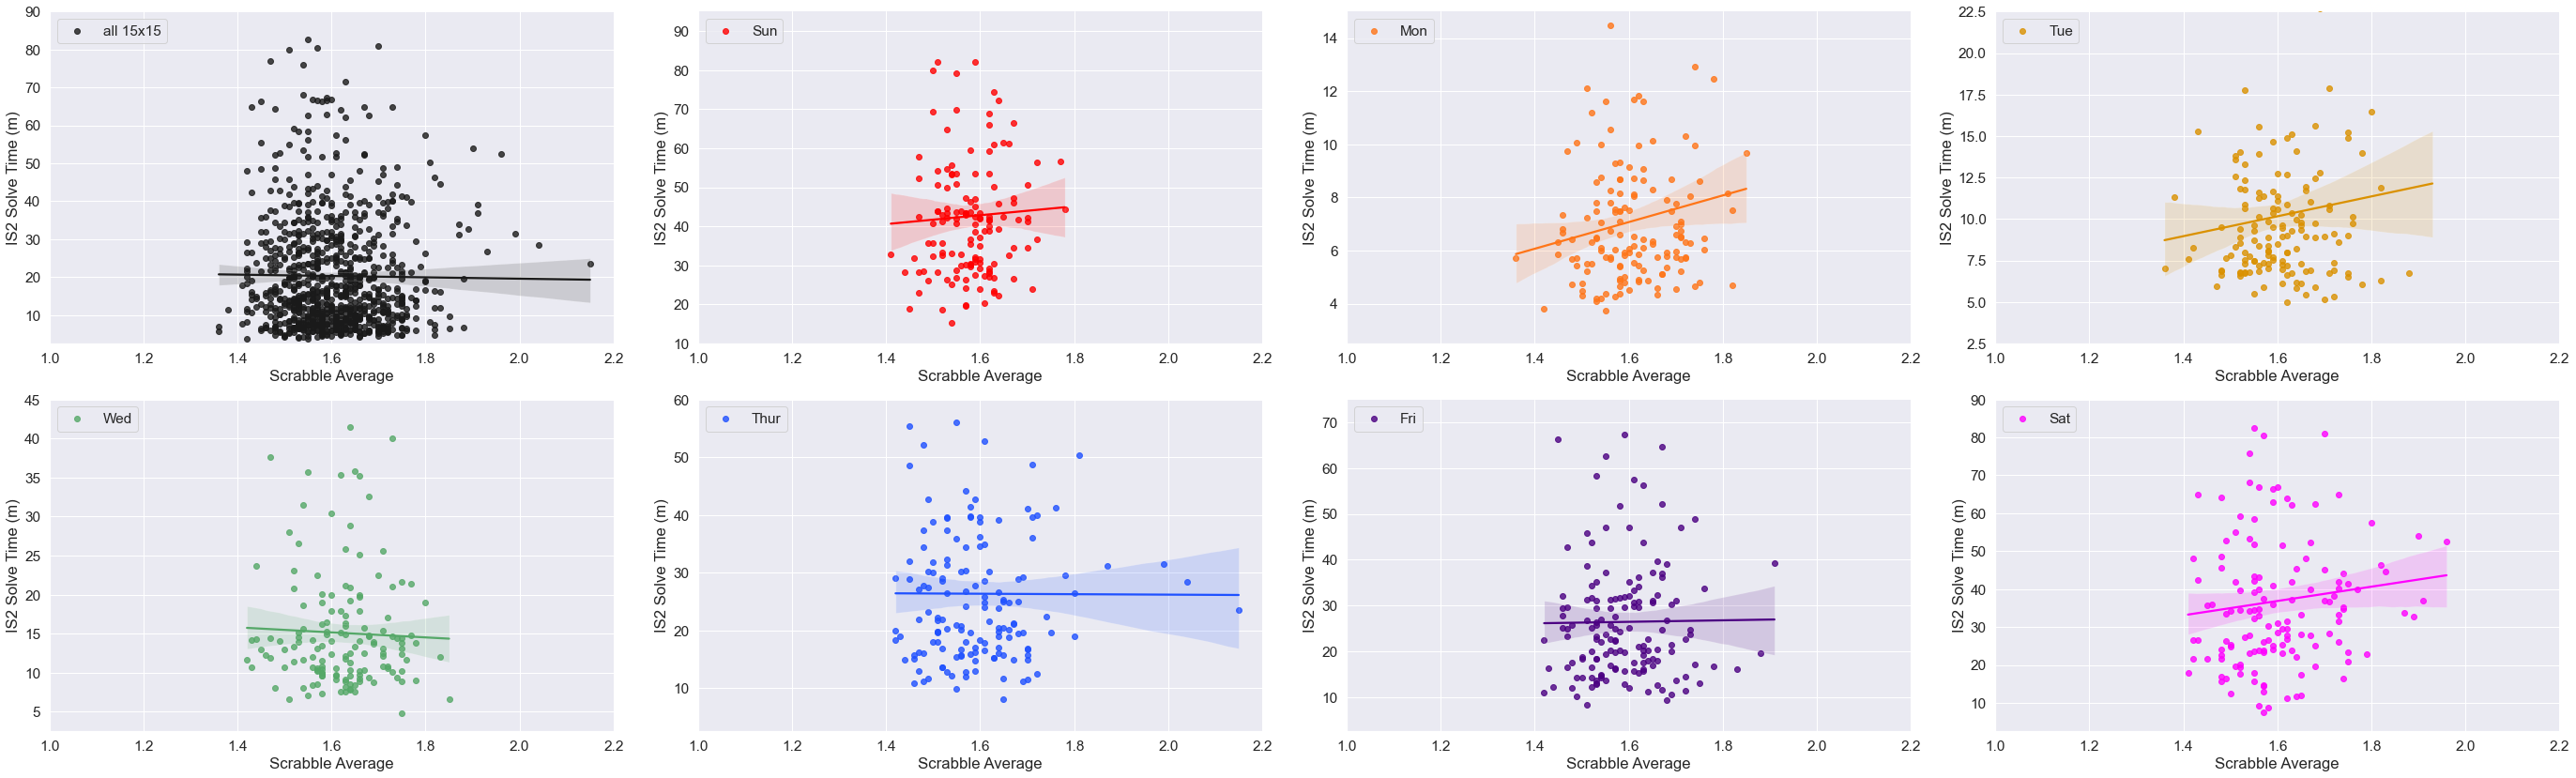

In [124]:
# Scrabble Average vs IS2 Raw Solve Times

IS2_df4 = IS2_df4.sort_values(by=['DOW_num'], ascending = True)

IS2_df4['plot_seq_map'] = IS2_df4['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS2_df4, x="Scrabble_Avg", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "Scrabble Average",
    ylabel="IS2 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((1,2.2))
p.axes[1].set_xlim((1,2.2))
p.axes[2].set_xlim((1,2.2))
p.axes[3].set_xlim((1,2.2))
p.axes[4].set_xlim((1,2.2))
p.axes[5].set_xlim((1,2.2))
p.axes[6].set_xlim((1,2.2))
p.axes[7].set_xlim((1,2.2))

p.axes[0].set_ylim((2.5,90))
p.axes[1].set_ylim((10,95))
p.axes[2].set_ylim((2.5,15))
p.axes[3].set_ylim((2.5,22.5))
p.axes[4].set_ylim((2.5,45))
p.axes[5].set_ylim((2.5,60))
p.axes[6].set_ylim((2.5,75))
p.axes[7].set_ylim((2.5,90))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [125]:
# Calculate Pearson R for 15x15 grids for IS2 for this feature
#IS2_15x15 = IS2_df3.loc[IS2_df3["DOW"]!=("Sunday")]

print(IS2_15x15['IST(m)'].corr(IS2_15x15['Scrabble_Avg']))

-0.011420992433530593


In [126]:
# Calculate Pearson R for 15x15 grids for GMS for this feature
#IS2_15x15 = IS2_df3.loc[IS2_df3["DOW"]!=("Sunday")]

print(IS2_15x15['GMST(m)'].corr(IS2_15x15['Scrabble_Avg']))

-0.03187390351557088


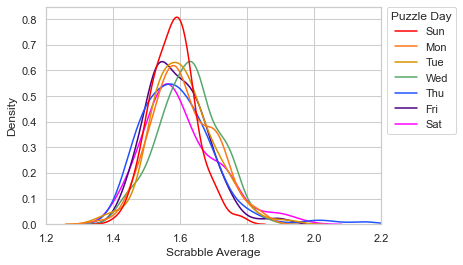

In [127]:
# Density plot of Scrabble Average in puzzles solved by IS2
# Rememember to use df3 because df4 has the copied-in data for plotting all completed puzzles together

IS2_df3 = IS2_df3.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=IS2_df3, x = "Scrabble_Avg", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(1.2, 2.2)
ax.set_xlabel("Scrabble Average")
plt.show()

In [128]:
IS2_df3["Scrabble_Avg"].agg(['min', 'max'])

min    1.36
max    2.15
Name: Scrabble_Avg, dtype: float64

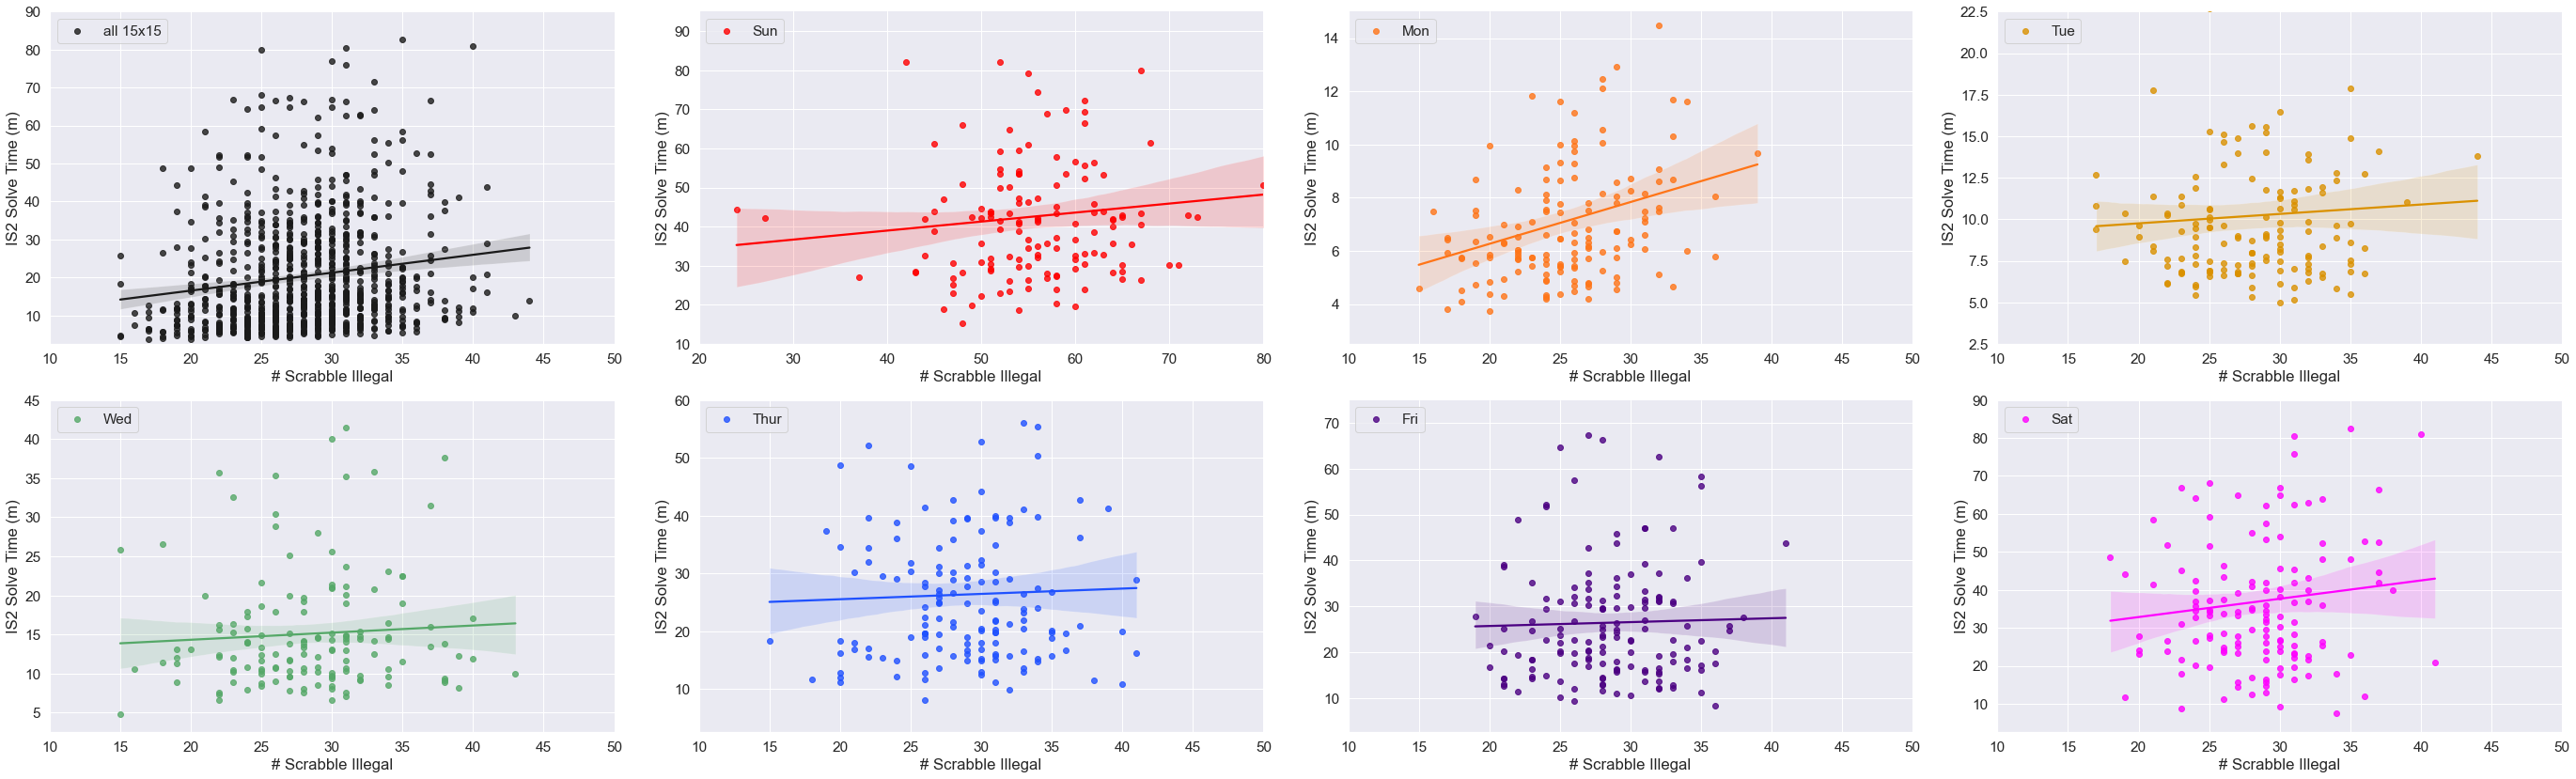

In [129]:
# Scrabble Illegal # vs IS2 Raw Solve Times

IS2_df4 = IS2_df4.sort_values(by=['DOW_num'], ascending = True)

IS2_df4['plot_seq_map'] = IS2_df4['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS2_df4, x="Scrabble_Illegal", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "# Scrabble Illegal",
    ylabel="IS2 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((10,50))
p.axes[1].set_xlim((20,80))
p.axes[2].set_xlim((10,50))
p.axes[3].set_xlim((10,50))
p.axes[4].set_xlim((10,50))
p.axes[5].set_xlim((10,50))
p.axes[6].set_xlim((10,50))
p.axes[7].set_xlim((10,50))

p.axes[0].set_ylim((2.5,90))
p.axes[1].set_ylim((10,95))
p.axes[2].set_ylim((2.5,15))
p.axes[3].set_ylim((2.5,22.5))
p.axes[4].set_ylim((2.5,45))
p.axes[5].set_ylim((2.5,60))
p.axes[6].set_ylim((2.5,75))
p.axes[7].set_ylim((2.5,90))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [130]:
# Calculate Pearson R for IS2 for 15x15 grids for this feature
#IS2_15x15 = IS2_df3.loc[IS2_df3["DOW"]!=("Sunday")]

print(IS2_15x15['IST(m)'].corr(IS2_15x15['Scrabble_Illegal']))

0.14885611394005863


In [131]:
# Calculate Pearson R for GMS for 15x15 grids for this feature
#IS2_15x15 = IS2_df3.loc[IS2_df3["DOW"]!=("Sunday")]

print(IS2_15x15['GMST(m)'].corr(IS2_15x15['Scrabble_Illegal']))

0.20300522672870736


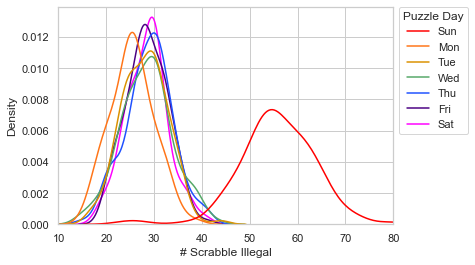

In [132]:
# Density plot of Scrabble Illegal # in puzzles solved by IS2
# Rememember to use df3 because df4 has the copied-in data for plotting all completed puzzles together

IS2_df3 = IS2_df3.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=IS2_df3, x = "Scrabble_Illegal", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(10, 80)
ax.set_xlabel("# Scrabble Illegal")
plt.show()

In [133]:
IS2_df3["Scrabble_Illegal"].agg(['min', 'max'])

min    15
max    80
Name: Scrabble_Illegal, dtype: int64

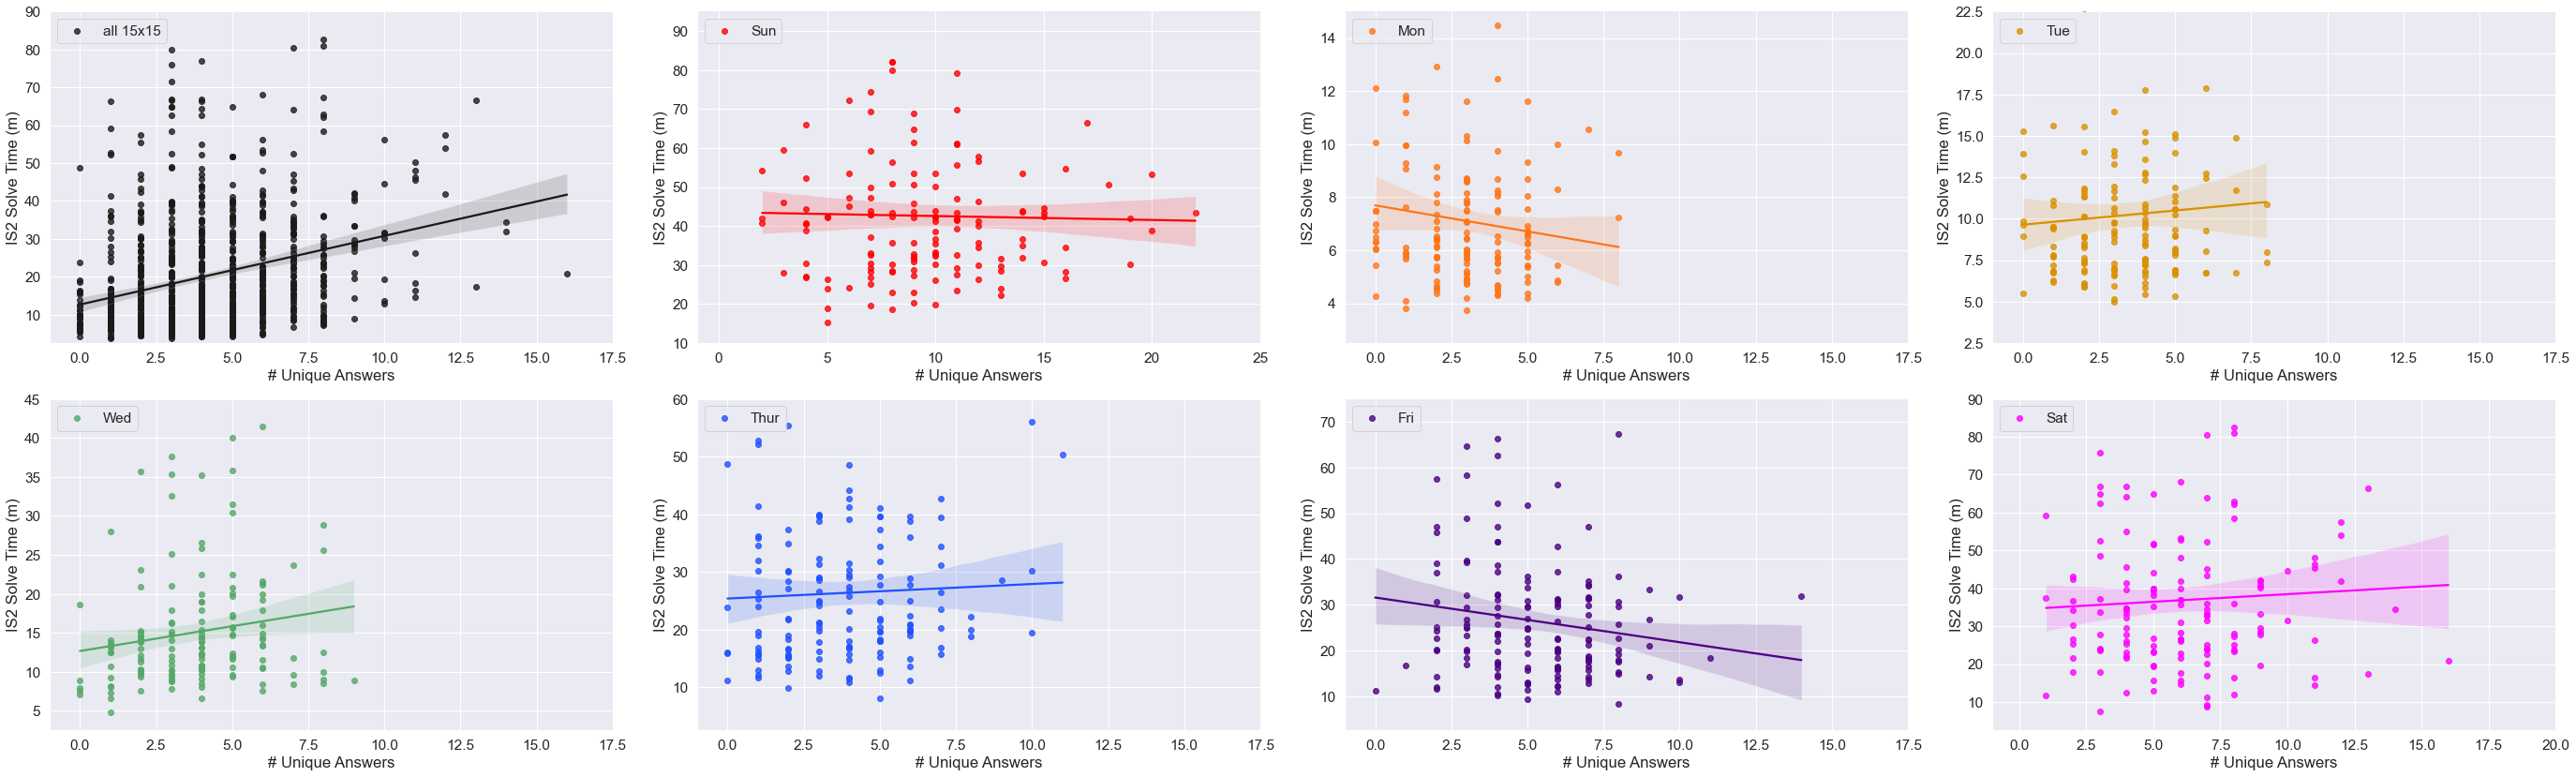

In [134]:
# Unique Answers # # vs IS2 Raw Solve Times

IS2_df4 = IS2_df4.sort_values(by=['DOW_num'], ascending = True)

IS2_df4['plot_seq_map'] = IS2_df4['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS2_df4, x="Unique_Answers", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "# Unique Answers",
    ylabel="IS2 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((-1,17.5))
p.axes[1].set_xlim((-1,25))
p.axes[2].set_xlim((-1,17.5))
p.axes[3].set_xlim((-1,17.5))
p.axes[4].set_xlim((-1,17.5))
p.axes[5].set_xlim((-1,17.5))
p.axes[6].set_xlim((-1,17.5))
p.axes[7].set_xlim((-1,20))

p.axes[0].set_ylim((2.5,90))
p.axes[1].set_ylim((10,95))
p.axes[2].set_ylim((2.5,15))
p.axes[3].set_ylim((2.5,22.5))
p.axes[4].set_ylim((2.5,45))
p.axes[5].set_ylim((2.5,60))
p.axes[6].set_ylim((2.5,75))
p.axes[7].set_ylim((2.5,90))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [135]:
# Calculate Pearson R for 15x15 grids for IS2 for this feature
#IS2_15x15 = IS2_df3.loc[IS2_df3["DOW"]!=("Sunday")]

print(IS2_15x15['IST(m)'].corr(IS2_15x15['Unique_Answers']))

0.2878197771767869


In [136]:
# Calculate Pearson R for 15x15 grids for GMS for this feature
#IS2_15x15 = IS2_df3.loc[IS2_df3["DOW"]!=("Sunday")]

print(IS2_15x15['GMST(m)'].corr(IS2_15x15['Unique_Answers']))

0.38331689563059396


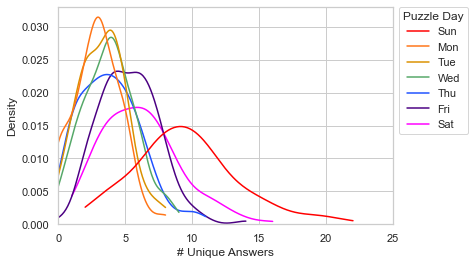

In [137]:
# Density plot of Unique Answers # in puzzles solved by IS2
# Rememember to use df3 because df4 has the copied-in data for plotting all completed puzzles together

IS2_df3 = IS2_df3.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=IS2_df3, x = "Unique_Answers", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True, cut=0, clip=(0,25))

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(0, 25)
ax.set_xlabel("# Unique Answers")
plt.show()

In [138]:
IS2_df3["Unique_Answers"].agg(['min', 'max'])

min     0
max    22
Name: Unique_Answers, dtype: int64

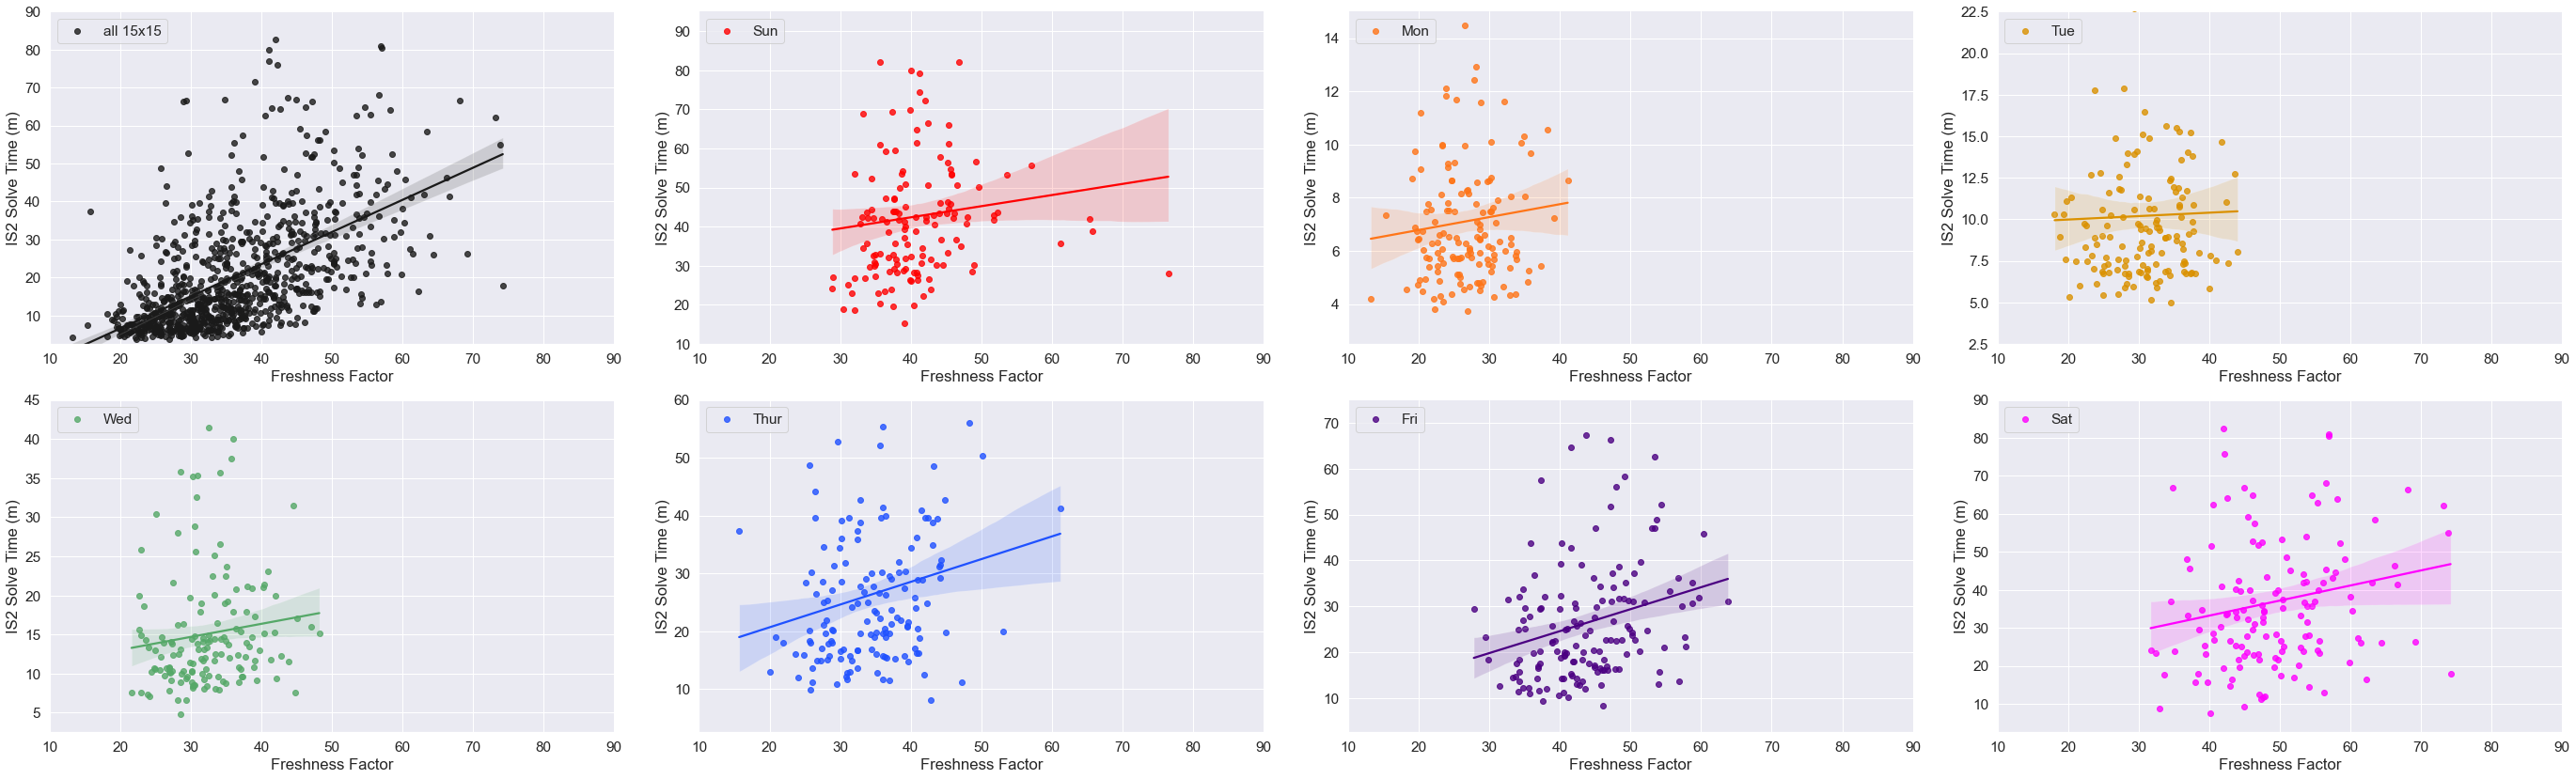

In [139]:
# Freshness Factor vs IS2 Raw Solve Times

IS2_df4 = IS2_df4.sort_values(by=['DOW_num'], ascending = True)

IS2_df4['plot_seq_map'] = IS2_df4['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS2_df4, x="Freshness_Factor", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "Freshness Factor",
    ylabel="IS2 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((10,90))
p.axes[1].set_xlim((10,90))
p.axes[2].set_xlim((10,90))
p.axes[3].set_xlim((10,90))
p.axes[4].set_xlim((10,90))
p.axes[5].set_xlim((10,90))
p.axes[6].set_xlim((10,90))
p.axes[7].set_xlim((10,90))

p.axes[0].set_ylim((2.5,90))
p.axes[1].set_ylim((10,95))
p.axes[2].set_ylim((2.5,15))
p.axes[3].set_ylim((2.5,22.5))
p.axes[4].set_ylim((2.5,45))
p.axes[5].set_ylim((2.5,60))
p.axes[6].set_ylim((2.5,75))
p.axes[7].set_ylim((2.5,90))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [140]:
# Calculate Pearson R for 15x15 grids for IS2 for this feature
#IS2_15x15 = IS2_df3.loc[IS2_df3["DOW"]!=("Sunday")]

print(IS2_15x15['IST(m)'].corr(IS2_15x15['Freshness_Factor']))

0.5588498870201076


In [141]:
# Calculate Pearson R for 15x15 grids for GMS for this feature
#IS2_15x15 = IS2_df3.loc[IS2_df3["DOW"]!=("Sunday")]

print(IS2_15x15['GMST(m)'].corr(IS2_15x15['Freshness_Factor']))

0.6643132117216402


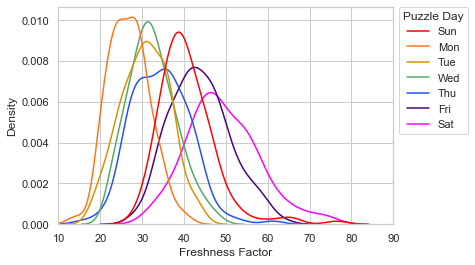

In [142]:
# Density plot of Freshness Factor in puzzles solved by IS2
# Rememember to use df3 because df4 has the copied-in data for plotting all completed puzzles together

IS2_df3 = IS2_df3.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=IS2_df3, x = "Freshness_Factor", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(10, 90)
ax.set_xlabel("Freshness Factor")
plt.show()

In [143]:
IS2_df3["Freshness_Factor"].agg(['min', 'max'])

min    13.2
max    76.5
Name: Freshness_Factor, dtype: float64

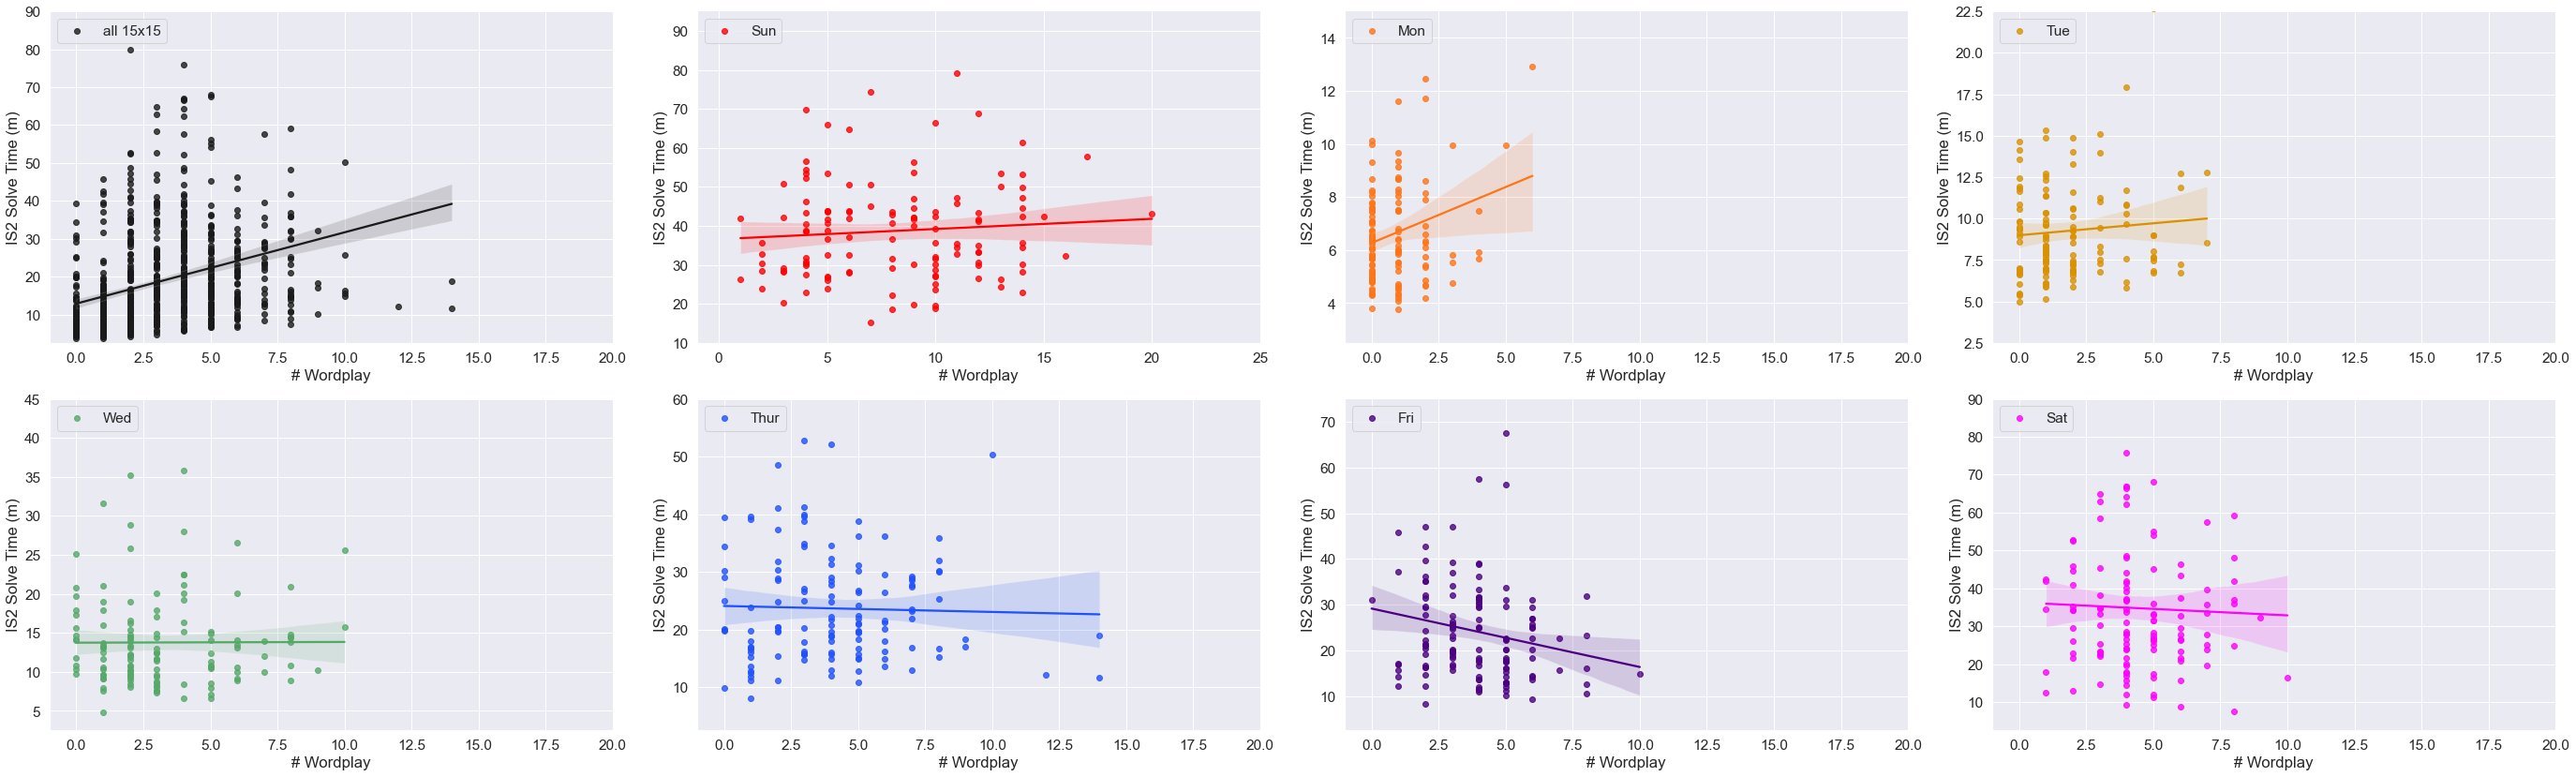

In [144]:
# Wordplay vs IS2 Raw Solve Times

IS2_df4 = IS2_df4.sort_values(by=['DOW_num'], ascending = True)

IS2_df4['plot_seq_map'] = IS2_df4['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS2_df4, x="Wordplay", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "# Wordplay",
    ylabel="IS2 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((-1,20))
p.axes[1].set_xlim((-1,25))
p.axes[2].set_xlim((-1,20))
p.axes[3].set_xlim((-1,20))
p.axes[4].set_xlim((-1,20))
p.axes[5].set_xlim((-1,20))
p.axes[6].set_xlim((-1,20))
p.axes[7].set_xlim((-1,20))

p.axes[0].set_ylim((2.5,90))
p.axes[1].set_ylim((10,95))
p.axes[2].set_ylim((2.5,15))
p.axes[3].set_ylim((2.5,22.5))
p.axes[4].set_ylim((2.5,45))
p.axes[5].set_ylim((2.5,60))
p.axes[6].set_ylim((2.5,75))
p.axes[7].set_ylim((2.5,90))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [145]:
# Calculate Pearson R for 15x15 grids for IS2 for this feature
#IS2_15x15 = IS2_df3.loc[IS2_df3["DOW"]!=("Sunday")]

print(IS2_15x15['IST(m)'].corr(IS2_15x15['Wordplay']))

0.3230365074855652


In [146]:
# Calculate Pearson R for 15x15 grids for GMS for this feature
#IS2_15x15 = IS2_df3.loc[IS2_df3["DOW"]!=("Sunday")]

print(IS2_15x15['GMST(m)'].corr(IS2_15x15['Wordplay']))

0.44163333990804565


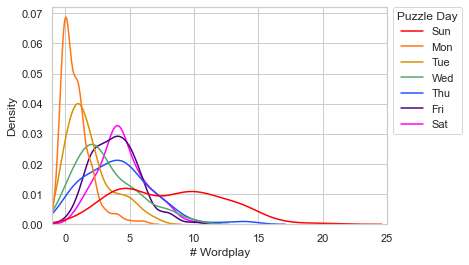

In [147]:
# Density plot of Wordplay in puzzles solved by IS2
# Rememember to use df3 because df4 has the copied-in data for plotting all completed puzzles together

IS2_df3 = IS2_df3.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=IS2_df3, x = "Wordplay", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(-1, 25)
ax.set_xlabel("# Wordplay")
plt.show()

In [148]:
IS2_df3["Wordplay"].agg(['min', 'max'])

min     0.0
max    20.0
Name: Wordplay, dtype: float64

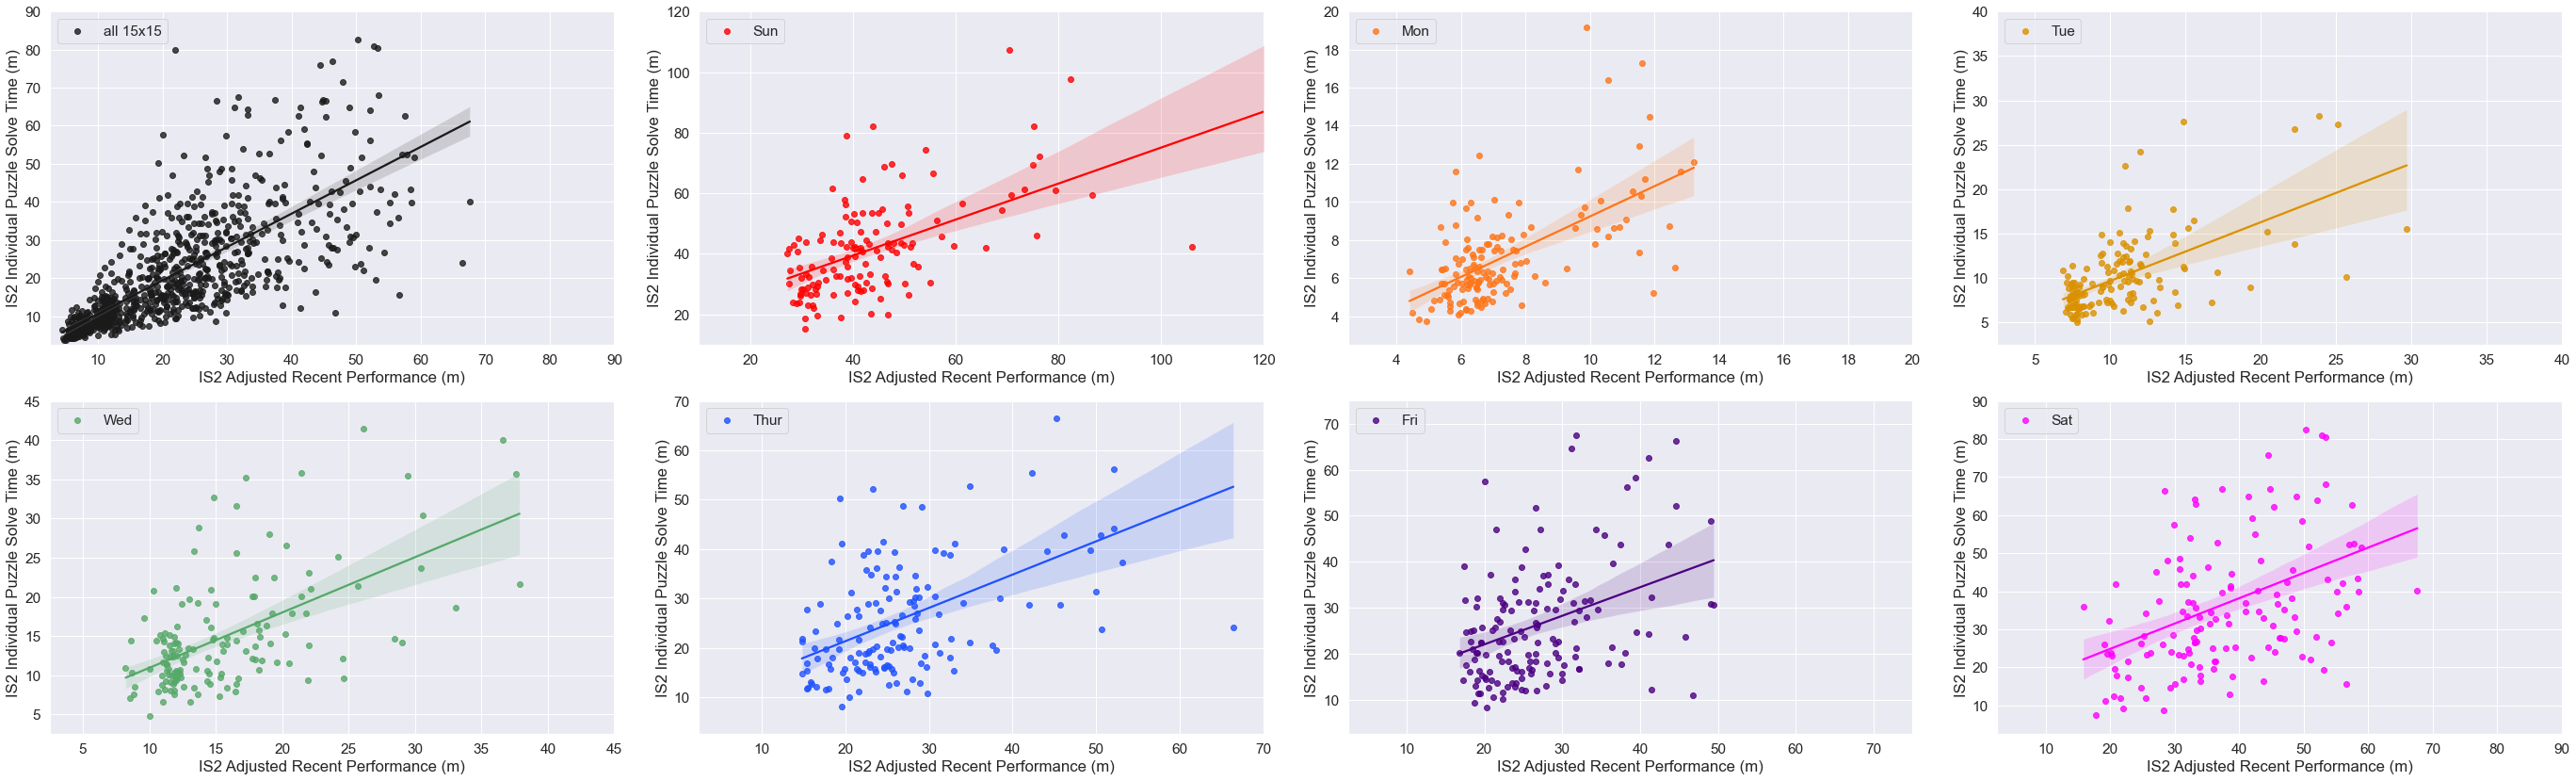

In [149]:
# IS2 Recent Past Performance (Time-Decay Weighted Immediately Previous 10 Puzzles Prior to a given puzzle) vs IS2 Raw Solve Times

IS2_df4 = IS2_df4.sort_values(by=['DOW_num'], ascending = True)

IS2_df4['plot_seq_map'] = IS2_df4['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS2_df4, x="IS_pds_l10_dw", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "IS2 Adjusted Recent Performance (m)",
    ylabel="IS2 Individual Puzzle Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((2.5,90))
p.axes[1].set_xlim((10,120))
p.axes[2].set_xlim((2.5,20))
p.axes[3].set_xlim((2.5,40))
p.axes[4].set_xlim((2.5,45))
p.axes[5].set_xlim((2.5,70))
p.axes[6].set_xlim((2.5,75))
p.axes[7].set_xlim((2.5,90))

p.axes[0].set_ylim((2.5,90))
p.axes[1].set_ylim((10,120))
p.axes[2].set_ylim((2.5,20))
p.axes[3].set_ylim((2.5,40))
p.axes[4].set_ylim((2.5,45))
p.axes[5].set_ylim((2.5,70))
p.axes[6].set_ylim((2.5,75))
p.axes[7].set_ylim((2.5,90))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [150]:
# Calculate Pearson R for 15x15 grids for IS2 for this feature
#IS2_15x15 = IS2_df3.loc[IS2_df3["DOW"]!=("Sunday")]

print(IS2_15x15['IST(m)'].corr(IS2_15x15['IS_pds_l10_dw']))

# Calculate Pearson R for each puzzle day for this feature
IS2_Sun = IS2_df3.loc[IS2_df3["DOW"]==("Sunday")]
print(IS2_Sun['IST(m)'].corr(IS2_Sun['IS_pds_l10_dw']))

IS2_Mon = IS2_df3.loc[IS2_df3["DOW"]==("Monday")]
print(IS2_Mon['IST(m)'].corr(IS2_Mon['IS_pds_l10_dw']))

IS2_Tue = IS2_df3.loc[IS2_df3["DOW"]==("Tuesday")]
print(IS2_Tue['IST(m)'].corr(IS2_Tue['IS_pds_l10_dw']))

IS2_Wed = IS2_df3.loc[IS2_df3["DOW"]==("Wednesday")]
print(IS2_Wed['IST(m)'].corr(IS2_Wed['IS_pds_l10_dw']))

IS2_Thu = IS2_df3.loc[IS2_df3["DOW"]==("Thursday")]
print(IS2_Thu['IST(m)'].corr(IS2_Thu['IS_pds_l10_dw']))

IS2_Fri = IS2_df3.loc[IS2_df3["DOW"]==("Friday")]
print(IS2_Fri['IST(m)'].corr(IS2_Fri['IS_pds_l10_dw']))

IS2_Sat = IS2_df3.loc[IS2_df3["DOW"]==("Saturday")]
print(IS2_Sat['IST(m)'].corr(IS2_Sat['IS_pds_l10_dw']))

0.7371917464925551
0.5760960008912009
0.6033883476654188
0.5974847610177555
0.5802833446792444
0.5074958120130825
0.3533623256467576
0.3889741102261575


In [151]:
IS2_15x15.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 887 entries, 6 to 2097
Data columns (total 54 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   P_Date                                   887 non-null    datetime64[ns]
 1   P_Date_str                               887 non-null    object        
 2   P_Yr                                     887 non-null    period[A-DEC] 
 3   2023+_puzzle                             887 non-null    float64       
 4   DOW                                      887 non-null    object        
 5   DOW_num                                  887 non-null    float64       
 6   GMST(m)                                  887 non-null    float64       
 7   GMST(m)_10p_MA                           887 non-null    float64       
 8   Diff%_from_10pMA(GMS)                    887 non-null    int64         
 9   GMS_pds_l10_dw                           8

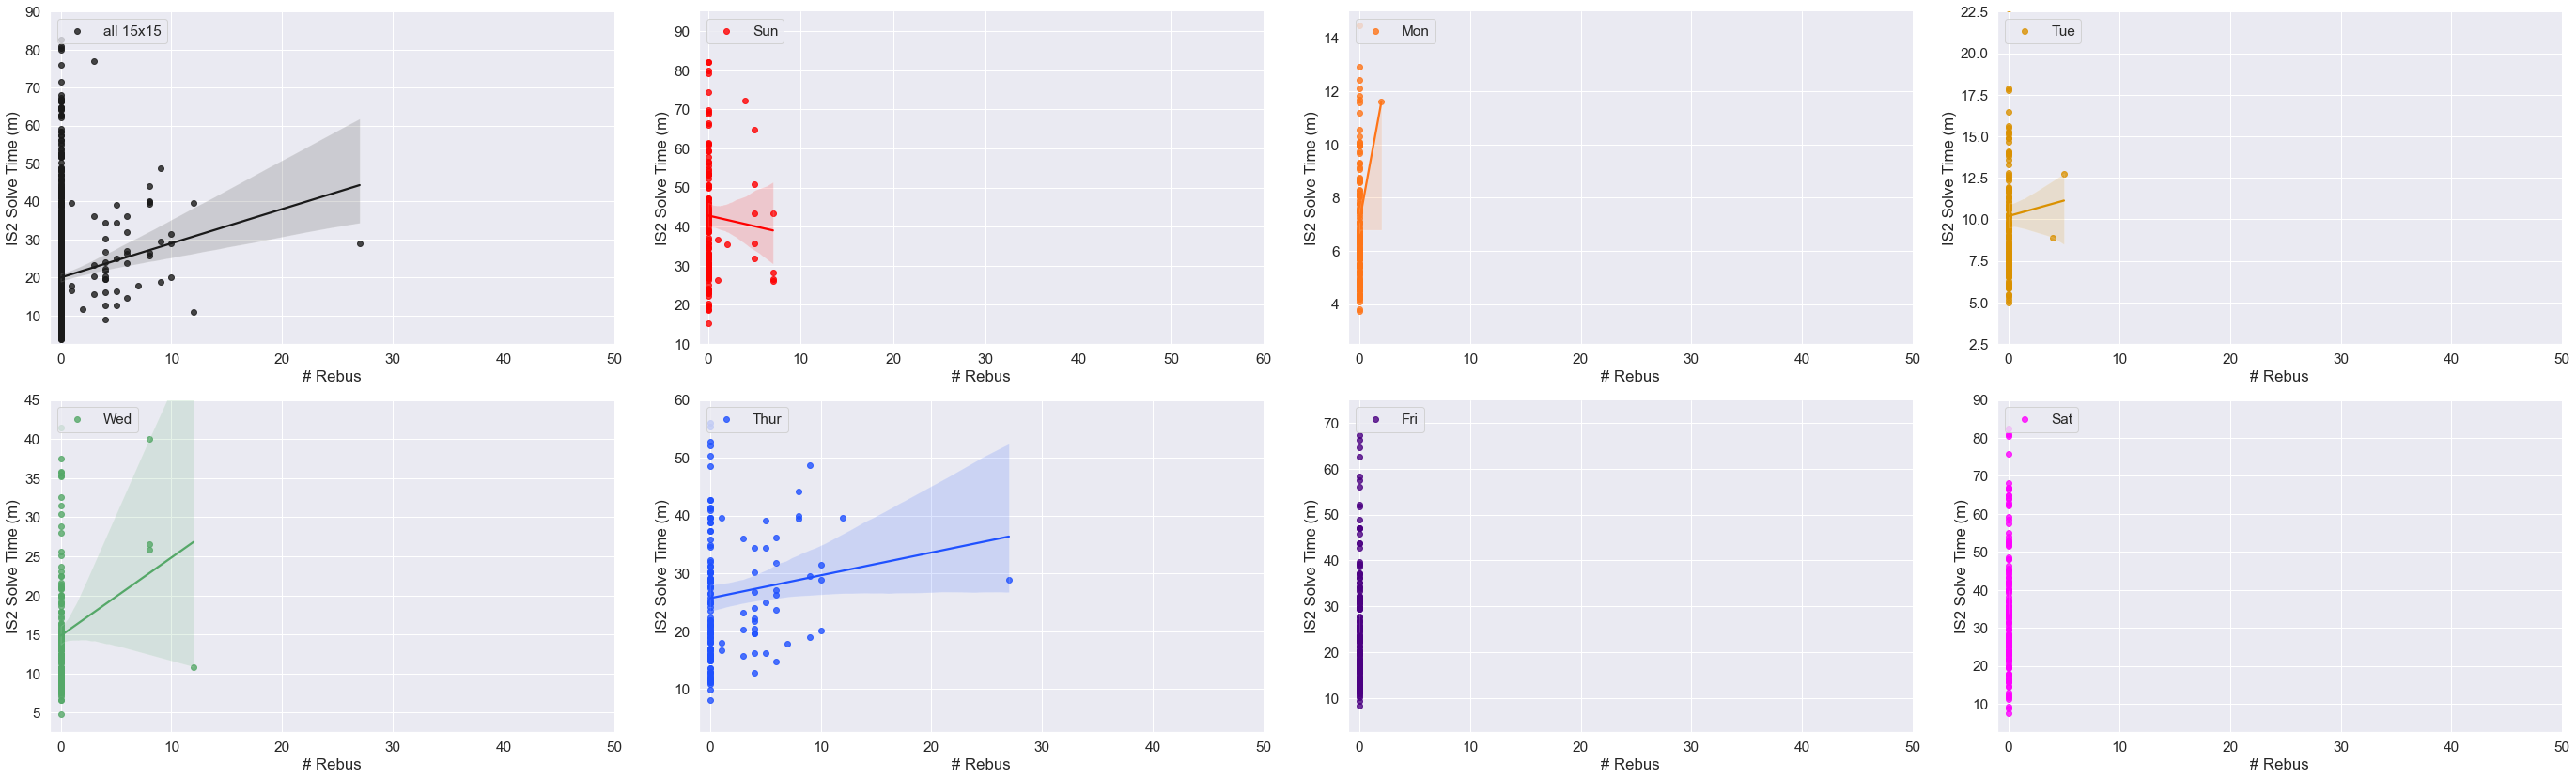

In [152]:
# Rebus vs IS2 Raw Solve Times

IS2_df4 = IS2_df4.sort_values(by=['DOW_num'], ascending = True)

IS2_df4['plot_seq_map'] = IS2_df4['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS2_df4, x="Rebus_Count", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "# Rebus",
    ylabel="IS2 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((-1,50))
p.axes[1].set_xlim((-1,60))
p.axes[2].set_xlim((-1,50))
p.axes[3].set_xlim((-1,50))
p.axes[4].set_xlim((-1,50))
p.axes[5].set_xlim((-1,50))
p.axes[6].set_xlim((-1,50))
p.axes[7].set_xlim((-1,50))

p.axes[0].set_ylim((2.5,90))
p.axes[1].set_ylim((10,95))
p.axes[2].set_ylim((2.5,15))
p.axes[3].set_ylim((2.5,22.5))
p.axes[4].set_ylim((2.5,45))
p.axes[5].set_ylim((2.5,60))
p.axes[6].set_ylim((2.5,75))
p.axes[7].set_ylim((2.5,90))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [153]:
# Calculate Pearson R for 15x15 grids for IS2 for this feature
#IS2_15x15 = IS2_df3.loc[IS2_df3["DOW"]!=("Sunday")]

print(IS2_15x15['IST(m)'].corr(IS2_15x15['Rebus_Count']))

# Calculate Pearson R for each puzzle day for this feature
IS2_Sun = IS2_df3.loc[IS2_df3["DOW"]==("Sunday")]
print(IS2_Sun['IST(m)'].corr(IS2_Sun['Rebus_Count']))

IS2_Mon = IS2_df3.loc[IS2_df3["DOW"]==("Monday")]
print(IS2_Mon['IST(m)'].corr(IS2_Mon['Rebus_Count']))

IS2_Tue = IS2_df3.loc[IS2_df3["DOW"]==("Tuesday")]
print(IS2_Tue['IST(m)'].corr(IS2_Tue['Rebus_Count']))

IS2_Wed = IS2_df3.loc[IS2_df3["DOW"]==("Wednesday")]
print(IS2_Wed['IST(m)'].corr(IS2_Wed['Rebus_Count']))

IS2_Thu = IS2_df3.loc[IS2_df3["DOW"]==("Thursday")]
print(IS2_Thu['IST(m)'].corr(IS2_Thu['Rebus_Count']))

IS2_Fri = IS2_df3.loc[IS2_df3["DOW"]==("Friday")]
print(IS2_Fri['IST(m)'].corr(IS2_Fri['Rebus_Count']))

IS2_Sat = IS2_df3.loc[IS2_df3["DOW"]==("Saturday")]
print(IS2_Sat['IST(m)'].corr(IS2_Sat['Rebus_Count']))

0.09832579746462461
-0.0459274627117873
0.14456223502846446
0.02101131289400456
0.2031088210782042
0.10673771304883048
nan
nan


In [154]:
# Calculate Pearson R for 15x15 grids for IS2 for this feature
#IS2_15x15 = IS2_df3.loc[IS2_df3["DOW"]!=("Sunday")]

print(IS2_15x15['GMST(m)'].corr(IS2_15x15['Rebus_Count']))

# Calculate Pearson R for each puzzle day for this feature
IS2_Sun = IS2_df3.loc[IS2_df3["DOW"]==("Sunday")]
print(IS2_Sun['GMST(m)'].corr(IS2_Sun['Rebus_Count']))

IS2_Mon = IS2_df3.loc[IS2_df3["DOW"]==("Monday")]
print(IS2_Mon['GMST(m)'].corr(IS2_Mon['Rebus_Count']))

IS2_Tue = IS2_df3.loc[IS2_df3["DOW"]==("Tuesday")]
print(IS2_Tue['GMST(m)'].corr(IS2_Tue['Rebus_Count']))

IS2_Wed = IS2_df3.loc[IS2_df3["DOW"]==("Wednesday")]
print(IS2_Wed['GMST(m)'].corr(IS2_Wed['Rebus_Count']))

IS2_Thu = IS2_df3.loc[IS2_df3["DOW"]==("Thursday")]
print(IS2_Thu['GMST(m)'].corr(IS2_Thu['Rebus_Count']))

IS2_Fri = IS2_df3.loc[IS2_df3["DOW"]==("Friday")]
print(IS2_Fri['GMST(m)'].corr(IS2_Fri['Rebus_Count']))

IS2_Sat = IS2_df3.loc[IS2_df3["DOW"]==("Saturday")]
print(IS2_Sat['GMST(m)'].corr(IS2_Sat['Rebus_Count']))

0.13017764533354678
0.06064694730194466
0.15352668120484494
0.05768054216625763
0.13058877099871283
0.19224699130225037
nan
nan


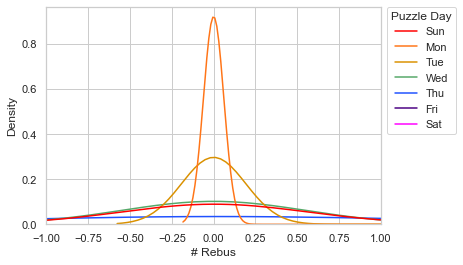

In [155]:
# Density plot of Rebus Count in puzzles solved by IS2
# Rememember to use df3 because df4 has the copied-in data for plotting all completed puzzles together

IS2_df3 = IS2_df3.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=IS2_df3, x = "Rebus_Count", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(-1, 1)
ax.set_xlabel("# Rebus")
plt.show()

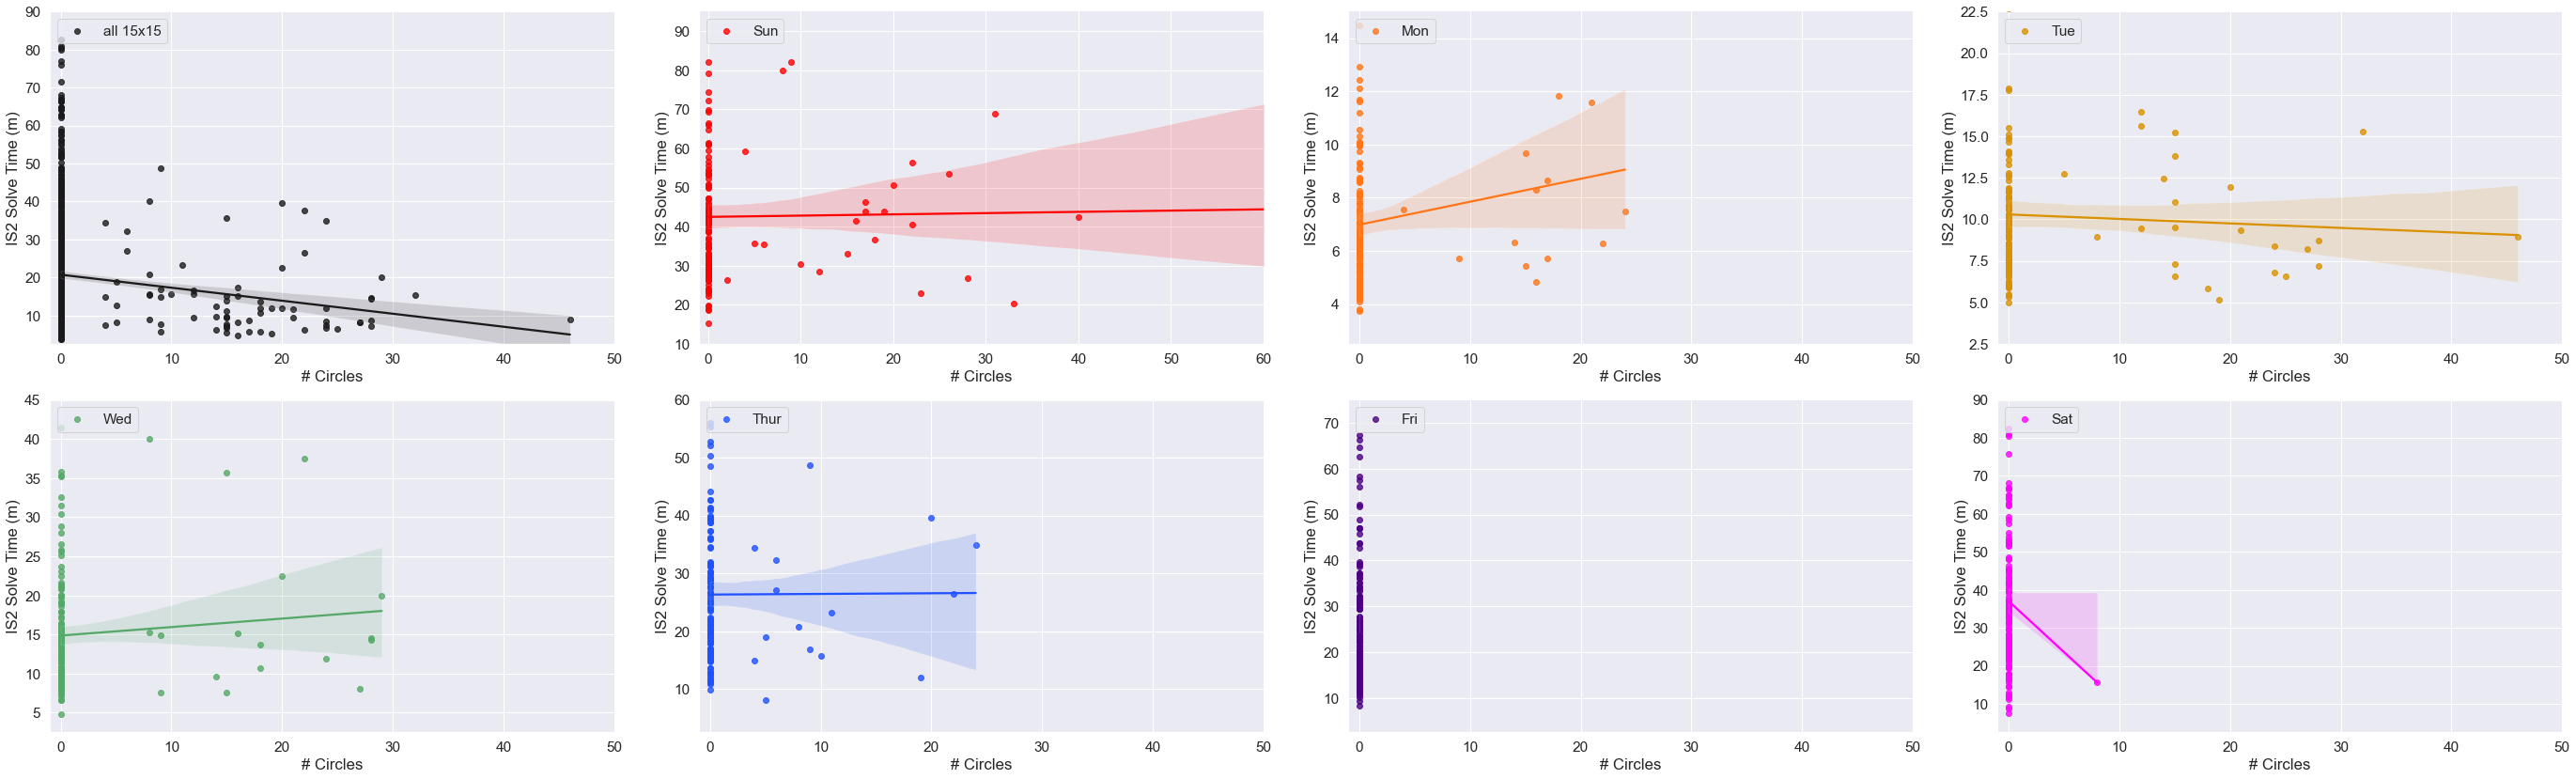

In [156]:
# Circles vs IS2 Raw Solve Times

IS2_df4 = IS2_df4.sort_values(by=['DOW_num'], ascending = True)

IS2_df4['plot_seq_map'] = IS2_df4['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS2_df4, x="Circle_Count", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "# Circles",
    ylabel="IS2 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((-1,50))
p.axes[1].set_xlim((-1,60))
p.axes[2].set_xlim((-1,50))
p.axes[3].set_xlim((-1,50))
p.axes[4].set_xlim((-1,50))
p.axes[5].set_xlim((-1,50))
p.axes[6].set_xlim((-1,50))
p.axes[7].set_xlim((-1,50))

p.axes[0].set_ylim((2.5,90))
p.axes[1].set_ylim((10,95))
p.axes[2].set_ylim((2.5,15))
p.axes[3].set_ylim((2.5,22.5))
p.axes[4].set_ylim((2.5,45))
p.axes[5].set_ylim((2.5,60))
p.axes[6].set_ylim((2.5,75))
p.axes[7].set_ylim((2.5,90))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [157]:
# Calculate Pearson R for IS2 for 15x15 grids for this feature
#IS2_15x15 = IS2_df3.loc[IS2_df3["DOW"]!=("Sunday")]

print(IS2_15x15['IST(m)'].corr(IS2_15x15['Circle_Count']))

# Calculate Pearson R for each puzzle day for this feature
IS2_Sun = IS2_df3.loc[IS2_df3["DOW"]==("Sunday")]
print(IS2_Sun['IST(m)'].corr(IS2_Sun['Circle_Count']))

IS2_Mon = IS2_df3.loc[IS2_df3["DOW"]==("Monday")]
print(IS2_Mon['IST(m)'].corr(IS2_Mon['Circle_Count']))

IS2_Tue = IS2_df3.loc[IS2_df3["DOW"]==("Tuesday")]
print(IS2_Tue['IST(m)'].corr(IS2_Tue['Circle_Count']))

IS2_Wed = IS2_df3.loc[IS2_df3["DOW"]==("Wednesday")]
print(IS2_Wed['IST(m)'].corr(IS2_Wed['Circle_Count']))

IS2_Thu = IS2_df3.loc[IS2_df3["DOW"]==("Thursday")]
print(IS2_Thu['IST(m)'].corr(IS2_Thu['Circle_Count']))

IS2_Fri = IS2_df3.loc[IS2_df3["DOW"]==("Friday")]
print(IS2_Fri['IST(m)'].corr(IS2_Fri['Circle_Count']))

IS2_Sat = IS2_df3.loc[IS2_df3["DOW"]==("Saturday")]
print(IS2_Sat['IST(m)'].corr(IS2_Sat['Circle_Count']))

-0.11155208821380402
0.01665757097486096
0.16524528794823515
-0.04622380500517475
0.09286430884313118
0.003417475222857672
nan
-0.09497763595280362


In [158]:
# Calculate Pearson R for 15x15 grids for GMS for this feature
#IS2_15x15 = IS2_df3.loc[IS2_df3["DOW"]!=("Sunday")]

print(IS2_15x15['GMST(m)'].corr(IS2_15x15['Circle_Count']))

# Calculate Pearson R for each puzzle day for this feature
IS2_Sun = IS2_df3.loc[IS2_df3["DOW"]==("Sunday")]
print(IS2_Sun['GMST(m)'].corr(IS2_Sun['Circle_Count']))

IS2_Mon = IS2_df3.loc[IS2_df3["DOW"]==("Monday")]
print(IS2_Mon['GMST(m)'].corr(IS2_Mon['Circle_Count']))

IS2_Tue = IS2_df3.loc[IS2_df3["DOW"]==("Tuesday")]
print(IS2_Tue['GMST(m)'].corr(IS2_Tue['Circle_Count']))

IS2_Wed = IS2_df3.loc[IS2_df3["DOW"]==("Wednesday")]
print(IS2_Wed['GMST(m)'].corr(IS2_Wed['Circle_Count']))

IS2_Thu = IS2_df3.loc[IS2_df3["DOW"]==("Thursday")]
print(IS2_Thu['GMST(m)'].corr(IS2_Thu['Circle_Count']))

IS2_Fri = IS2_df3.loc[IS2_df3["DOW"]==("Friday")]
print(IS2_Fri['GMST(m)'].corr(IS2_Fri['Circle_Count']))

IS2_Sat = IS2_df3.loc[IS2_df3["DOW"]==("Saturday")]
print(IS2_Sat['GMST(m)'].corr(IS2_Sat['Circle_Count']))

-0.13527500592381447
-0.020058590482785923
0.21554188124589718
0.014769122860111093
0.09420018739019856
-0.04704602922646218
nan
-0.04933288874614819


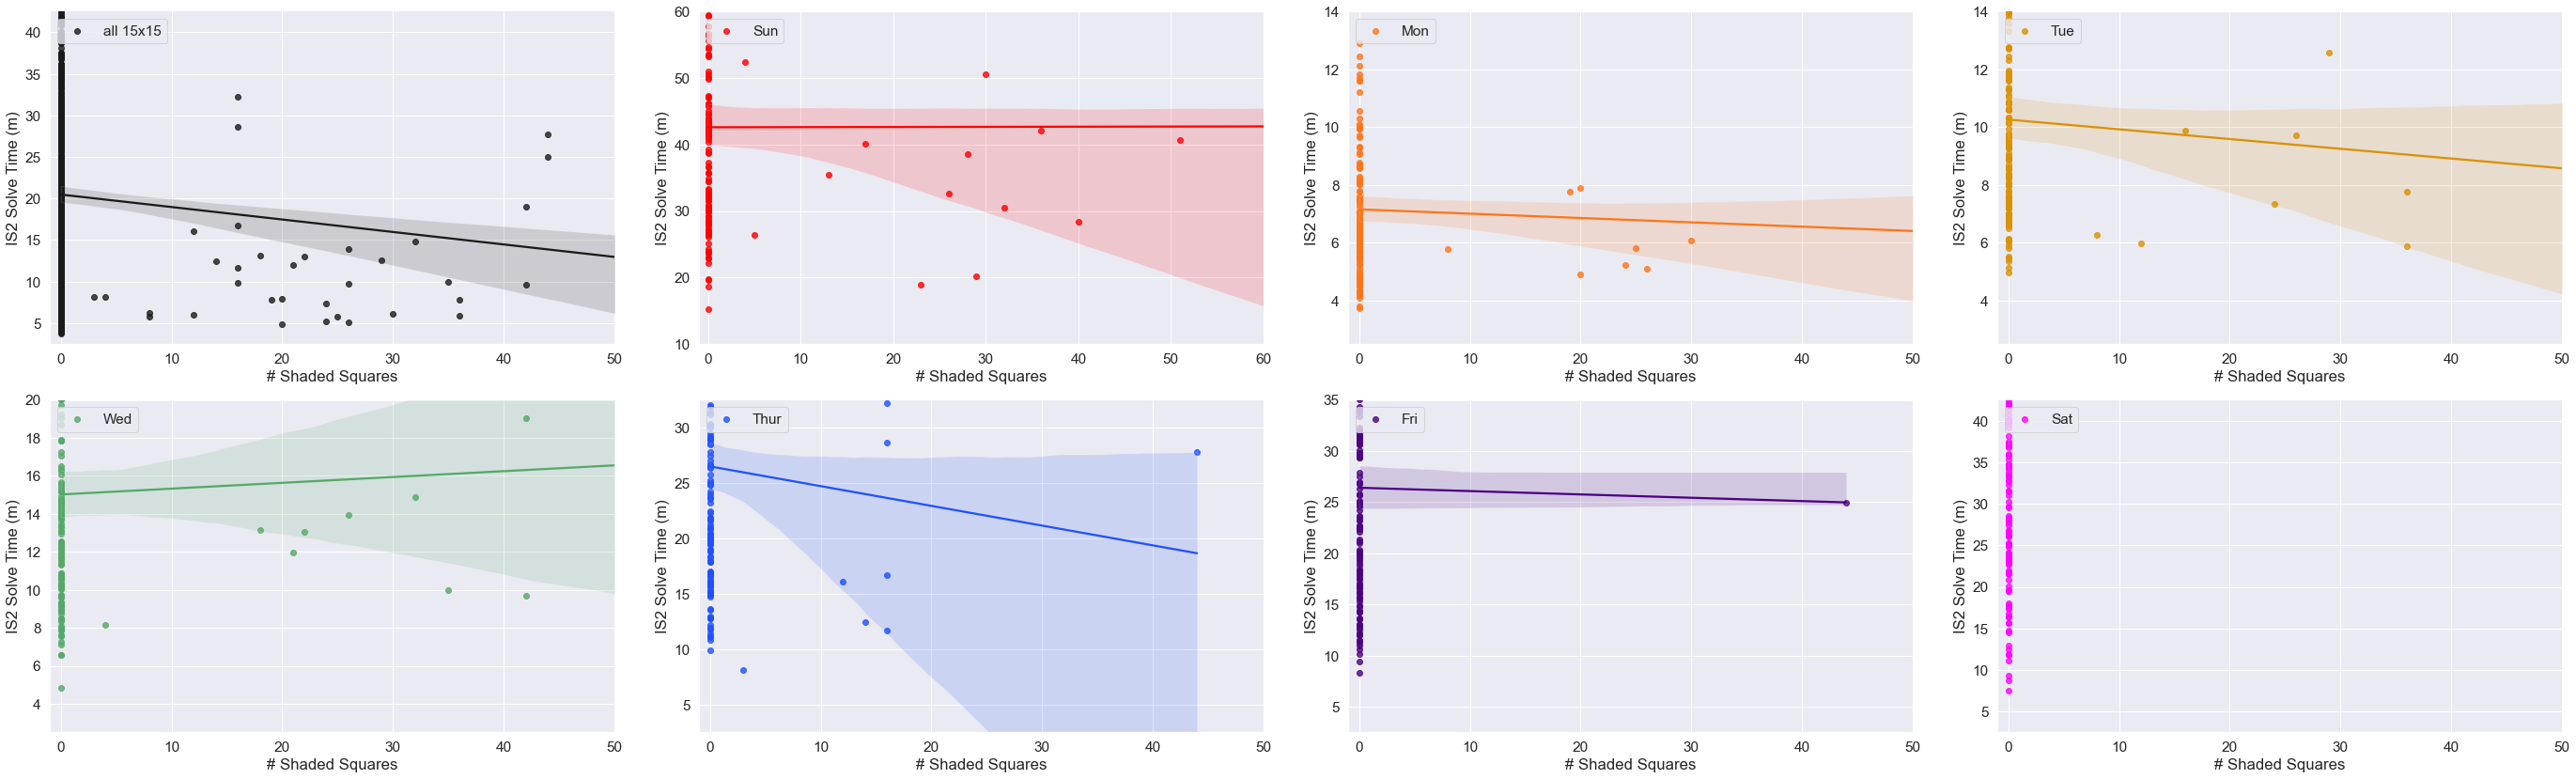

In [159]:
# Shaded Squares vs IS2 Raw Solve Times

IS2_df4 = IS2_df4.sort_values(by=['DOW_num'], ascending = True)

IS2_df4['plot_seq_map'] = IS2_df4['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS2_df4, x="Shade_Count", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "# Shaded Squares",
    ylabel="IS2 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((-1,50))
p.axes[1].set_xlim((-1,60))
p.axes[2].set_xlim((-1,50))
p.axes[3].set_xlim((-1,50))
p.axes[4].set_xlim((-1,50))
p.axes[5].set_xlim((-1,50))
p.axes[6].set_xlim((-1,50))
p.axes[7].set_xlim((-1,50))

p.axes[0].set_ylim((2.5,42.5))
p.axes[1].set_ylim((10,60))
p.axes[2].set_ylim((2.5,14))
p.axes[3].set_ylim((2.5,14))
p.axes[4].set_ylim((2.5,20))
p.axes[5].set_ylim((2.5,32.5))
p.axes[6].set_ylim((2.5,35))
p.axes[7].set_ylim((2.5,42.5))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [160]:
# Calculate Pearson R for IS2 for 15x15 grids for this feature
#IS2_15x15 = IS2_df3.loc[IS2_df3["DOW"]!=("Sunday")]

print(IS2_15x15['IST(m)'].corr(IS2_15x15['Shade_Count']))

# Calculate Pearson R for each puzzle day for this feature
IS2_Sun = IS2_df3.loc[IS2_df3["DOW"]==("Sunday")]
print(IS2_Sun['IST(m)'].corr(IS2_Sun['Shade_Count']))

IS2_Mon = IS2_df3.loc[IS2_df3["DOW"]==("Monday")]
print(IS2_Mon['IST(m)'].corr(IS2_Mon['Shade_Count']))

IS2_Tue = IS2_df3.loc[IS2_df3["DOW"]==("Tuesday")]
print(IS2_Tue['IST(m)'].corr(IS2_Tue['Shade_Count']))

IS2_Wed = IS2_df3.loc[IS2_df3["DOW"]==("Wednesday")]
print(IS2_Wed['IST(m)'].corr(IS2_Wed['Shade_Count']))

IS2_Thu = IS2_df3.loc[IS2_df3["DOW"]==("Thursday")]
print(IS2_Thu['IST(m)'].corr(IS2_Thu['Shade_Count']))

IS2_Fri = IS2_df3.loc[IS2_df3["DOW"]==("Friday")]
print(IS2_Fri['IST(m)'].corr(IS2_Fri['Shade_Count']))

IS2_Sat = IS2_df3.loc[IS2_df3["DOW"]==("Saturday")]
print(IS2_Sat['IST(m)'].corr(IS2_Sat['Shade_Count']))

-0.08260752873233698
0.002728250849280992
-0.09034369510936469
-0.0541594517017898
0.03980004092810143
-0.06399131296148672
-0.008786032065598063
nan


In [161]:
# Calculate Pearson R for GMS for 15x15 grids for this feature
#IS2_15x15 = IS2_df3.loc[IS2_df3["DOW"]!=("Sunday")]

print(IS2_15x15['GMST(m)'].corr(IS2_15x15['Shade_Count']))

# Calculate Pearson R for each puzzle day for this feature
IS2_Sun = IS2_df3.loc[IS2_df3["DOW"]==("Sunday")]
print(IS2_Sun['GMST(m)'].corr(IS2_Sun['Shade_Count']))

IS2_Mon = IS2_df3.loc[IS2_df3["DOW"]==("Monday")]
print(IS2_Mon['GMST(m)'].corr(IS2_Mon['Shade_Count']))

IS2_Tue = IS2_df3.loc[IS2_df3["DOW"]==("Tuesday")]
print(IS2_Tue['GMST(m)'].corr(IS2_Tue['Shade_Count']))

IS2_Wed = IS2_df3.loc[IS2_df3["DOW"]==("Wednesday")]
print(IS2_Wed['GMST(m)'].corr(IS2_Wed['Shade_Count']))

IS2_Thu = IS2_df3.loc[IS2_df3["DOW"]==("Thursday")]
print(IS2_Thu['GMST(m)'].corr(IS2_Thu['Shade_Count']))

IS2_Fri = IS2_df3.loc[IS2_df3["DOW"]==("Friday")]
print(IS2_Fri['GMST(m)'].corr(IS2_Fri['Shade_Count']))

IS2_Sat = IS2_df3.loc[IS2_df3["DOW"]==("Saturday")]
print(IS2_Sat['GMST(m)'].corr(IS2_Sat['Shade_Count']))

-0.08421432791176742
0.06284124485216792
-0.05523890270731346
-0.03546283064889599
0.08292705641417035
0.03509643762500378
0.03961772858856485
nan
